In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

import sklearn
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, cross_val_score
import lightgbm as lgb

print('tensorflow == {}'.format(tf.__version__))
print('pandas == {}'.format(pd.__version__))
print('numpy == {}'.format(np.__version__))
print('sklearn == {}'.format(sklearn.__version__))

# 获取上一级目录
path = os.path.dirname(os.getcwd())
path

tensorflow == 2.2.0
pandas == 1.1.0
numpy == 1.18.5
sklearn == 0.23.2


'/home/adt/project/molding'

In [2]:
# 决赛高频sensor数据先解压至 sensor_data 的文件夹
hf_train_pre_path = '/赛题二-初赛/Train/sensor_data'
hf_test_pre_path = '/赛题二-决赛/任务A/sensor_data'

# set数据训练集及决赛一致，使用一份
set_pre_path = '/赛题二-初赛/Train/data_set.csv'
# size训练集
y_train_path = '/赛题二-初赛/Train/Size.csv'
# spc数据存放地址
spc_train_pre_path = '/赛题二-初赛/Train/data_spc.csv'
spc_test_pre_path = '/赛题二-决赛/任务A/data_spc.csv'

# 读取高频数据，并按照文件名排序，确保文件顺序与spc一致
hf_train_pre_files = os.listdir(path + hf_train_pre_path)
hf_train_pre_files.sort()
hf_test_pre_files = os.listdir(path + hf_test_pre_path)
hf_test_pre_files.sort()

df_set_pre = pd.read_csv(path + set_pre_path)
df_y_train = pd.read_csv(path + y_train_path)
df_spc_train_pre = pd.read_csv(path + spc_train_pre_path)
df_spc_test_pre = pd.read_csv(path + spc_test_pre_path)


print(df_set_pre.shape)
print(df_spc_train_pre.shape)
print(df_y_train.shape)
print(df_spc_test_pre.shape)




(295, 347)
(16600, 86)
(16600, 4)
(3971, 86)


In [3]:
# 检测读入高频csv文件，其Id顺序是否与spc一致
hf_train_pre_files[-10:]

['mold_data_617562904_150671.csv',
 'mold_data_617563110_150676.csv',
 'mold_data_617563317_150681.csv',
 'mold_data_617563523_150686.csv',
 'mold_data_617563729_150691.csv',
 'mold_data_617563935_150696.csv',
 'mold_data_617564141_150701.csv',
 'mold_data_617564347_150706.csv',
 'mold_data_617564553_150711.csv',
 'mold_data_617564759_150716.csv']

In [4]:
hf_test_pre_files[-10:]

['mold_data_619285429_175771.csv',
 'mold_data_619287587_175826.csv',
 'mold_data_619288176_175841.csv',
 'mold_data_619288961_175861.csv',
 'mold_data_619289549_175876.csv',
 'mold_data_619292103_175941.csv',
 'mold_data_619292692_175956.csv',
 'mold_data_619293281_175971.csv',
 'mold_data_619299169_176121.csv',
 'mold_data_619299758_176136.csv']

In [5]:
# 高频特征，并增加均值特征

hf_cols =['Sensor1', 'Sensor2', 'Sensor3', 'IJ', 'Sensor5',
       'Sensor6', 'MouldTemp1', 'MouldTemp2', 'MouldTemp3', 'MouldTemp4',
       'MouldTemp5', 'MouldTemp9', 'MouldTemp10', 'MouldTemp11', 'MouldTemp12',
       'MouldTemp13', 'MouldTemp14', 'Sensor8', 'MouldFlow1', 'MouldFlow2',
       'MouldFlow3', 'SP']
hf_mean_cols = []

for col in hf_cols:
    hf_mean_cols.append(col+'_mean')
    
len(hf_mean_cols)



22

In [6]:
# 抽取单个高频csv文件中每列的平均值
def extract_mean_feat(data, cols):
    mean=[]
    temp = data.loc[:, cols]
    for c in cols:
        mean.append(temp[c].mean())
    return np.array(mean)

# 根据高频文件存放路径及文件名称，抽取特征
# files_path 高频文件存放路径， files_list 高频文件名称列表
# cols为高频传感器特征，mean_cols为添加_mean后特征
def extract_hf_files(files_path, files_list, cols, mean_cols):

    hf_id = []
    hf_mean = np.zeros((len(files_list),len(cols)))

    for i,file in enumerate(files_list):
        print(i, file)
        # 逐个读入高频csv文件
        f_data = pd.read_csv(os.path.join(path + files_path, file))
        file_name = file.split('_')
        file_id = file_name[3].replace('.csv','')
        # 获得Id
        hf_id.append(int(file_id))
        
        hf_mean[i] = extract_mean_feat(f_data, cols)
        
    df_hf = pd.DataFrame(hf_mean, columns=mean_cols)
    df_hf['Id'] = hf_id
    
    return df_hf

# 抽取决赛集集训练集高频数据
hf_test_pre = extract_hf_files(hf_test_pre_path, hf_test_pre_files, hf_cols, hf_mean_cols)
hf_train_pre = extract_hf_files(hf_train_pre_path, hf_train_pre_files, hf_cols, hf_mean_cols)
        
print(hf_test_pre.shape)      
print(hf_train_pre.shape)      
hf_test_pre


0 mold_data_611925088_56694.csv
1 mold_data_611925276_56699.csv
2 mold_data_611925501_56705.csv
3 mold_data_611925613_56708.csv
4 mold_data_611925764_56712.csv
5 mold_data_611925877_56715.csv
6 mold_data_611926103_56721.csv
7 mold_data_611926178_56723.csv
8 mold_data_611926253_56725.csv
9 mold_data_611926328_56727.csv
10 mold_data_611926404_56729.csv
11 mold_data_611926517_56732.csv
12 mold_data_611926818_56740.csv
13 mold_data_611926968_56744.csv
14 mold_data_611927043_56746.csv
15 mold_data_611927119_56748.csv
16 mold_data_611927194_56750.csv
17 mold_data_611927645_56762.csv
18 mold_data_611927683_56763.csv
19 mold_data_611927758_56765.csv
20 mold_data_611927984_56771.csv
21 mold_data_611928059_56773.csv
22 mold_data_611928360_56781.csv
23 mold_data_611928661_56789.csv
24 mold_data_611928736_56791.csv
25 mold_data_611928887_56795.csv
26 mold_data_611929037_56799.csv
27 mold_data_611929113_56801.csv
28 mold_data_611929263_56805.csv
29 mold_data_611929414_56809.csv
30 mold_data_6119296

248 mold_data_611958154_57573.csv
249 mold_data_611958304_57577.csv
250 mold_data_611958417_57580.csv
251 mold_data_611958492_57582.csv
252 mold_data_611958568_57584.csv
253 mold_data_611958605_57585.csv
254 mold_data_611958831_57591.csv
255 mold_data_611958869_57592.csv
256 mold_data_611959013_57594.csv
257 mold_data_611959089_57596.csv
258 mold_data_611959126_57597.csv
259 mold_data_611959352_57603.csv
260 mold_data_611959390_57604.csv
261 mold_data_611959465_57606.csv
262 mold_data_611959578_57609.csv
263 mold_data_611959616_57610.csv
264 mold_data_611959653_57611.csv
265 mold_data_611959804_57615.csv
266 mold_data_611959992_57620.csv
267 mold_data_611960180_57625.csv
268 mold_data_611960255_57627.csv
269 mold_data_611960293_57628.csv
270 mold_data_611960330_57629.csv
271 mold_data_611960368_57630.csv
272 mold_data_611960405_57631.csv
273 mold_data_611960556_57635.csv
274 mold_data_611960593_57636.csv
275 mold_data_611960631_57637.csv
276 mold_data_611960706_57639.csv
277 mold_data_

491 mold_data_611979897_58149.csv
492 mold_data_611980010_58152.csv
493 mold_data_611980085_58154.csv
494 mold_data_611980123_58155.csv
495 mold_data_611980311_58160.csv
496 mold_data_611980349_58161.csv
497 mold_data_611980462_58164.csv
498 mold_data_611980537_58166.csv
499 mold_data_611980612_58168.csv
500 mold_data_611980688_58170.csv
501 mold_data_611980725_58171.csv
502 mold_data_611980838_58174.csv
503 mold_data_611980876_58175.csv
504 mold_data_611980951_58177.csv
505 mold_data_611981026_58179.csv
506 mold_data_611981064_58180.csv
507 mold_data_611981139_58182.csv
508 mold_data_611981214_58184.csv
509 mold_data_611981327_58187.csv
510 mold_data_611981403_58189.csv
511 mold_data_611981440_58190.csv
512 mold_data_611981629_58195.csv
513 mold_data_611981704_58197.csv
514 mold_data_611981854_58201.csv
515 mold_data_611981892_58202.csv
516 mold_data_611981967_58204.csv
517 mold_data_611982005_58205.csv
518 mold_data_611982080_58207.csv
519 mold_data_611982155_58209.csv
520 mold_data_

733 mold_data_612005982_58842.csv
734 mold_data_612006095_58845.csv
735 mold_data_612006170_58847.csv
736 mold_data_612006321_58851.csv
737 mold_data_612006358_58852.csv
738 mold_data_612006396_58853.csv
739 mold_data_612006546_58857.csv
740 mold_data_612006847_58865.csv
741 mold_data_612007035_58870.csv
742 mold_data_612007110_58872.csv
743 mold_data_612007148_58873.csv
744 mold_data_612007223_58875.csv
745 mold_data_612007449_58881.csv
746 mold_data_612007487_58882.csv
747 mold_data_612007524_58883.csv
748 mold_data_612007600_58885.csv
749 mold_data_612007637_58886.csv
750 mold_data_612007713_58888.csv
751 mold_data_612007750_58889.csv
752 mold_data_612007863_58892.csv
753 mold_data_612007938_58894.csv
754 mold_data_612007976_58895.csv
755 mold_data_612008014_58896.csv
756 mold_data_612008089_58898.csv
757 mold_data_612008202_58901.csv
758 mold_data_612008277_58903.csv
759 mold_data_612008315_58904.csv
760 mold_data_612008390_58906.csv
761 mold_data_612008466_58908.csv
762 mold_data_

982 mold_data_612035235_59617.csv
983 mold_data_612035273_59618.csv
984 mold_data_612035348_59620.csv
985 mold_data_612035386_59621.csv
986 mold_data_612035462_59623.csv
987 mold_data_612035500_59624.csv
988 mold_data_612035613_59627.csv
989 mold_data_612035689_59629.csv
990 mold_data_612035802_59632.csv
991 mold_data_612035953_59636.csv
992 mold_data_613564859_83499.csv
993 mold_data_613564939_83501.csv
994 mold_data_613565019_83503.csv
995 mold_data_613565138_83506.csv
996 mold_data_613565298_83510.csv
997 mold_data_613565536_83516.csv
998 mold_data_613565616_83518.csv
999 mold_data_613565935_83526.csv
1000 mold_data_613566094_83530.csv
1001 mold_data_613566253_83534.csv
1002 mold_data_613566293_83535.csv
1003 mold_data_613568238_83539.csv
1004 mold_data_613568277_83540.csv
1005 mold_data_613568556_83547.csv
1006 mold_data_613568596_83548.csv
1007 mold_data_613568795_83553.csv
1008 mold_data_613568835_83554.csv
1009 mold_data_613568914_83556.csv
1010 mold_data_613568994_83558.csv
101

1221 mold_data_613592556_84150.csv
1222 mold_data_613592716_84154.csv
1223 mold_data_613592795_84156.csv
1224 mold_data_613592835_84157.csv
1225 mold_data_613592994_84161.csv
1226 mold_data_613593233_84167.csv
1227 mold_data_613593512_84174.csv
1228 mold_data_613593671_84178.csv
1229 mold_data_613593710_84179.csv
1230 mold_data_613593750_84180.csv
1231 mold_data_613593830_84182.csv
1232 mold_data_613593870_84183.csv
1233 mold_data_613593949_84185.csv
1234 mold_data_613593989_84186.csv
1235 mold_data_613594029_84187.csv
1236 mold_data_613594148_84190.csv
1237 mold_data_613594188_84191.csv
1238 mold_data_613594268_84193.csv
1239 mold_data_613594308_84194.csv
1240 mold_data_613594427_84197.csv
1241 mold_data_613594507_84199.csv
1242 mold_data_613594586_84201.csv
1243 mold_data_613594865_84208.csv
1244 mold_data_613594945_84210.csv
1245 mold_data_613594984_84211.csv
1246 mold_data_613595024_84212.csv
1247 mold_data_613595183_84216.csv
1248 mold_data_613595263_84218.csv
1249 mold_data_61359

1462 mold_data_613642129_85392.csv
1463 mold_data_613642249_85395.csv
1464 mold_data_613642408_85399.csv
1465 mold_data_613642527_85402.csv
1466 mold_data_613642567_85403.csv
1467 mold_data_613642647_85405.csv
1468 mold_data_613642766_85408.csv
1469 mold_data_613642806_85409.csv
1470 mold_data_613642846_85410.csv
1471 mold_data_613642965_85413.csv
1472 mold_data_613643005_85414.csv
1473 mold_data_613643125_85417.csv
1474 mold_data_613643324_85422.csv
1475 mold_data_613643483_85426.csv
1476 mold_data_613643602_85429.csv
1477 mold_data_613643681_85431.csv
1478 mold_data_613644079_85441.csv
1479 mold_data_613644318_85447.csv
1480 mold_data_613644557_85453.csv
1481 mold_data_613644756_85458.csv
1482 mold_data_613644875_85461.csv
1483 mold_data_613645114_85467.csv
1484 mold_data_613645233_85470.csv
1485 mold_data_613645473_85476.csv
1486 mold_data_613645894_85482.csv
1487 mold_data_613645934_85483.csv
1488 mold_data_613646213_85490.csv
1489 mold_data_613646292_85492.csv
1490 mold_data_61364

1708 mold_data_613850054_88381.csv
1709 mold_data_613850131_88383.csv
1710 mold_data_613850209_88385.csv
1711 mold_data_613850248_88386.csv
1712 mold_data_613850286_88387.csv
1713 mold_data_613850325_88388.csv
1714 mold_data_613850442_88391.csv
1715 mold_data_613850559_88394.csv
1716 mold_data_613850598_88395.csv
1717 mold_data_613851025_88406.csv
1718 mold_data_613851064_88407.csv
1719 mold_data_613851103_88408.csv
1720 mold_data_613851180_88410.csv
1721 mold_data_613851258_88412.csv
1722 mold_data_613851413_88416.csv
1723 mold_data_613851529_88419.csv
1724 mold_data_613851568_88420.csv
1725 mold_data_613851840_88427.csv
1726 mold_data_613851879_88428.csv
1727 mold_data_613852073_88433.csv
1728 mold_data_613852111_88434.csv
1729 mold_data_613852189_88436.csv
1730 mold_data_613852228_88437.csv
1731 mold_data_613852383_88441.csv
1732 mold_data_613852461_88443.csv
1733 mold_data_613852538_88445.csv
1734 mold_data_613852616_88447.csv
1735 mold_data_613852655_88448.csv
1736 mold_data_61385

1943 mold_data_613901865_89716.csv
1944 mold_data_613901943_89718.csv
1945 mold_data_613902059_89721.csv
1946 mold_data_613902137_89723.csv
1947 mold_data_613902409_89730.csv
1948 mold_data_613902448_89731.csv
1949 mold_data_613902564_89734.csv
1950 mold_data_613902642_89736.csv
1951 mold_data_613902797_89740.csv
1952 mold_data_613902875_89742.csv
1953 mold_data_613902913_89743.csv
1954 mold_data_613903030_89746.csv
1955 mold_data_613903146_89749.csv
1956 mold_data_613903379_89755.csv
1957 mold_data_613903457_89757.csv
1958 mold_data_613903690_89763.csv
1959 mold_data_613903729_89764.csv
1960 mold_data_613903845_89767.csv
1961 mold_data_613904078_89773.csv
1962 mold_data_613904272_89778.csv
1963 mold_data_613904427_89782.csv
1964 mold_data_613904505_89784.csv
1965 mold_data_613904660_89788.csv
1966 mold_data_613904699_89789.csv
1967 mold_data_613904738_89790.csv
1968 mold_data_613904932_89795.csv
1969 mold_data_613904971_89796.csv
1970 mold_data_613905010_89797.csv
1971 mold_data_61390

2181 mold_data_613935824_90591.csv
2182 mold_data_613935863_90592.csv
2183 mold_data_613935902_90593.csv
2184 mold_data_613935940_90594.csv
2185 mold_data_613935979_90595.csv
2186 mold_data_613936135_90599.csv
2187 mold_data_613936173_90600.csv
2188 mold_data_613936290_90603.csv
2189 mold_data_613936329_90604.csv
2190 mold_data_613936368_90605.csv
2191 mold_data_613936445_90607.csv
2192 mold_data_613936523_90609.csv
2193 mold_data_613936561_90610.csv
2194 mold_data_613936600_90611.csv
2195 mold_data_613936639_90612.csv
2196 mold_data_613936717_90614.csv
2197 mold_data_613936833_90617.csv
2198 mold_data_613936872_90618.csv
2199 mold_data_613936911_90619.csv
2200 mold_data_613937027_90622.csv
2201 mold_data_613937066_90623.csv
2202 mold_data_613937105_90624.csv
2203 mold_data_613937184_90626.csv
2204 mold_data_613937300_90629.csv
2205 mold_data_613937339_90630.csv
2206 mold_data_613937416_90632.csv
2207 mold_data_613937455_90633.csv
2208 mold_data_613937494_90634.csv
2209 mold_data_61393

2418 mold_data_617663833_153086.csv
2419 mold_data_617664039_153091.csv
2420 mold_data_617664245_153096.csv
2421 mold_data_617664863_153111.csv
2422 mold_data_617665481_153126.csv
2423 mold_data_617665894_153136.csv
2424 mold_data_617666306_153146.csv
2425 mold_data_617666512_153151.csv
2426 mold_data_617666924_153161.csv
2427 mold_data_617667130_153166.csv
2428 mold_data_617667955_153186.csv
2429 mold_data_617669398_153221.csv
2430 mold_data_617670222_153241.csv
2431 mold_data_617670429_153246.csv
2432 mold_data_617670635_153251.csv
2433 mold_data_617672078_153286.csv
2434 mold_data_617672284_153291.csv
2435 mold_data_617673109_153311.csv
2436 mold_data_617674139_153336.csv
2437 mold_data_617674345_153341.csv
2438 mold_data_617674552_153346.csv
2439 mold_data_617674964_153356.csv
2440 mold_data_617675170_153361.csv
2441 mold_data_617676200_153386.csv
2442 mold_data_617676819_153401.csv
2443 mold_data_617677850_153426.csv
2444 mold_data_617679086_153456.csv
2445 mold_data_617680734_153

2653 mold_data_617821460_156906.csv
2654 mold_data_617821667_156911.csv
2655 mold_data_617823316_156951.csv
2656 mold_data_617823522_156956.csv
2657 mold_data_617824553_156981.csv
2658 mold_data_617824759_156986.csv
2659 mold_data_617825171_156996.csv
2660 mold_data_617825377_157001.csv
2661 mold_data_617825790_157011.csv
2662 mold_data_617827438_157051.csv
2663 mold_data_617827644_157056.csv
2664 mold_data_617827850_157061.csv
2665 mold_data_617828262_157071.csv
2666 mold_data_617828674_157081.csv
2667 mold_data_617829292_157096.csv
2668 mold_data_617829499_157101.csv
2669 mold_data_617829705_157106.csv
2670 mold_data_617829911_157111.csv
2671 mold_data_617830941_157136.csv
2672 mold_data_617831147_157141.csv
2673 mold_data_617831353_157146.csv
2674 mold_data_617831765_157156.csv
2675 mold_data_617832382_157171.csv
2676 mold_data_617832588_157176.csv
2677 mold_data_617832794_157181.csv
2678 mold_data_617833619_157201.csv
2679 mold_data_617833825_157206.csv
2680 mold_data_617834237_157

2884 mold_data_617941639_159821.csv
2885 mold_data_617941846_159826.csv
2886 mold_data_617943289_159861.csv
2887 mold_data_617943908_159876.csv
2888 mold_data_617944321_159886.csv
2889 mold_data_617945146_159906.csv
2890 mold_data_617945558_159916.csv
2891 mold_data_617946383_159936.csv
2892 mold_data_617947002_159951.csv
2893 mold_data_617948239_159981.csv
2894 mold_data_617948445_159986.csv
2895 mold_data_617948651_159991.csv
2896 mold_data_617949477_160011.csv
2897 mold_data_617949889_160021.csv
2898 mold_data_617950302_160031.csv
2899 mold_data_617951127_160051.csv
2900 mold_data_617951540_160061.csv
2901 mold_data_617951746_160066.csv
2902 mold_data_617951952_160071.csv
2903 mold_data_617952158_160076.csv
2904 mold_data_617952365_160081.csv
2905 mold_data_617952571_160086.csv
2906 mold_data_617953189_160101.csv
2907 mold_data_617954427_160131.csv
2908 mold_data_617955252_160151.csv
2909 mold_data_617955458_160156.csv
2910 mold_data_617956283_160176.csv
2911 mold_data_617957108_160

3124 mold_data_618072606_162996.csv
3125 mold_data_618073018_163006.csv
3126 mold_data_618073636_163021.csv
3127 mold_data_618075079_163056.csv
3128 mold_data_618075285_163061.csv
3129 mold_data_618076316_163086.csv
3130 mold_data_618077141_163106.csv
3131 mold_data_618077760_163121.csv
3132 mold_data_618077966_163126.csv
3133 mold_data_618078378_163136.csv
3134 mold_data_618078791_163146.csv
3135 mold_data_618079821_163171.csv
3136 mold_data_618080027_163176.csv
3137 mold_data_618080439_163186.csv
3138 mold_data_618080852_163196.csv
3139 mold_data_618081058_163201.csv
3140 mold_data_618092910_163216.csv
3141 mold_data_618093528_163231.csv
3142 mold_data_618093734_163236.csv
3143 mold_data_618093940_163241.csv
3144 mold_data_618094558_163256.csv
3145 mold_data_618094764_163261.csv
3146 mold_data_618094971_163266.csv
3147 mold_data_618095177_163271.csv
3148 mold_data_618095589_163281.csv
3149 mold_data_618096001_163291.csv
3150 mold_data_618096207_163296.csv
3151 mold_data_618097443_163

3352 mold_data_618345034_166286.csv
3353 mold_data_618345448_166296.csv
3354 mold_data_618345655_166301.csv
3355 mold_data_618346068_166311.csv
3356 mold_data_618346689_166326.csv
3357 mold_data_618346895_166331.csv
3358 mold_data_618347309_166341.csv
3359 mold_data_618347929_166356.csv
3360 mold_data_618348550_166371.csv
3361 mold_data_618348963_166381.csv
3362 mold_data_618349584_166396.csv
3363 mold_data_618349790_166401.csv
3364 mold_data_618350204_166411.csv
3365 mold_data_618350824_166426.csv
3366 mold_data_618351031_166431.csv
3367 mold_data_618351650_166446.csv
3368 mold_data_618352477_166466.csv
3369 mold_data_618353097_166481.csv
3370 mold_data_618353511_166491.csv
3371 mold_data_618353924_166501.csv
3372 mold_data_618354131_166506.csv
3373 mold_data_618354958_166526.csv
3374 mold_data_618355164_166531.csv
3375 mold_data_618355371_166536.csv
3376 mold_data_618355784_166546.csv
3377 mold_data_618356198_166556.csv
3378 mold_data_618356611_166566.csv
3379 mold_data_618357024_166

3581 mold_data_618956053_169791.csv
3582 mold_data_618956464_169801.csv
3583 mold_data_618958312_169846.csv
3584 mold_data_618958723_169856.csv
3585 mold_data_618959134_169866.csv
3586 mold_data_618959339_169871.csv
3587 mold_data_618960161_169891.csv
3588 mold_data_618960572_169901.csv
3589 mold_data_618962215_169941.csv
3590 mold_data_618962625_169951.csv
3591 mold_data_618962831_169956.csv
3592 mold_data_618963242_169966.csv
3593 mold_data_618963858_169981.csv
3594 mold_data_618964679_170001.csv
3595 mold_data_618964884_170006.csv
3596 mold_data_618965090_170011.csv
3597 mold_data_618965295_170016.csv
3598 mold_data_618965501_170021.csv
3599 mold_data_618965911_170031.csv
3600 mold_data_618966322_170041.csv
3601 mold_data_618967142_170061.csv
3602 mold_data_618968168_170086.csv
3603 mold_data_618968579_170096.csv
3604 mold_data_618969605_170121.csv
3605 mold_data_618971864_170176.csv
3606 mold_data_618972275_170186.csv
3607 mold_data_618972480_170191.csv
3608 mold_data_618972891_170

3816 mold_data_619101451_173321.csv
3817 mold_data_619102486_173346.csv
3818 mold_data_619102693_173351.csv
3819 mold_data_619103313_173366.csv
3820 mold_data_619103728_173376.csv
3821 mold_data_619104142_173386.csv
3822 mold_data_619104556_173396.csv
3823 mold_data_619104762_173401.csv
3824 mold_data_619105177_173411.csv
3825 mold_data_619105798_173426.csv
3826 mold_data_619106418_173441.csv
3827 mold_data_619106625_173446.csv
3828 mold_data_619107039_173456.csv
3829 mold_data_619107453_173466.csv
3830 mold_data_619107660_173471.csv
3831 mold_data_619108489_173491.csv
3832 mold_data_619108695_173496.csv
3833 mold_data_619110320_173536.csv
3834 mold_data_619110733_173546.csv
3835 mold_data_619110775_173547.csv
3836 mold_data_619112149_173576.csv
3837 mold_data_619125499_173816.csv
3838 mold_data_619125695_173821.csv
3839 mold_data_619125891_173826.csv
3840 mold_data_619126087_173831.csv
3841 mold_data_619126480_173841.csv
3842 mold_data_619127069_173856.csv
3843 mold_data_619127265_173

90 mold_data_611147645_36855.csv
91 mold_data_611147683_36856.csv
92 mold_data_611147720_36857.csv
93 mold_data_611147757_36858.csv
94 mold_data_611147795_36859.csv
95 mold_data_611147832_36860.csv
96 mold_data_611147869_36861.csv
97 mold_data_611147907_36862.csv
98 mold_data_611147944_36863.csv
99 mold_data_611147982_36864.csv
100 mold_data_611148019_36865.csv
101 mold_data_611148056_36866.csv
102 mold_data_611148094_36867.csv
103 mold_data_611148131_36868.csv
104 mold_data_611148168_36869.csv
105 mold_data_611148206_36870.csv
106 mold_data_611148243_36871.csv
107 mold_data_611148280_36872.csv
108 mold_data_611148318_36873.csv
109 mold_data_611148392_36875.csv
110 mold_data_611148430_36876.csv
111 mold_data_611148467_36877.csv
112 mold_data_611148504_36878.csv
113 mold_data_611148542_36879.csv
114 mold_data_611148579_36880.csv
115 mold_data_611148616_36881.csv
116 mold_data_611148654_36882.csv
117 mold_data_611148691_36883.csv
118 mold_data_611148729_36884.csv
119 mold_data_611148766_

338 mold_data_611164150_37297.csv
339 mold_data_611164224_37299.csv
340 mold_data_611164262_37300.csv
341 mold_data_611164299_37301.csv
342 mold_data_611164336_37302.csv
343 mold_data_611164374_37303.csv
344 mold_data_611164411_37304.csv
345 mold_data_611164448_37305.csv
346 mold_data_611164523_37307.csv
347 mold_data_611164560_37308.csv
348 mold_data_611164598_37309.csv
349 mold_data_611164672_37311.csv
350 mold_data_611164710_37312.csv
351 mold_data_611164747_37313.csv
352 mold_data_611164784_37314.csv
353 mold_data_611164822_37315.csv
354 mold_data_611164859_37316.csv
355 mold_data_611164896_37317.csv
356 mold_data_611164934_37318.csv
357 mold_data_611164971_37319.csv
358 mold_data_611165008_37320.csv
359 mold_data_611165046_37321.csv
360 mold_data_611165120_37323.csv
361 mold_data_611165158_37324.csv
362 mold_data_611165195_37325.csv
363 mold_data_611165232_37326.csv
364 mold_data_611165270_37327.csv
365 mold_data_611165307_37328.csv
366 mold_data_611165344_37329.csv
367 mold_data_

589 mold_data_611174188_37566.csv
590 mold_data_611174226_37567.csv
591 mold_data_611174263_37568.csv
592 mold_data_611174300_37569.csv
593 mold_data_611174338_37570.csv
594 mold_data_611174375_37571.csv
595 mold_data_611174412_37572.csv
596 mold_data_611174450_37573.csv
597 mold_data_611174487_37574.csv
598 mold_data_611174524_37575.csv
599 mold_data_611174562_37576.csv
600 mold_data_611174599_37577.csv
601 mold_data_611174636_37578.csv
602 mold_data_611174674_37579.csv
603 mold_data_611174711_37580.csv
604 mold_data_611174748_37581.csv
605 mold_data_611174785_37582.csv
606 mold_data_611174823_37583.csv
607 mold_data_611174860_37584.csv
608 mold_data_611174897_37585.csv
609 mold_data_611174935_37586.csv
610 mold_data_611174972_37587.csv
611 mold_data_611175009_37588.csv
612 mold_data_611175047_37589.csv
613 mold_data_611175084_37590.csv
614 mold_data_611175121_37591.csv
615 mold_data_611175159_37592.csv
616 mold_data_611175196_37593.csv
617 mold_data_611175233_37594.csv
618 mold_data_

840 mold_data_611186952_37908.csv
841 mold_data_611186989_37909.csv
842 mold_data_611187027_37910.csv
843 mold_data_611187064_37911.csv
844 mold_data_611187101_37912.csv
845 mold_data_611187139_37913.csv
846 mold_data_611187176_37914.csv
847 mold_data_611187251_37916.csv
848 mold_data_611187288_37917.csv
849 mold_data_611187325_37918.csv
850 mold_data_611187362_37919.csv
851 mold_data_611187400_37920.csv
852 mold_data_611187437_37921.csv
853 mold_data_611187474_37922.csv
854 mold_data_611187512_37923.csv
855 mold_data_611187549_37924.csv
856 mold_data_611187587_37925.csv
857 mold_data_611187624_37926.csv
858 mold_data_611187699_37928.csv
859 mold_data_611187736_37929.csv
860 mold_data_611187773_37930.csv
861 mold_data_611187810_37931.csv
862 mold_data_611187885_37933.csv
863 mold_data_611187922_37934.csv
864 mold_data_611187997_37936.csv
865 mold_data_611188034_37937.csv
866 mold_data_611188072_37938.csv
867 mold_data_611188109_37939.csv
868 mold_data_611188184_37941.csv
869 mold_data_

1080 mold_data_611204639_38382.csv
1081 mold_data_611204676_38383.csv
1082 mold_data_611204713_38384.csv
1083 mold_data_611204751_38385.csv
1084 mold_data_611204825_38387.csv
1085 mold_data_611204863_38388.csv
1086 mold_data_611204900_38389.csv
1087 mold_data_611204937_38390.csv
1088 mold_data_611204975_38391.csv
1089 mold_data_611205012_38392.csv
1090 mold_data_611205049_38393.csv
1091 mold_data_611205087_38394.csv
1092 mold_data_611205124_38395.csv
1093 mold_data_611205161_38396.csv
1094 mold_data_611205198_38397.csv
1095 mold_data_611205272_38399.csv
1096 mold_data_611205309_38400.csv
1097 mold_data_611205347_38401.csv
1098 mold_data_611205421_38403.csv
1099 mold_data_611205459_38404.csv
1100 mold_data_611205533_38406.csv
1101 mold_data_611205571_38407.csv
1102 mold_data_611205645_38409.csv
1103 mold_data_611205683_38410.csv
1104 mold_data_611205720_38411.csv
1105 mold_data_611205757_38412.csv
1106 mold_data_611205795_38413.csv
1107 mold_data_611205832_38414.csv
1108 mold_data_61120

1315 mold_data_611224868_38924.csv
1316 mold_data_611224905_38925.csv
1317 mold_data_611224943_38926.csv
1318 mold_data_611224980_38927.csv
1319 mold_data_611225017_38928.csv
1320 mold_data_611225055_38929.csv
1321 mold_data_611225092_38930.csv
1322 mold_data_611225129_38931.csv
1323 mold_data_611225167_38932.csv
1324 mold_data_611225204_38933.csv
1325 mold_data_611225241_38934.csv
1326 mold_data_611225279_38935.csv
1327 mold_data_611225316_38936.csv
1328 mold_data_611225353_38937.csv
1329 mold_data_611225391_38938.csv
1330 mold_data_611225428_38939.csv
1331 mold_data_611225503_38941.csv
1332 mold_data_611225540_38942.csv
1333 mold_data_611225577_38943.csv
1334 mold_data_611225615_38944.csv
1335 mold_data_611225652_38945.csv
1336 mold_data_611225689_38946.csv
1337 mold_data_611225801_38949.csv
1338 mold_data_611225839_38950.csv
1339 mold_data_611225876_38951.csv
1340 mold_data_611225913_38952.csv
1341 mold_data_611225988_38954.csv
1342 mold_data_611226063_38956.csv
1343 mold_data_61122

1561 mold_data_611236607_39229.csv
1562 mold_data_611236682_39231.csv
1563 mold_data_611236794_39234.csv
1564 mold_data_611236831_39235.csv
1565 mold_data_611236869_39236.csv
1566 mold_data_611236906_39237.csv
1567 mold_data_611236943_39238.csv
1568 mold_data_611236981_39239.csv
1569 mold_data_611237018_39240.csv
1570 mold_data_611237055_39241.csv
1571 mold_data_611237130_39243.csv
1572 mold_data_611237167_39244.csv
1573 mold_data_611237204_39245.csv
1574 mold_data_611237279_39247.csv
1575 mold_data_611237316_39248.csv
1576 mold_data_611237428_39251.csv
1577 mold_data_611237466_39252.csv
1578 mold_data_611237503_39253.csv
1579 mold_data_611237540_39254.csv
1580 mold_data_611237578_39255.csv
1581 mold_data_611237615_39256.csv
1582 mold_data_611237652_39257.csv
1583 mold_data_611237727_39259.csv
1584 mold_data_611237765_39260.csv
1585 mold_data_611237839_39262.csv
1586 mold_data_611237876_39263.csv
1587 mold_data_611237951_39265.csv
1588 mold_data_611237988_39266.csv
1589 mold_data_61123

1811 mold_data_611260385_39557.csv
1812 mold_data_611260422_39558.csv
1813 mold_data_611260459_39559.csv
1814 mold_data_611260497_39560.csv
1815 mold_data_611260534_39561.csv
1816 mold_data_611260572_39562.csv
1817 mold_data_611260609_39563.csv
1818 mold_data_611260647_39564.csv
1819 mold_data_611260721_39566.csv
1820 mold_data_611260834_39569.csv
1821 mold_data_611260871_39570.csv
1822 mold_data_611260909_39571.csv
1823 mold_data_611260946_39572.csv
1824 mold_data_611260984_39573.csv
1825 mold_data_611261058_39575.csv
1826 mold_data_611261096_39576.csv
1827 mold_data_611261133_39577.csv
1828 mold_data_611261171_39578.csv
1829 mold_data_611261208_39579.csv
1830 mold_data_611261246_39580.csv
1831 mold_data_611261283_39581.csv
1832 mold_data_611261320_39582.csv
1833 mold_data_611261358_39583.csv
1834 mold_data_611261433_39585.csv
1835 mold_data_611261470_39586.csv
1836 mold_data_611261508_39587.csv
1837 mold_data_611261545_39588.csv
1838 mold_data_611261582_39589.csv
1839 mold_data_61126

2047 mold_data_611270342_39823.csv
2048 mold_data_611270379_39824.csv
2049 mold_data_611270454_39826.csv
2050 mold_data_611270491_39827.csv
2051 mold_data_611270529_39828.csv
2052 mold_data_611270566_39829.csv
2053 mold_data_611270604_39830.csv
2054 mold_data_611270641_39831.csv
2055 mold_data_611270678_39832.csv
2056 mold_data_611270716_39833.csv
2057 mold_data_611270753_39834.csv
2058 mold_data_611270791_39835.csv
2059 mold_data_611270828_39836.csv
2060 mold_data_611270866_39837.csv
2061 mold_data_611270903_39838.csv
2062 mold_data_611270940_39839.csv
2063 mold_data_611270978_39840.csv
2064 mold_data_611271015_39841.csv
2065 mold_data_611271053_39842.csv
2066 mold_data_611271128_39844.csv
2067 mold_data_611271165_39845.csv
2068 mold_data_611271203_39846.csv
2069 mold_data_611271240_39847.csv
2070 mold_data_611271277_39848.csv
2071 mold_data_611271315_39849.csv
2072 mold_data_611271352_39850.csv
2073 mold_data_611271390_39851.csv
2074 mold_data_611271427_39852.csv
2075 mold_data_61127

2283 mold_data_611290522_40362.csv
2284 mold_data_611290672_40366.csv
2285 mold_data_611290709_40367.csv
2286 mold_data_611290747_40368.csv
2287 mold_data_611290784_40369.csv
2288 mold_data_611290822_40370.csv
2289 mold_data_611290896_40372.csv
2290 mold_data_611291309_40383.csv
2291 mold_data_611291346_40384.csv
2292 mold_data_611291383_40385.csv
2293 mold_data_611291421_40386.csv
2294 mold_data_611291458_40387.csv
2295 mold_data_611291496_40388.csv
2296 mold_data_611291571_40390.csv
2297 mold_data_611291608_40391.csv
2298 mold_data_611291646_40392.csv
2299 mold_data_611291683_40393.csv
2300 mold_data_611291720_40394.csv
2301 mold_data_611291758_40395.csv
2302 mold_data_611291795_40396.csv
2303 mold_data_611291908_40399.csv
2304 mold_data_611291945_40400.csv
2305 mold_data_611291983_40401.csv
2306 mold_data_611292020_40402.csv
2307 mold_data_611292058_40403.csv
2308 mold_data_611292095_40404.csv
2309 mold_data_611292133_40405.csv
2310 mold_data_611292170_40406.csv
2311 mold_data_61129

2528 mold_data_611310144_40862.csv
2529 mold_data_611310181_40863.csv
2530 mold_data_611310219_40864.csv
2531 mold_data_611310256_40865.csv
2532 mold_data_611310293_40866.csv
2533 mold_data_611310331_40867.csv
2534 mold_data_611310368_40868.csv
2535 mold_data_611310406_40869.csv
2536 mold_data_611310443_40870.csv
2537 mold_data_611310481_40871.csv
2538 mold_data_611310518_40872.csv
2539 mold_data_611310556_40873.csv
2540 mold_data_611310593_40874.csv
2541 mold_data_611310631_40875.csv
2542 mold_data_611310668_40876.csv
2543 mold_data_611310743_40878.csv
2544 mold_data_611310780_40879.csv
2545 mold_data_611310818_40880.csv
2546 mold_data_611310855_40881.csv
2547 mold_data_611310893_40882.csv
2548 mold_data_611310930_40883.csv
2549 mold_data_611310968_40884.csv
2550 mold_data_611311005_40885.csv
2551 mold_data_611311043_40886.csv
2552 mold_data_611311080_40887.csv
2553 mold_data_611311118_40888.csv
2554 mold_data_611311155_40889.csv
2555 mold_data_611311192_40890.csv
2556 mold_data_61131

2776 mold_data_611319730_41118.csv
2777 mold_data_611319767_41119.csv
2778 mold_data_611319805_41120.csv
2779 mold_data_611319842_41121.csv
2780 mold_data_611319880_41122.csv
2781 mold_data_611319917_41123.csv
2782 mold_data_611319955_41124.csv
2783 mold_data_611319992_41125.csv
2784 mold_data_611320030_41126.csv
2785 mold_data_611320067_41127.csv
2786 mold_data_611320104_41128.csv
2787 mold_data_611320142_41129.csv
2788 mold_data_611320179_41130.csv
2789 mold_data_611320217_41131.csv
2790 mold_data_611320254_41132.csv
2791 mold_data_611320292_41133.csv
2792 mold_data_611320329_41134.csv
2793 mold_data_611320405_41136.csv
2794 mold_data_611320441_41137.csv
2795 mold_data_611320480_41138.csv
2796 mold_data_611320516_41139.csv
2797 mold_data_611320554_41140.csv
2798 mold_data_611320591_41141.csv
2799 mold_data_611320629_41142.csv
2800 mold_data_611320666_41143.csv
2801 mold_data_611320704_41144.csv
2802 mold_data_611320741_41145.csv
2803 mold_data_611320778_41146.csv
2804 mold_data_61132

3024 mold_data_611329428_41377.csv
3025 mold_data_611329466_41378.csv
3026 mold_data_611329503_41379.csv
3027 mold_data_611329540_41380.csv
3028 mold_data_611329578_41381.csv
3029 mold_data_611329615_41382.csv
3030 mold_data_611329653_41383.csv
3031 mold_data_611329690_41384.csv
3032 mold_data_611329728_41385.csv
3033 mold_data_611329765_41386.csv
3034 mold_data_611329803_41387.csv
3035 mold_data_611329840_41388.csv
3036 mold_data_611329878_41389.csv
3037 mold_data_611329915_41390.csv
3038 mold_data_611329952_41391.csv
3039 mold_data_611329990_41392.csv
3040 mold_data_611330027_41393.csv
3041 mold_data_611330065_41394.csv
3042 mold_data_611330102_41395.csv
3043 mold_data_611330140_41396.csv
3044 mold_data_611330177_41397.csv
3045 mold_data_611330215_41398.csv
3046 mold_data_611330252_41399.csv
3047 mold_data_611330289_41400.csv
3048 mold_data_611330327_41401.csv
3049 mold_data_611330439_41404.csv
3050 mold_data_611330477_41405.csv
3051 mold_data_611330514_41406.csv
3052 mold_data_61133

3262 mold_data_611339125_41636.csv
3263 mold_data_611339162_41637.csv
3264 mold_data_611339200_41638.csv
3265 mold_data_611339237_41639.csv
3266 mold_data_611339275_41640.csv
3267 mold_data_611339312_41641.csv
3268 mold_data_611339349_41642.csv
3269 mold_data_611339387_41643.csv
3270 mold_data_611339424_41644.csv
3271 mold_data_611339462_41645.csv
3272 mold_data_611339499_41646.csv
3273 mold_data_611339537_41647.csv
3274 mold_data_611339574_41648.csv
3275 mold_data_611339612_41649.csv
3276 mold_data_611339649_41650.csv
3277 mold_data_611339686_41651.csv
3278 mold_data_611339724_41652.csv
3279 mold_data_611339761_41653.csv
3280 mold_data_611339911_41657.csv
3281 mold_data_611339949_41658.csv
3282 mold_data_611339986_41659.csv
3283 mold_data_611340024_41660.csv
3284 mold_data_611340061_41661.csv
3285 mold_data_611340098_41662.csv
3286 mold_data_611340136_41663.csv
3287 mold_data_611340173_41664.csv
3288 mold_data_611340211_41665.csv
3289 mold_data_611340248_41666.csv
3290 mold_data_61134

3498 mold_data_611348372_41883.csv
3499 mold_data_611348410_41884.csv
3500 mold_data_611348447_41885.csv
3501 mold_data_611348485_41886.csv
3502 mold_data_611348522_41887.csv
3503 mold_data_611348560_41888.csv
3504 mold_data_611348597_41889.csv
3505 mold_data_611348634_41890.csv
3506 mold_data_611348672_41891.csv
3507 mold_data_611348709_41892.csv
3508 mold_data_611348747_41893.csv
3509 mold_data_611348784_41894.csv
3510 mold_data_611348822_41895.csv
3511 mold_data_611348859_41896.csv
3512 mold_data_611348897_41897.csv
3513 mold_data_611348934_41898.csv
3514 mold_data_611348971_41899.csv
3515 mold_data_611349009_41900.csv
3516 mold_data_611349046_41901.csv
3517 mold_data_611349084_41902.csv
3518 mold_data_611349121_41903.csv
3519 mold_data_611349159_41904.csv
3520 mold_data_611349196_41905.csv
3521 mold_data_611349234_41906.csv
3522 mold_data_611349271_41907.csv
3523 mold_data_611349308_41908.csv
3524 mold_data_611349346_41909.csv
3525 mold_data_611349383_41910.csv
3526 mold_data_61134

3734 mold_data_611373241_42549.csv
3735 mold_data_611373279_42550.csv
3736 mold_data_611373316_42551.csv
3737 mold_data_611373353_42552.csv
3738 mold_data_611373391_42553.csv
3739 mold_data_611373428_42554.csv
3740 mold_data_611373465_42555.csv
3741 mold_data_611373503_42556.csv
3742 mold_data_611373577_42558.csv
3743 mold_data_611373615_42559.csv
3744 mold_data_611373652_42560.csv
3745 mold_data_611373689_42561.csv
3746 mold_data_611373727_42562.csv
3747 mold_data_611373764_42563.csv
3748 mold_data_611373801_42564.csv
3749 mold_data_611373839_42565.csv
3750 mold_data_611373876_42566.csv
3751 mold_data_611373913_42567.csv
3752 mold_data_611373951_42568.csv
3753 mold_data_611373988_42569.csv
3754 mold_data_611374025_42570.csv
3755 mold_data_611374063_42571.csv
3756 mold_data_611374100_42572.csv
3757 mold_data_611374137_42573.csv
3758 mold_data_611374175_42574.csv
3759 mold_data_611374212_42575.csv
3760 mold_data_611374249_42576.csv
3761 mold_data_611374287_42577.csv
3762 mold_data_61137

3969 mold_data_611383694_42829.csv
3970 mold_data_611383732_42830.csv
3971 mold_data_611383806_42832.csv
3972 mold_data_611383844_42833.csv
3973 mold_data_611383881_42834.csv
3974 mold_data_611383918_42835.csv
3975 mold_data_611383956_42836.csv
3976 mold_data_611383993_42837.csv
3977 mold_data_611384030_42838.csv
3978 mold_data_611384068_42839.csv
3979 mold_data_611384105_42840.csv
3980 mold_data_611384142_42841.csv
3981 mold_data_611384180_42842.csv
3982 mold_data_611384217_42843.csv
3983 mold_data_611384254_42844.csv
3984 mold_data_611384292_42845.csv
3985 mold_data_611384329_42846.csv
3986 mold_data_611384366_42847.csv
3987 mold_data_611384404_42848.csv
3988 mold_data_611384441_42849.csv
3989 mold_data_611384478_42850.csv
3990 mold_data_611384516_42851.csv
3991 mold_data_611384553_42852.csv
3992 mold_data_611384590_42853.csv
3993 mold_data_611384628_42854.csv
3994 mold_data_611384665_42855.csv
3995 mold_data_611384702_42856.csv
3996 mold_data_611384740_42857.csv
3997 mold_data_61138

4205 mold_data_611399859_43262.csv
4206 mold_data_611399896_43263.csv
4207 mold_data_611399934_43264.csv
4208 mold_data_611400008_43266.csv
4209 mold_data_611400046_43267.csv
4210 mold_data_611400083_43268.csv
4211 mold_data_611400120_43269.csv
4212 mold_data_611400158_43270.csv
4213 mold_data_611400195_43271.csv
4214 mold_data_611400307_43274.csv
4215 mold_data_611400344_43275.csv
4216 mold_data_611400381_43276.csv
4217 mold_data_611400419_43277.csv
4218 mold_data_611400456_43278.csv
4219 mold_data_611400494_43279.csv
4220 mold_data_611400531_43280.csv
4221 mold_data_611400568_43281.csv
4222 mold_data_611400606_43282.csv
4223 mold_data_611400643_43283.csv
4224 mold_data_611400680_43284.csv
4225 mold_data_611400718_43285.csv
4226 mold_data_611400755_43286.csv
4227 mold_data_611400792_43287.csv
4228 mold_data_611400830_43288.csv
4229 mold_data_611400867_43289.csv
4230 mold_data_611400904_43290.csv
4231 mold_data_611400942_43291.csv
4232 mold_data_611400979_43292.csv
4233 mold_data_61140

4442 mold_data_611412402_43598.csv
4443 mold_data_611412439_43599.csv
4444 mold_data_611412477_43600.csv
4445 mold_data_611412514_43601.csv
4446 mold_data_611412551_43602.csv
4447 mold_data_611412589_43603.csv
4448 mold_data_611412663_43605.csv
4449 mold_data_611412700_43606.csv
4450 mold_data_611412738_43607.csv
4451 mold_data_611412775_43608.csv
4452 mold_data_611412812_43609.csv
4453 mold_data_611412887_43611.csv
4454 mold_data_611412924_43612.csv
4455 mold_data_611412962_43613.csv
4456 mold_data_611412999_43614.csv
4457 mold_data_611413036_43615.csv
4458 mold_data_611413148_43618.csv
4459 mold_data_611413186_43619.csv
4460 mold_data_611413223_43620.csv
4461 mold_data_611413260_43621.csv
4462 mold_data_611413298_43622.csv
4463 mold_data_611413334_43623.csv
4464 mold_data_611413371_43624.csv
4465 mold_data_611413409_43625.csv
4466 mold_data_611413447_43626.csv
4467 mold_data_611413483_43627.csv
4468 mold_data_611413522_43628.csv
4469 mold_data_611413558_43629.csv
4470 mold_data_61141

4690 mold_data_611422330_43864.csv
4691 mold_data_611422367_43865.csv
4692 mold_data_611422404_43866.csv
4693 mold_data_611422442_43867.csv
4694 mold_data_611422479_43868.csv
4695 mold_data_611422516_43869.csv
4696 mold_data_611422554_43870.csv
4697 mold_data_611422591_43871.csv
4698 mold_data_611422628_43872.csv
4699 mold_data_611422665_43873.csv
4700 mold_data_611422703_43874.csv
4701 mold_data_611422740_43875.csv
4702 mold_data_611422777_43876.csv
4703 mold_data_611422815_43877.csv
4704 mold_data_611422852_43878.csv
4705 mold_data_611422889_43879.csv
4706 mold_data_611422927_43880.csv
4707 mold_data_611422964_43881.csv
4708 mold_data_611423001_43882.csv
4709 mold_data_611423039_43883.csv
4710 mold_data_611423076_43884.csv
4711 mold_data_611423113_43885.csv
4712 mold_data_611423151_43886.csv
4713 mold_data_611423188_43887.csv
4714 mold_data_611423225_43888.csv
4715 mold_data_611423263_43889.csv
4716 mold_data_611423300_43890.csv
4717 mold_data_611423337_43891.csv
4718 mold_data_61142

4937 mold_data_611434159_44181.csv
4938 mold_data_611434196_44182.csv
4939 mold_data_611434233_44183.csv
4940 mold_data_611434271_44184.csv
4941 mold_data_611434308_44185.csv
4942 mold_data_611434943_44202.csv
4943 mold_data_611434980_44203.csv
4944 mold_data_611435017_44204.csv
4945 mold_data_611435055_44205.csv
4946 mold_data_611435092_44206.csv
4947 mold_data_611435129_44207.csv
4948 mold_data_611435167_44208.csv
4949 mold_data_611435204_44209.csv
4950 mold_data_611435241_44210.csv
4951 mold_data_611435279_44211.csv
4952 mold_data_611435316_44212.csv
4953 mold_data_611435353_44213.csv
4954 mold_data_611435391_44214.csv
4955 mold_data_611435428_44215.csv
4956 mold_data_611435465_44216.csv
4957 mold_data_611435503_44217.csv
4958 mold_data_611435540_44218.csv
4959 mold_data_611435577_44219.csv
4960 mold_data_611435652_44221.csv
4961 mold_data_611435689_44222.csv
4962 mold_data_611435727_44223.csv
4963 mold_data_611435764_44224.csv
4964 mold_data_611435801_44225.csv
4965 mold_data_61143

5173 mold_data_611444386_44453.csv
5174 mold_data_611444424_44454.csv
5175 mold_data_611444461_44455.csv
5176 mold_data_611444498_44456.csv
5177 mold_data_611444536_44457.csv
5178 mold_data_611444573_44458.csv
5179 mold_data_611444610_44459.csv
5180 mold_data_611444648_44460.csv
5181 mold_data_611444685_44461.csv
5182 mold_data_611444760_44463.csv
5183 mold_data_611444834_44465.csv
5184 mold_data_611444872_44466.csv
5185 mold_data_611444909_44467.csv
5186 mold_data_611444946_44468.csv
5187 mold_data_611444983_44469.csv
5188 mold_data_611445021_44470.csv
5189 mold_data_611445058_44471.csv
5190 mold_data_611445095_44472.csv
5191 mold_data_611445133_44473.csv
5192 mold_data_611445170_44474.csv
5193 mold_data_611445206_44475.csv
5194 mold_data_611445245_44476.csv
5195 mold_data_611445281_44477.csv
5196 mold_data_611445318_44478.csv
5197 mold_data_611445356_44479.csv
5198 mold_data_611445393_44480.csv
5199 mold_data_611445430_44481.csv
5200 mold_data_611445468_44482.csv
5201 mold_data_61144

5411 mold_data_611468954_44895.csv
5412 mold_data_611468992_44896.csv
5413 mold_data_611469029_44897.csv
5414 mold_data_611469066_44898.csv
5415 mold_data_611469141_44900.csv
5416 mold_data_611469178_44901.csv
5417 mold_data_611469215_44902.csv
5418 mold_data_611469290_44904.csv
5419 mold_data_611469327_44905.csv
5420 mold_data_611469365_44906.csv
5421 mold_data_611469402_44907.csv
5422 mold_data_611477651_45128.csv
5423 mold_data_611477688_45129.csv
5424 mold_data_611477726_45130.csv
5425 mold_data_611477763_45131.csv
5426 mold_data_611477800_45132.csv
5427 mold_data_611477838_45133.csv
5428 mold_data_611477875_45134.csv
5429 mold_data_611477912_45135.csv
5430 mold_data_611477950_45136.csv
5431 mold_data_611477987_45137.csv
5432 mold_data_611478062_45139.csv
5433 mold_data_611478099_45140.csv
5434 mold_data_611478136_45141.csv
5435 mold_data_611478211_45143.csv
5436 mold_data_611478248_45144.csv
5437 mold_data_611478286_45145.csv
5438 mold_data_611478323_45146.csv
5439 mold_data_61147

5651 mold_data_611492817_45372.csv
5652 mold_data_611492854_45373.csv
5653 mold_data_611492891_45374.csv
5654 mold_data_611492929_45375.csv
5655 mold_data_611492966_45376.csv
5656 mold_data_611493004_45377.csv
5657 mold_data_611493041_45378.csv
5658 mold_data_611493078_45379.csv
5659 mold_data_611493115_45380.csv
5660 mold_data_611493153_45381.csv
5661 mold_data_611493190_45382.csv
5662 mold_data_611493228_45383.csv
5663 mold_data_611493264_45384.csv
5664 mold_data_611493301_45385.csv
5665 mold_data_611493339_45386.csv
5666 mold_data_611493377_45387.csv
5667 mold_data_611493414_45388.csv
5668 mold_data_611493451_45389.csv
5669 mold_data_611493489_45390.csv
5670 mold_data_611493525_45391.csv
5671 mold_data_611493563_45392.csv
5672 mold_data_611493600_45393.csv
5673 mold_data_611493637_45394.csv
5674 mold_data_611493675_45395.csv
5675 mold_data_611493712_45396.csv
5676 mold_data_611493749_45397.csv
5677 mold_data_611493787_45398.csv
5678 mold_data_611493824_45399.csv
5679 mold_data_61149

5901 mold_data_611504725_45691.csv
5902 mold_data_611504799_45693.csv
5903 mold_data_611504911_45696.csv
5904 mold_data_611504949_45697.csv
5905 mold_data_611505023_45699.csv
5906 mold_data_611505061_45700.csv
5907 mold_data_611505135_45702.csv
5908 mold_data_611505173_45703.csv
5909 mold_data_611505285_45706.csv
5910 mold_data_611505322_45707.csv
5911 mold_data_611505359_45708.csv
5912 mold_data_611505434_45710.csv
5913 mold_data_611505509_45712.csv
5914 mold_data_611505583_45714.csv
5915 mold_data_611505658_45716.csv
5916 mold_data_611505733_45718.csv
5917 mold_data_611505770_45719.csv
5918 mold_data_611505807_45720.csv
5919 mold_data_611505845_45721.csv
5920 mold_data_611505882_45722.csv
5921 mold_data_611505919_45723.csv
5922 mold_data_611505957_45724.csv
5923 mold_data_611505994_45725.csv
5924 mold_data_611506069_45727.csv
5925 mold_data_611506106_45728.csv
5926 mold_data_611506218_45731.csv
5927 mold_data_611506255_45732.csv
5928 mold_data_611506293_45733.csv
5929 mold_data_61150

6151 mold_data_611518163_46051.csv
6152 mold_data_611518201_46052.csv
6153 mold_data_611518238_46053.csv
6154 mold_data_611518275_46054.csv
6155 mold_data_611518312_46055.csv
6156 mold_data_611518350_46056.csv
6157 mold_data_611518387_46057.csv
6158 mold_data_611518424_46058.csv
6159 mold_data_611518462_46059.csv
6160 mold_data_611518499_46060.csv
6161 mold_data_611518536_46061.csv
6162 mold_data_611518574_46062.csv
6163 mold_data_611518611_46063.csv
6164 mold_data_611518648_46064.csv
6165 mold_data_611518686_46065.csv
6166 mold_data_611518723_46066.csv
6167 mold_data_611518760_46067.csv
6168 mold_data_611518798_46068.csv
6169 mold_data_611518835_46069.csv
6170 mold_data_611518872_46070.csv
6171 mold_data_611518909_46071.csv
6172 mold_data_611518947_46072.csv
6173 mold_data_611518984_46073.csv
6174 mold_data_611519021_46074.csv
6175 mold_data_611519059_46075.csv
6176 mold_data_611519096_46076.csv
6177 mold_data_611519133_46077.csv
6178 mold_data_611519171_46078.csv
6179 mold_data_61151

6401 mold_data_611531216_46367.csv
6402 mold_data_611531253_46368.csv
6403 mold_data_611531290_46369.csv
6404 mold_data_611531327_46370.csv
6405 mold_data_611531365_46371.csv
6406 mold_data_611531402_46372.csv
6407 mold_data_611531439_46373.csv
6408 mold_data_611531514_46375.csv
6409 mold_data_611531551_46376.csv
6410 mold_data_611531589_46377.csv
6411 mold_data_611531626_46378.csv
6412 mold_data_611531663_46379.csv
6413 mold_data_611531701_46380.csv
6414 mold_data_611531738_46381.csv
6415 mold_data_611531775_46382.csv
6416 mold_data_611531850_46384.csv
6417 mold_data_611531887_46385.csv
6418 mold_data_611531925_46386.csv
6419 mold_data_611531962_46387.csv
6420 mold_data_611531999_46388.csv
6421 mold_data_611532037_46389.csv
6422 mold_data_611532074_46390.csv
6423 mold_data_611532111_46391.csv
6424 mold_data_611532186_46393.csv
6425 mold_data_611532223_46394.csv
6426 mold_data_611532261_46395.csv
6427 mold_data_611532298_46396.csv
6428 mold_data_611532335_46397.csv
6429 mold_data_61153

6648 mold_data_611540918_46627.csv
6649 mold_data_611540955_46628.csv
6650 mold_data_611540993_46629.csv
6651 mold_data_611541030_46630.csv
6652 mold_data_611541067_46631.csv
6653 mold_data_611541104_46632.csv
6654 mold_data_611541142_46633.csv
6655 mold_data_611541179_46634.csv
6656 mold_data_611541216_46635.csv
6657 mold_data_611541291_46637.csv
6658 mold_data_611541328_46638.csv
6659 mold_data_611541366_46639.csv
6660 mold_data_611541403_46640.csv
6661 mold_data_611541440_46641.csv
6662 mold_data_611541478_46642.csv
6663 mold_data_611541515_46643.csv
6664 mold_data_611541552_46644.csv
6665 mold_data_611541590_46645.csv
6666 mold_data_611541627_46646.csv
6667 mold_data_611541664_46647.csv
6668 mold_data_611541702_46648.csv
6669 mold_data_611541739_46649.csv
6670 mold_data_611541776_46650.csv
6671 mold_data_611541814_46651.csv
6672 mold_data_611541851_46652.csv
6673 mold_data_611541888_46653.csv
6674 mold_data_611541963_46655.csv
6675 mold_data_611542000_46656.csv
6676 mold_data_61154

6897 mold_data_611550809_46892.csv
6898 mold_data_611550846_46893.csv
6899 mold_data_611550883_46894.csv
6900 mold_data_611550921_46895.csv
6901 mold_data_611550958_46896.csv
6902 mold_data_611550995_46897.csv
6903 mold_data_611551033_46898.csv
6904 mold_data_611551070_46899.csv
6905 mold_data_611551145_46901.csv
6906 mold_data_611551182_46902.csv
6907 mold_data_611551219_46903.csv
6908 mold_data_611551257_46904.csv
6909 mold_data_611551294_46905.csv
6910 mold_data_611551331_46906.csv
6911 mold_data_611551369_46907.csv
6912 mold_data_611551406_46908.csv
6913 mold_data_611551443_46909.csv
6914 mold_data_611551480_46910.csv
6915 mold_data_611551518_46911.csv
6916 mold_data_611551555_46912.csv
6917 mold_data_611551593_46913.csv
6918 mold_data_611551630_46914.csv
6919 mold_data_611551705_46916.csv
6920 mold_data_611551742_46917.csv
6921 mold_data_611551779_46918.csv
6922 mold_data_611551817_46919.csv
6923 mold_data_611551854_46920.csv
6924 mold_data_611551891_46921.csv
6925 mold_data_61155

7140 mold_data_611571747_47453.csv
7141 mold_data_611571784_47454.csv
7142 mold_data_611571822_47455.csv
7143 mold_data_611571859_47456.csv
7144 mold_data_611571896_47457.csv
7145 mold_data_611571934_47458.csv
7146 mold_data_611571971_47459.csv
7147 mold_data_611572008_47460.csv
7148 mold_data_611572046_47461.csv
7149 mold_data_611572083_47462.csv
7150 mold_data_611572120_47463.csv
7151 mold_data_611572158_47464.csv
7152 mold_data_611572195_47465.csv
7153 mold_data_611572232_47466.csv
7154 mold_data_611572270_47467.csv
7155 mold_data_611572307_47468.csv
7156 mold_data_611572344_47469.csv
7157 mold_data_611572382_47470.csv
7158 mold_data_611572419_47471.csv
7159 mold_data_611572456_47472.csv
7160 mold_data_611572494_47473.csv
7161 mold_data_611572531_47474.csv
7162 mold_data_611572568_47475.csv
7163 mold_data_611572606_47476.csv
7164 mold_data_611572643_47477.csv
7165 mold_data_611572680_47478.csv
7166 mold_data_611572718_47479.csv
7167 mold_data_611572755_47480.csv
7168 mold_data_61157

7377 mold_data_611580856_47697.csv
7378 mold_data_611580894_47698.csv
7379 mold_data_611580931_47699.csv
7380 mold_data_611580968_47700.csv
7381 mold_data_611581006_47701.csv
7382 mold_data_611581043_47702.csv
7383 mold_data_611581080_47703.csv
7384 mold_data_611581118_47704.csv
7385 mold_data_611581155_47705.csv
7386 mold_data_611581192_47706.csv
7387 mold_data_611581230_47707.csv
7388 mold_data_611581267_47708.csv
7389 mold_data_611581304_47709.csv
7390 mold_data_611581342_47710.csv
7391 mold_data_611581379_47711.csv
7392 mold_data_611581416_47712.csv
7393 mold_data_611581453_47713.csv
7394 mold_data_611581491_47714.csv
7395 mold_data_611581528_47715.csv
7396 mold_data_611581565_47716.csv
7397 mold_data_611581603_47717.csv
7398 mold_data_611581640_47718.csv
7399 mold_data_611581677_47719.csv
7400 mold_data_611581715_47720.csv
7401 mold_data_611581752_47721.csv
7402 mold_data_611581789_47722.csv
7403 mold_data_611581827_47723.csv
7404 mold_data_611581864_47724.csv
7405 mold_data_61158

7613 mold_data_611592689_48014.csv
7614 mold_data_611592727_48015.csv
7615 mold_data_611592764_48016.csv
7616 mold_data_611592801_48017.csv
7617 mold_data_611592839_48018.csv
7618 mold_data_611592876_48019.csv
7619 mold_data_611592913_48020.csv
7620 mold_data_611592951_48021.csv
7621 mold_data_611592988_48022.csv
7622 mold_data_611593025_48023.csv
7623 mold_data_611593063_48024.csv
7624 mold_data_611593100_48025.csv
7625 mold_data_611593175_48027.csv
7626 mold_data_611593212_48028.csv
7627 mold_data_611593249_48029.csv
7628 mold_data_611593287_48030.csv
7629 mold_data_611593324_48031.csv
7630 mold_data_611593361_48032.csv
7631 mold_data_611593399_48033.csv
7632 mold_data_611593436_48034.csv
7633 mold_data_611593473_48035.csv
7634 mold_data_611593511_48036.csv
7635 mold_data_611593548_48037.csv
7636 mold_data_611593585_48038.csv
7637 mold_data_611593623_48039.csv
7638 mold_data_611593697_48041.csv
7639 mold_data_611593735_48042.csv
7640 mold_data_611593772_48043.csv
7641 mold_data_61159

7852 mold_data_611601909_48261.csv
7853 mold_data_611601946_48262.csv
7854 mold_data_611601984_48263.csv
7855 mold_data_611602021_48264.csv
7856 mold_data_611602058_48265.csv
7857 mold_data_611602096_48266.csv
7858 mold_data_611602133_48267.csv
7859 mold_data_611602170_48268.csv
7860 mold_data_611602208_48269.csv
7861 mold_data_611602245_48270.csv
7862 mold_data_611602282_48271.csv
7863 mold_data_611602320_48272.csv
7864 mold_data_611602357_48273.csv
7865 mold_data_611602394_48274.csv
7866 mold_data_611602432_48275.csv
7867 mold_data_611602469_48276.csv
7868 mold_data_611602506_48277.csv
7869 mold_data_611602544_48278.csv
7870 mold_data_611602581_48279.csv
7871 mold_data_611602618_48280.csv
7872 mold_data_611602656_48281.csv
7873 mold_data_611602693_48282.csv
7874 mold_data_611602730_48283.csv
7875 mold_data_611602767_48284.csv
7876 mold_data_611602805_48285.csv
7877 mold_data_611602842_48286.csv
7878 mold_data_611602879_48287.csv
7879 mold_data_611602917_48288.csv
7880 mold_data_61160

8089 mold_data_611610940_48503.csv
8090 mold_data_611610977_48504.csv
8091 mold_data_611611014_48505.csv
8092 mold_data_611611052_48506.csv
8093 mold_data_611611089_48507.csv
8094 mold_data_611611126_48508.csv
8095 mold_data_611611164_48509.csv
8096 mold_data_611611201_48510.csv
8097 mold_data_611611238_48511.csv
8098 mold_data_611611276_48512.csv
8099 mold_data_611611313_48513.csv
8100 mold_data_611611350_48514.csv
8101 mold_data_611611388_48515.csv
8102 mold_data_611611425_48516.csv
8103 mold_data_611611574_48520.csv
8104 mold_data_611611611_48521.csv
8105 mold_data_611611649_48522.csv
8106 mold_data_611611686_48523.csv
8107 mold_data_611611723_48524.csv
8108 mold_data_611611761_48525.csv
8109 mold_data_611611798_48526.csv
8110 mold_data_611611835_48527.csv
8111 mold_data_611611873_48528.csv
8112 mold_data_611611910_48529.csv
8113 mold_data_611611947_48530.csv
8114 mold_data_611611985_48531.csv
8115 mold_data_611612022_48532.csv
8116 mold_data_611612059_48533.csv
8117 mold_data_61161

8338 mold_data_611636358_49184.csv
8339 mold_data_611636395_49185.csv
8340 mold_data_611636432_49186.csv
8341 mold_data_611636470_49187.csv
8342 mold_data_611636507_49188.csv
8343 mold_data_611636544_49189.csv
8344 mold_data_611636582_49190.csv
8345 mold_data_611636619_49191.csv
8346 mold_data_611636656_49192.csv
8347 mold_data_611636694_49193.csv
8348 mold_data_611636731_49194.csv
8349 mold_data_611636768_49195.csv
8350 mold_data_611636806_49196.csv
8351 mold_data_611636843_49197.csv
8352 mold_data_611636881_49198.csv
8353 mold_data_611636918_49199.csv
8354 mold_data_611636955_49200.csv
8355 mold_data_611636993_49201.csv
8356 mold_data_611637030_49202.csv
8357 mold_data_611637067_49203.csv
8358 mold_data_611637104_49204.csv
8359 mold_data_611637142_49205.csv
8360 mold_data_611637179_49206.csv
8361 mold_data_611637216_49207.csv
8362 mold_data_611637254_49208.csv
8363 mold_data_611637291_49209.csv
8364 mold_data_611637329_49210.csv
8365 mold_data_611637366_49211.csv
8366 mold_data_61163

8578 mold_data_611646212_49448.csv
8579 mold_data_611646249_49449.csv
8580 mold_data_611646287_49450.csv
8581 mold_data_611646324_49451.csv
8582 mold_data_611646361_49452.csv
8583 mold_data_611646399_49453.csv
8584 mold_data_611646436_49454.csv
8585 mold_data_611646473_49455.csv
8586 mold_data_611646511_49456.csv
8587 mold_data_611646548_49457.csv
8588 mold_data_611646585_49458.csv
8589 mold_data_611646623_49459.csv
8590 mold_data_611646660_49460.csv
8591 mold_data_611646697_49461.csv
8592 mold_data_611646735_49462.csv
8593 mold_data_611646772_49463.csv
8594 mold_data_611646809_49464.csv
8595 mold_data_611646847_49465.csv
8596 mold_data_611646884_49466.csv
8597 mold_data_611646921_49467.csv
8598 mold_data_611646959_49468.csv
8599 mold_data_611646996_49469.csv
8600 mold_data_611647033_49470.csv
8601 mold_data_611647071_49471.csv
8602 mold_data_611647108_49472.csv
8603 mold_data_611647145_49473.csv
8604 mold_data_611647183_49474.csv
8605 mold_data_611647220_49475.csv
8606 mold_data_61164

8814 mold_data_611655545_49698.csv
8815 mold_data_611655582_49699.csv
8816 mold_data_611655620_49700.csv
8817 mold_data_611655657_49701.csv
8818 mold_data_611655694_49702.csv
8819 mold_data_611655732_49703.csv
8820 mold_data_611655769_49704.csv
8821 mold_data_611655806_49705.csv
8822 mold_data_611655844_49706.csv
8823 mold_data_611655881_49707.csv
8824 mold_data_611655918_49708.csv
8825 mold_data_611655956_49709.csv
8826 mold_data_611655993_49710.csv
8827 mold_data_611656030_49711.csv
8828 mold_data_611656068_49712.csv
8829 mold_data_611656105_49713.csv
8830 mold_data_611656180_49715.csv
8831 mold_data_611656217_49716.csv
8832 mold_data_611656254_49717.csv
8833 mold_data_611656292_49718.csv
8834 mold_data_611656329_49719.csv
8835 mold_data_611656366_49720.csv
8836 mold_data_611656404_49721.csv
8837 mold_data_611656441_49722.csv
8838 mold_data_611656478_49723.csv
8839 mold_data_611656516_49724.csv
8840 mold_data_611656553_49725.csv
8841 mold_data_611656590_49726.csv
8842 mold_data_61165

9051 mold_data_611664958_49946.csv
9052 mold_data_611664995_49947.csv
9053 mold_data_611665032_49948.csv
9054 mold_data_611665070_49949.csv
9055 mold_data_611665107_49950.csv
9056 mold_data_611665144_49951.csv
9057 mold_data_611665182_49952.csv
9058 mold_data_611665219_49953.csv
9059 mold_data_611665256_49954.csv
9060 mold_data_611665294_49955.csv
9061 mold_data_611665331_49956.csv
9062 mold_data_611665368_49957.csv
9063 mold_data_611665406_49958.csv
9064 mold_data_611665443_49959.csv
9065 mold_data_611665480_49960.csv
9066 mold_data_611665518_49961.csv
9067 mold_data_611665555_49962.csv
9068 mold_data_611665592_49963.csv
9069 mold_data_611665630_49964.csv
9070 mold_data_611665667_49965.csv
9071 mold_data_611665705_49966.csv
9072 mold_data_611665742_49967.csv
9073 mold_data_611665779_49968.csv
9074 mold_data_611665817_49969.csv
9075 mold_data_611665854_49970.csv
9076 mold_data_611665891_49971.csv
9077 mold_data_611665929_49972.csv
9078 mold_data_611668509_49977.csv
9079 mold_data_61166

9301 mold_data_611677170_50209.csv
9302 mold_data_611677208_50210.csv
9303 mold_data_611677245_50211.csv
9304 mold_data_611677282_50212.csv
9305 mold_data_611677320_50213.csv
9306 mold_data_611677357_50214.csv
9307 mold_data_611677394_50215.csv
9308 mold_data_611677432_50216.csv
9309 mold_data_611677469_50217.csv
9310 mold_data_611677506_50218.csv
9311 mold_data_611677544_50219.csv
9312 mold_data_611677581_50220.csv
9313 mold_data_611677618_50221.csv
9314 mold_data_611677656_50222.csv
9315 mold_data_611677693_50223.csv
9316 mold_data_611677730_50224.csv
9317 mold_data_611677768_50225.csv
9318 mold_data_611677805_50226.csv
9319 mold_data_611677842_50227.csv
9320 mold_data_611677880_50228.csv
9321 mold_data_611677917_50229.csv
9322 mold_data_611677954_50230.csv
9323 mold_data_611677992_50231.csv
9324 mold_data_611678029_50232.csv
9325 mold_data_611678066_50233.csv
9326 mold_data_611678104_50234.csv
9327 mold_data_611678141_50235.csv
9328 mold_data_611678178_50236.csv
9329 mold_data_61167

9539 mold_data_611711516_51110.csv
9540 mold_data_611711553_51111.csv
9541 mold_data_611711591_51112.csv
9542 mold_data_611711740_51116.csv
9543 mold_data_611711777_51117.csv
9544 mold_data_611711852_51119.csv
9545 mold_data_611711927_51121.csv
9546 mold_data_611711964_51122.csv
9547 mold_data_611712039_51124.csv
9548 mold_data_611712113_51126.csv
9549 mold_data_611712151_51127.csv
9550 mold_data_611712188_51128.csv
9551 mold_data_611712225_51129.csv
9552 mold_data_611712263_51130.csv
9553 mold_data_611712412_51134.csv
9554 mold_data_611712449_51135.csv
9555 mold_data_611712487_51136.csv
9556 mold_data_611712524_51137.csv
9557 mold_data_611712561_51138.csv
9558 mold_data_611712599_51139.csv
9559 mold_data_611712674_51141.csv
9560 mold_data_611712748_51143.csv
9561 mold_data_611712785_51144.csv
9562 mold_data_611712972_51149.csv
9563 mold_data_611713084_51152.csv
9564 mold_data_611713159_51154.csv
9565 mold_data_611713196_51155.csv
9566 mold_data_611713234_51156.csv
9567 mold_data_61171

9777 mold_data_611724102_51447.csv
9778 mold_data_611724139_51448.csv
9779 mold_data_611724214_51450.csv
9780 mold_data_611724251_51451.csv
9781 mold_data_611724289_51452.csv
9782 mold_data_611724326_51453.csv
9783 mold_data_611724363_51454.csv
9784 mold_data_611724475_51457.csv
9785 mold_data_611724513_51458.csv
9786 mold_data_611724625_51461.csv
9787 mold_data_611724812_51466.csv
9788 mold_data_611724849_51467.csv
9789 mold_data_611724887_51468.csv
9790 mold_data_611724999_51471.csv
9791 mold_data_611725036_51472.csv
9792 mold_data_611725073_51473.csv
9793 mold_data_611725111_51474.csv
9794 mold_data_611725148_51475.csv
9795 mold_data_611725186_51476.csv
9796 mold_data_611725260_51478.csv
9797 mold_data_611725298_51479.csv
9798 mold_data_611725335_51480.csv
9799 mold_data_611725372_51481.csv
9800 mold_data_611725410_51482.csv
9801 mold_data_611725447_51483.csv
9802 mold_data_611725597_51487.csv
9803 mold_data_611725634_51488.csv
9804 mold_data_611725709_51490.csv
9805 mold_data_61172

10025 mold_data_611736435_51777.csv
10026 mold_data_611736472_51778.csv
10027 mold_data_611736509_51779.csv
10028 mold_data_611736547_51780.csv
10029 mold_data_611736584_51781.csv
10030 mold_data_611736621_51782.csv
10031 mold_data_611736659_51783.csv
10032 mold_data_611736696_51784.csv
10033 mold_data_611736734_51785.csv
10034 mold_data_611736771_51786.csv
10035 mold_data_611736808_51787.csv
10036 mold_data_611736846_51788.csv
10037 mold_data_611736883_51789.csv
10038 mold_data_611736920_51790.csv
10039 mold_data_611736958_51791.csv
10040 mold_data_611736995_51792.csv
10041 mold_data_611737032_51793.csv
10042 mold_data_611737070_51794.csv
10043 mold_data_611737107_51795.csv
10044 mold_data_611737145_51796.csv
10045 mold_data_611737182_51797.csv
10046 mold_data_611737219_51798.csv
10047 mold_data_611737257_51799.csv
10048 mold_data_611737294_51800.csv
10049 mold_data_611737331_51801.csv
10050 mold_data_611737369_51802.csv
10051 mold_data_611737406_51803.csv
10052 mold_data_611737444_51

10261 mold_data_611749038_52106.csv
10262 mold_data_611749076_52107.csv
10263 mold_data_611749113_52108.csv
10264 mold_data_611749150_52109.csv
10265 mold_data_611749188_52110.csv
10266 mold_data_611749225_52111.csv
10267 mold_data_611749263_52112.csv
10268 mold_data_611749300_52113.csv
10269 mold_data_611749337_52114.csv
10270 mold_data_611749412_52116.csv
10271 mold_data_611749450_52117.csv
10272 mold_data_611749487_52118.csv
10273 mold_data_611749524_52119.csv
10274 mold_data_611749562_52120.csv
10275 mold_data_611749599_52121.csv
10276 mold_data_611749637_52122.csv
10277 mold_data_611749674_52123.csv
10278 mold_data_611749711_52124.csv
10279 mold_data_611749749_52125.csv
10280 mold_data_611749786_52126.csv
10281 mold_data_611749824_52127.csv
10282 mold_data_611749973_52131.csv
10283 mold_data_611750011_52132.csv
10284 mold_data_611750048_52133.csv
10285 mold_data_611750085_52134.csv
10286 mold_data_611750123_52135.csv
10287 mold_data_611750198_52137.csv
10288 mold_data_611750235_52

10496 mold_data_611761237_52430.csv
10497 mold_data_611761274_52431.csv
10498 mold_data_611761312_52432.csv
10499 mold_data_611761350_52433.csv
10500 mold_data_611761425_52435.csv
10501 mold_data_611761462_52436.csv
10502 mold_data_611761500_52437.csv
10503 mold_data_611761575_52439.csv
10504 mold_data_611761613_52440.csv
10505 mold_data_611761651_52441.csv
10506 mold_data_611761688_52442.csv
10507 mold_data_611761726_52443.csv
10508 mold_data_611761764_52444.csv
10509 mold_data_611761839_52446.csv
10510 mold_data_611761952_52449.csv
10511 mold_data_611762065_52452.csv
10512 mold_data_611762102_52453.csv
10513 mold_data_611762140_52454.csv
10514 mold_data_611762215_52456.csv
10515 mold_data_611762291_52458.csv
10516 mold_data_611762328_52459.csv
10517 mold_data_611762366_52460.csv
10518 mold_data_611762441_52462.csv
10519 mold_data_611762479_52463.csv
10520 mold_data_611762517_52464.csv
10521 mold_data_611762554_52465.csv
10522 mold_data_611762592_52466.csv
10523 mold_data_611762741_52

10735 mold_data_611774387_52765.csv
10736 mold_data_611774424_52766.csv
10737 mold_data_611774688_52773.csv
10738 mold_data_611774725_52774.csv
10739 mold_data_611774913_52779.csv
10740 mold_data_611774951_52780.csv
10741 mold_data_611774989_52781.csv
10742 mold_data_611775026_52782.csv
10743 mold_data_611775064_52783.csv
10744 mold_data_611775102_52784.csv
10745 mold_data_611775139_52785.csv
10746 mold_data_611775177_52786.csv
10747 mold_data_611775215_52787.csv
10748 mold_data_611775252_52788.csv
10749 mold_data_611775290_52789.csv
10750 mold_data_611775327_52790.csv
10751 mold_data_611775365_52791.csv
10752 mold_data_611775403_52792.csv
10753 mold_data_611775553_52796.csv
10754 mold_data_611776005_52808.csv
10755 mold_data_611776080_52810.csv
10756 mold_data_611776193_52813.csv
10757 mold_data_611776419_52819.csv
10758 mold_data_611776457_52820.csv
10759 mold_data_611778199_52824.csv
10760 mold_data_611778236_52825.csv
10761 mold_data_611778274_52826.csv
10762 mold_data_611778312_52

10971 mold_data_611787046_53059.csv
10972 mold_data_611787121_53061.csv
10973 mold_data_611787159_53062.csv
10974 mold_data_611787234_53064.csv
10975 mold_data_611787310_53066.csv
10976 mold_data_611787347_53067.csv
10977 mold_data_611787423_53069.csv
10978 mold_data_611787498_53071.csv
10979 mold_data_611787573_53073.csv
10980 mold_data_611787648_53075.csv
10981 mold_data_611787724_53077.csv
10982 mold_data_611787761_53078.csv
10983 mold_data_611787837_53080.csv
10984 mold_data_611787874_53081.csv
10985 mold_data_611787912_53082.csv
10986 mold_data_611787950_53083.csv
10987 mold_data_611788025_53085.csv
10988 mold_data_611788100_53087.csv
10989 mold_data_611788176_53089.csv
10990 mold_data_611788251_53091.csv
10991 mold_data_611788326_53093.csv
10992 mold_data_611788402_53095.csv
10993 mold_data_611788477_53097.csv
10994 mold_data_611788552_53099.csv
10995 mold_data_611788590_53100.csv
10996 mold_data_611788628_53101.csv
10997 mold_data_611788665_53102.csv
10998 mold_data_611788703_53

11210 mold_data_611799700_53395.csv
11211 mold_data_611799737_53396.csv
11212 mold_data_611799813_53398.csv
11213 mold_data_611799850_53399.csv
11214 mold_data_611799888_53400.csv
11215 mold_data_611799963_53402.csv
11216 mold_data_611800001_53403.csv
11217 mold_data_611800076_53405.csv
11218 mold_data_611800114_53406.csv
11219 mold_data_611800152_53407.csv
11220 mold_data_611800189_53408.csv
11221 mold_data_611800227_53409.csv
11222 mold_data_611800265_53410.csv
11223 mold_data_611800302_53411.csv
11224 mold_data_611800340_53412.csv
11225 mold_data_611800378_53413.csv
11226 mold_data_611800415_53414.csv
11227 mold_data_611800453_53415.csv
11228 mold_data_611800491_53416.csv
11229 mold_data_611800528_53417.csv
11230 mold_data_611800566_53418.csv
11231 mold_data_611800604_53419.csv
11232 mold_data_611800641_53420.csv
11233 mold_data_611800679_53421.csv
11234 mold_data_611800717_53422.csv
11235 mold_data_611800754_53423.csv
11236 mold_data_611800792_53424.csv
11237 mold_data_611800830_53

11447 mold_data_611810208_53674.csv
11448 mold_data_611810283_53676.csv
11449 mold_data_611810358_53678.csv
11450 mold_data_611810434_53680.csv
11451 mold_data_611810509_53682.csv
11452 mold_data_611810584_53684.csv
11453 mold_data_611810660_53686.csv
11454 mold_data_611810697_53687.csv
11455 mold_data_611810773_53689.csv
11456 mold_data_611810848_53691.csv
11457 mold_data_611810923_53693.csv
11458 mold_data_611810998_53695.csv
11459 mold_data_611811036_53696.csv
11460 mold_data_611811187_53700.csv
11461 mold_data_611811262_53702.csv
11462 mold_data_611811300_53703.csv
11463 mold_data_611811337_53704.csv
11464 mold_data_611811413_53706.csv
11465 mold_data_611811488_53708.csv
11466 mold_data_611811563_53710.csv
11467 mold_data_611811639_53712.csv
11468 mold_data_611811714_53714.csv
11469 mold_data_611811788_53716.csv
11470 mold_data_611811864_53718.csv
11471 mold_data_611811901_53719.csv
11472 mold_data_611811939_53720.csv
11473 mold_data_611812014_53722.csv
11474 mold_data_611812052_53

11679 mold_data_611877412_55427.csv
11680 mold_data_611877449_55428.csv
11681 mold_data_611877524_55430.csv
11682 mold_data_611877562_55431.csv
11683 mold_data_611877637_55433.csv
11684 mold_data_611877712_55435.csv
11685 mold_data_611877750_55436.csv
11686 mold_data_611877825_55438.csv
11687 mold_data_611877901_55440.csv
11688 mold_data_611877938_55441.csv
11689 mold_data_611877976_55442.csv
11690 mold_data_611878014_55443.csv
11691 mold_data_611878089_55445.csv
11692 mold_data_611878126_55446.csv
11693 mold_data_611878164_55447.csv
11694 mold_data_611878277_55450.csv
11695 mold_data_611878314_55451.csv
11696 mold_data_611878352_55452.csv
11697 mold_data_611878390_55453.csv
11698 mold_data_611878427_55454.csv
11699 mold_data_611878465_55455.csv
11700 mold_data_611878540_55457.csv
11701 mold_data_611878578_55458.csv
11702 mold_data_611878615_55459.csv
11703 mold_data_611878691_55461.csv
11704 mold_data_611878804_55464.csv
11705 mold_data_611878879_55466.csv
11706 mold_data_611878916_55

11918 mold_data_611891108_55791.csv
11919 mold_data_611891146_55792.csv
11920 mold_data_611891221_55794.csv
11921 mold_data_611891296_55796.csv
11922 mold_data_611891334_55797.csv
11923 mold_data_611891409_55799.csv
11924 mold_data_611891484_55801.csv
11925 mold_data_611891522_55802.csv
11926 mold_data_611891560_55803.csv
11927 mold_data_611891635_55805.csv
11928 mold_data_611891748_55808.csv
11929 mold_data_611891823_55810.csv
11930 mold_data_611891861_55811.csv
11931 mold_data_611891936_55813.csv
11932 mold_data_611891974_55814.csv
11933 mold_data_611892087_55817.csv
11934 mold_data_611892124_55818.csv
11935 mold_data_611892162_55819.csv
11936 mold_data_611892237_55821.csv
11937 mold_data_611892275_55822.csv
11938 mold_data_611892350_55824.csv
11939 mold_data_611892388_55825.csv
11940 mold_data_611892463_55827.csv
11941 mold_data_611892538_55829.csv
11942 mold_data_611892576_55830.csv
11943 mold_data_611892613_55831.csv
11944 mold_data_611892651_55832.csv
11945 mold_data_611892802_55

12152 mold_data_611904090_56136.csv
12153 mold_data_611904127_56137.csv
12154 mold_data_611904165_56138.csv
12155 mold_data_611904203_56139.csv
12156 mold_data_611904240_56140.csv
12157 mold_data_611904316_56142.csv
12158 mold_data_611904353_56143.csv
12159 mold_data_611904391_56144.csv
12160 mold_data_611904429_56145.csv
12161 mold_data_611904466_56146.csv
12162 mold_data_611904504_56147.csv
12163 mold_data_611904542_56148.csv
12164 mold_data_611904579_56149.csv
12165 mold_data_611904617_56150.csv
12166 mold_data_611904654_56151.csv
12167 mold_data_611904692_56152.csv
12168 mold_data_611904730_56153.csv
12169 mold_data_611904767_56154.csv
12170 mold_data_611904805_56155.csv
12171 mold_data_611904843_56156.csv
12172 mold_data_611904880_56157.csv
12173 mold_data_611904918_56158.csv
12174 mold_data_611904955_56159.csv
12175 mold_data_611904993_56160.csv
12176 mold_data_611905031_56161.csv
12177 mold_data_611905068_56162.csv
12178 mold_data_611905106_56163.csv
12179 mold_data_611905144_56

12385 mold_data_611912933_56371.csv
12386 mold_data_611912970_56372.csv
12387 mold_data_611913008_56373.csv
12388 mold_data_611913045_56374.csv
12389 mold_data_611913083_56375.csv
12390 mold_data_611913121_56376.csv
12391 mold_data_611913158_56377.csv
12392 mold_data_611913196_56378.csv
12393 mold_data_611913234_56379.csv
12394 mold_data_611913271_56380.csv
12395 mold_data_611913309_56381.csv
12396 mold_data_611913347_56382.csv
12397 mold_data_611913384_56383.csv
12398 mold_data_611913422_56384.csv
12399 mold_data_611913459_56385.csv
12400 mold_data_611913497_56386.csv
12401 mold_data_611913535_56387.csv
12402 mold_data_611913572_56388.csv
12403 mold_data_611913610_56389.csv
12404 mold_data_611913685_56391.csv
12405 mold_data_611913761_56393.csv
12406 mold_data_611913836_56395.csv
12407 mold_data_611913911_56397.csv
12408 mold_data_611913986_56399.csv
12409 mold_data_611914062_56401.csv
12410 mold_data_611914137_56403.csv
12411 mold_data_611914212_56405.csv
12412 mold_data_611914288_56

12623 mold_data_611924561_56680.csv
12624 mold_data_611924636_56682.csv
12625 mold_data_611924711_56684.csv
12626 mold_data_611924787_56686.csv
12627 mold_data_613474759_81615.csv
12628 mold_data_613474799_81616.csv
12629 mold_data_613474839_81617.csv
12630 mold_data_613474878_81618.csv
12631 mold_data_613475037_81622.csv
12632 mold_data_613475076_81623.csv
12633 mold_data_613475116_81624.csv
12634 mold_data_613475156_81625.csv
12635 mold_data_613475195_81626.csv
12636 mold_data_613475275_81628.csv
12637 mold_data_613475552_81635.csv
12638 mold_data_613475592_81636.csv
12639 mold_data_613475632_81637.csv
12640 mold_data_613475790_81641.csv
12641 mold_data_613475830_81642.csv
12642 mold_data_613475870_81643.csv
12643 mold_data_613491768_82044.csv
12644 mold_data_613491847_82046.csv
12645 mold_data_613491966_82049.csv
12646 mold_data_613492045_82051.csv
12647 mold_data_613492203_82055.csv
12648 mold_data_613492243_82056.csv
12649 mold_data_613492282_82057.csv
12650 mold_data_613492361_82

12855 mold_data_613506461_82402.csv
12856 mold_data_613506540_82404.csv
12857 mold_data_613506619_82406.csv
12858 mold_data_613506699_82408.csv
12859 mold_data_613506778_82410.csv
12860 mold_data_613506857_82412.csv
12861 mold_data_613506937_82414.csv
12862 mold_data_613507016_82416.csv
12863 mold_data_613507095_82418.csv
12864 mold_data_613507174_82420.csv
12865 mold_data_613507254_82422.csv
12866 mold_data_613507333_82424.csv
12867 mold_data_613507412_82426.csv
12868 mold_data_613507492_82428.csv
12869 mold_data_613507531_82429.csv
12870 mold_data_613507611_82431.csv
12871 mold_data_613507650_82432.csv
12872 mold_data_613507690_82433.csv
12873 mold_data_613507729_82434.csv
12874 mold_data_613507769_82435.csv
12875 mold_data_613507809_82436.csv
12876 mold_data_613507848_82437.csv
12877 mold_data_613507888_82438.csv
12878 mold_data_613507928_82439.csv
12879 mold_data_613507967_82440.csv
12880 mold_data_613508007_82441.csv
12881 mold_data_613508047_82442.csv
12882 mold_data_613508086_82

13093 mold_data_613520176_82748.csv
13094 mold_data_613520374_82753.csv
13095 mold_data_613520414_82754.csv
13096 mold_data_613520453_82755.csv
13097 mold_data_613520691_82761.csv
13098 mold_data_613520731_82762.csv
13099 mold_data_613520770_82763.csv
13100 mold_data_613520889_82766.csv
13101 mold_data_613535196_82774.csv
13102 mold_data_613535245_82775.csv
13103 mold_data_613535285_82776.csv
13104 mold_data_613535325_82777.csv
13105 mold_data_613535364_82778.csv
13106 mold_data_613535404_82779.csv
13107 mold_data_613535443_82780.csv
13108 mold_data_613535483_82781.csv
13109 mold_data_613535523_82782.csv
13110 mold_data_613535602_82784.csv
13111 mold_data_613535642_82785.csv
13112 mold_data_613535681_82786.csv
13113 mold_data_613535721_82787.csv
13114 mold_data_613535761_82788.csv
13115 mold_data_613535800_82789.csv
13116 mold_data_613535840_82790.csv
13117 mold_data_613535879_82791.csv
13118 mold_data_613536045_82793.csv
13119 mold_data_613536084_82794.csv
13120 mold_data_613536124_82

13326 mold_data_613556898_83317.csv
13327 mold_data_613556978_83319.csv
13328 mold_data_613557097_83322.csv
13329 mold_data_613557177_83324.csv
13330 mold_data_613557257_83326.csv
13331 mold_data_613557336_83328.csv
13332 mold_data_613557416_83330.csv
13333 mold_data_613557496_83332.csv
13334 mold_data_613557575_83334.csv
13335 mold_data_613557655_83336.csv
13336 mold_data_613557734_83338.csv
13337 mold_data_613557814_83340.csv
13338 mold_data_613557933_83343.csv
13339 mold_data_613558013_83345.csv
13340 mold_data_613558093_83347.csv
13341 mold_data_613558172_83349.csv
13342 mold_data_613558252_83351.csv
13343 mold_data_613558331_83353.csv
13344 mold_data_613558490_83357.csv
13345 mold_data_613558530_83358.csv
13346 mold_data_613558570_83359.csv
13347 mold_data_613558610_83360.csv
13348 mold_data_613558689_83362.csv
13349 mold_data_613558729_83363.csv
13350 mold_data_613558769_83364.csv
13351 mold_data_613558809_83365.csv
13352 mold_data_613558849_83366.csv
13353 mold_data_613558888_83

13559 mold_data_613750731_85822.csv
13560 mold_data_613750770_85823.csv
13561 mold_data_613750809_85824.csv
13562 mold_data_613750886_85826.csv
13563 mold_data_613750964_85828.csv
13564 mold_data_613751042_85830.csv
13565 mold_data_613751119_85832.csv
13566 mold_data_613751158_85833.csv
13567 mold_data_613751197_85834.csv
13568 mold_data_613751236_85835.csv
13569 mold_data_613751391_85839.csv
13570 mold_data_613751430_85840.csv
13571 mold_data_613751469_85841.csv
13572 mold_data_613751508_85842.csv
13573 mold_data_613751624_85845.csv
13574 mold_data_613751663_85846.csv
13575 mold_data_613751702_85847.csv
13576 mold_data_613751780_85849.csv
13577 mold_data_613751818_85850.csv
13578 mold_data_613751935_85853.csv
13579 mold_data_613751974_85854.csv
13580 mold_data_613752012_85855.csv
13581 mold_data_613752051_85856.csv
13582 mold_data_613752090_85857.csv
13583 mold_data_613752129_85858.csv
13584 mold_data_613752168_85859.csv
13585 mold_data_613752206_85860.csv
13586 mold_data_613752284_85

13793 mold_data_613764436_86175.csv
13794 mold_data_613764475_86176.csv
13795 mold_data_613764513_86177.csv
13796 mold_data_613764552_86178.csv
13797 mold_data_613764591_86179.csv
13798 mold_data_613764630_86180.csv
13799 mold_data_613764669_86181.csv
13800 mold_data_613764707_86182.csv
13801 mold_data_613764746_86183.csv
13802 mold_data_613764785_86184.csv
13803 mold_data_613764824_86185.csv
13804 mold_data_613764863_86186.csv
13805 mold_data_613764902_86187.csv
13806 mold_data_613764940_86188.csv
13807 mold_data_613764979_86189.csv
13808 mold_data_613765018_86190.csv
13809 mold_data_613765057_86191.csv
13810 mold_data_613765095_86192.csv
13811 mold_data_613765134_86193.csv
13812 mold_data_613765173_86194.csv
13813 mold_data_613765212_86195.csv
13814 mold_data_613765251_86196.csv
13815 mold_data_613765289_86197.csv
13816 mold_data_613765328_86198.csv
13817 mold_data_613765367_86199.csv
13818 mold_data_613765406_86200.csv
13819 mold_data_613765445_86201.csv
13820 mold_data_613765483_86

14027 mold_data_613775304_86455.csv
14028 mold_data_613775381_86457.csv
14029 mold_data_613775459_86459.csv
14030 mold_data_613775537_86461.csv
14031 mold_data_613775614_86463.csv
14032 mold_data_613775692_86465.csv
14033 mold_data_613775769_86467.csv
14034 mold_data_613775847_86469.csv
14035 mold_data_613775925_86471.csv
14036 mold_data_613776002_86473.csv
14037 mold_data_613776080_86475.csv
14038 mold_data_613776196_86478.csv
14039 mold_data_613776235_86479.csv
14040 mold_data_613776274_86480.csv
14041 mold_data_613776313_86481.csv
14042 mold_data_613776352_86482.csv
14043 mold_data_613776468_86485.csv
14044 mold_data_613776585_86488.csv
14045 mold_data_613776701_86491.csv
14046 mold_data_613777128_86502.csv
14047 mold_data_613777244_86505.csv
14048 mold_data_613777283_86506.csv
14049 mold_data_613777322_86507.csv
14050 mold_data_613777361_86508.csv
14051 mold_data_613777400_86509.csv
14052 mold_data_613777438_86510.csv
14053 mold_data_613777477_86511.csv
14054 mold_data_613777516_86

14264 mold_data_613794087_86939.csv
14265 mold_data_613794165_86941.csv
14266 mold_data_613796299_86996.csv
14267 mold_data_613796338_86997.csv
14268 mold_data_613796377_86998.csv
14269 mold_data_613796415_86999.csv
14270 mold_data_613796454_87000.csv
14271 mold_data_613796493_87001.csv
14272 mold_data_613796532_87002.csv
14273 mold_data_613796571_87003.csv
14274 mold_data_613796609_87004.csv
14275 mold_data_613796648_87005.csv
14276 mold_data_613796687_87006.csv
14277 mold_data_613796726_87007.csv
14278 mold_data_613796765_87008.csv
14279 mold_data_613796803_87009.csv
14280 mold_data_613796842_87010.csv
14281 mold_data_613796881_87011.csv
14282 mold_data_613796920_87012.csv
14283 mold_data_613796959_87013.csv
14284 mold_data_613797036_87015.csv
14285 mold_data_613797075_87016.csv
14286 mold_data_613797153_87018.csv
14287 mold_data_613797269_87021.csv
14288 mold_data_613797424_87025.csv
14289 mold_data_613797502_87027.csv
14290 mold_data_613797580_87029.csv
14291 mold_data_613797657_87

14493 mold_data_613817838_87551.csv
14494 mold_data_613817993_87555.csv
14495 mold_data_613818032_87556.csv
14496 mold_data_613818071_87557.csv
14497 mold_data_613818148_87559.csv
14498 mold_data_613818226_87561.csv
14499 mold_data_613818265_87562.csv
14500 mold_data_613818343_87564.csv
14501 mold_data_613818381_87565.csv
14502 mold_data_613818420_87566.csv
14503 mold_data_613818459_87567.csv
14504 mold_data_613818498_87568.csv
14505 mold_data_613818537_87569.csv
14506 mold_data_613818575_87570.csv
14507 mold_data_613818614_87571.csv
14508 mold_data_613818653_87572.csv
14509 mold_data_613818692_87573.csv
14510 mold_data_613818731_87574.csv
14511 mold_data_613818769_87575.csv
14512 mold_data_613818808_87576.csv
14513 mold_data_613818847_87577.csv
14514 mold_data_613818886_87578.csv
14515 mold_data_613818925_87579.csv
14516 mold_data_613818964_87580.csv
14517 mold_data_613819002_87581.csv
14518 mold_data_613819041_87582.csv
14519 mold_data_613819119_87584.csv
14520 mold_data_613819158_87

14728 mold_data_617290899_144125.csv
14729 mold_data_617291064_144129.csv
14730 mold_data_617291146_144131.csv
14731 mold_data_617291229_144133.csv
14732 mold_data_617291311_144135.csv
14733 mold_data_617291394_144137.csv
14734 mold_data_617291476_144139.csv
14735 mold_data_617291723_144145.csv
14736 mold_data_617291806_144147.csv
14737 mold_data_617291888_144149.csv
14738 mold_data_617291970_144151.csv
14739 mold_data_617292053_144153.csv
14740 mold_data_617292135_144155.csv
14741 mold_data_617292218_144157.csv
14742 mold_data_617292300_144159.csv
14743 mold_data_617292383_144161.csv
14744 mold_data_617292547_144165.csv
14745 mold_data_617292630_144167.csv
14746 mold_data_617292712_144169.csv
14747 mold_data_617292795_144171.csv
14748 mold_data_617292877_144173.csv
14749 mold_data_617292960_144175.csv
14750 mold_data_617293042_144177.csv
14751 mold_data_617293207_144181.csv
14752 mold_data_617293290_144183.csv
14753 mold_data_617293372_144185.csv
14754 mold_data_617293537_144189.csv
1

14961 mold_data_617322131_144837.csv
14962 mold_data_617322214_144839.csv
14963 mold_data_617322379_144843.csv
14964 mold_data_617322543_144847.csv
14965 mold_data_617322626_144849.csv
14966 mold_data_617322791_144853.csv
14967 mold_data_617322873_144855.csv
14968 mold_data_617322955_144857.csv
14969 mold_data_617323038_144859.csv
14970 mold_data_617323203_144863.csv
14971 mold_data_617323285_144865.csv
14972 mold_data_617323368_144867.csv
14973 mold_data_617323450_144869.csv
14974 mold_data_617323697_144875.csv
14975 mold_data_617324027_144883.csv
14976 mold_data_617324109_144885.csv
14977 mold_data_617324192_144887.csv
14978 mold_data_617324274_144889.csv
14979 mold_data_617324439_144893.csv
14980 mold_data_617324521_144895.csv
14981 mold_data_617324604_144897.csv
14982 mold_data_617324686_144899.csv
14983 mold_data_617324851_144903.csv
14984 mold_data_617324933_144905.csv
14985 mold_data_617325016_144907.csv
14986 mold_data_617325098_144909.csv
14987 mold_data_617325345_144915.csv
1

15195 mold_data_617350807_145533.csv
15196 mold_data_617350889_145535.csv
15197 mold_data_617350972_145537.csv
15198 mold_data_617351219_145543.csv
15199 mold_data_617351466_145549.csv
15200 mold_data_617351631_145553.csv
15201 mold_data_617351795_145557.csv
15202 mold_data_617351878_145559.csv
15203 mold_data_617352124_145565.csv
15204 mold_data_617352289_145569.csv
15205 mold_data_617352454_145573.csv
15206 mold_data_617352536_145575.csv
15207 mold_data_617352618_145577.csv
15208 mold_data_617352700_145579.csv
15209 mold_data_617352865_145583.csv
15210 mold_data_617352948_145585.csv
15211 mold_data_617353030_145587.csv
15212 mold_data_617353112_145589.csv
15213 mold_data_617353277_145593.csv
15214 mold_data_617353360_145595.csv
15215 mold_data_617353442_145597.csv
15216 mold_data_617353524_145599.csv
15217 mold_data_617353689_145603.csv
15218 mold_data_617353772_145605.csv
15219 mold_data_617353854_145607.csv
15220 mold_data_617353936_145609.csv
15221 mold_data_617354101_145613.csv
1

15419 mold_data_617375368_146129.csv
15420 mold_data_617375533_146133.csv
15421 mold_data_617375616_146135.csv
15422 mold_data_617375698_146137.csv
15423 mold_data_617375781_146139.csv
15424 mold_data_617376028_146145.csv
15425 mold_data_617376111_146147.csv
15426 mold_data_617376193_146149.csv
15427 mold_data_617376358_146153.csv
15428 mold_data_617376440_146155.csv
15429 mold_data_617376523_146157.csv
15430 mold_data_617376605_146159.csv
15431 mold_data_617376770_146163.csv
15432 mold_data_617376852_146165.csv
15433 mold_data_617376935_146167.csv
15434 mold_data_617377017_146169.csv
15435 mold_data_617377265_146175.csv
15436 mold_data_617377347_146177.csv
15437 mold_data_617377430_146179.csv
15438 mold_data_617377512_146181.csv
15439 mold_data_617377595_146183.csv
15440 mold_data_617377759_146187.csv
15441 mold_data_617377842_146189.csv
15442 mold_data_617377924_146191.csv
15443 mold_data_617378255_146199.csv
15444 mold_data_617378337_146201.csv
15445 mold_data_617378749_146211.csv
1

15653 mold_data_617400435_146737.csv
15654 mold_data_617400517_146739.csv
15655 mold_data_617400600_146741.csv
15656 mold_data_617400682_146743.csv
15657 mold_data_617400765_146745.csv
15658 mold_data_617400847_146747.csv
15659 mold_data_617400930_146749.csv
15660 mold_data_617401012_146751.csv
15661 mold_data_617401094_146753.csv
15662 mold_data_617401177_146755.csv
15663 mold_data_617401259_146757.csv
15664 mold_data_617401342_146759.csv
15665 mold_data_617401424_146761.csv
15666 mold_data_617401507_146763.csv
15667 mold_data_617401589_146765.csv
15668 mold_data_617401672_146767.csv
15669 mold_data_617401754_146769.csv
15670 mold_data_617401837_146771.csv
15671 mold_data_617401919_146773.csv
15672 mold_data_617402001_146775.csv
15673 mold_data_617402084_146777.csv
15674 mold_data_617402166_146779.csv
15675 mold_data_617402249_146781.csv
15676 mold_data_617402331_146783.csv
15677 mold_data_617402414_146785.csv
15678 mold_data_617402496_146787.csv
15679 mold_data_617402578_146789.csv
1

15890 mold_data_617423678_147301.csv
15891 mold_data_617423843_147305.csv
15892 mold_data_617423925_147307.csv
15893 mold_data_617424007_147309.csv
15894 mold_data_617424090_147311.csv
15895 mold_data_617424172_147313.csv
15896 mold_data_617424255_147315.csv
15897 mold_data_617424419_147319.csv
15898 mold_data_617424502_147321.csv
15899 mold_data_617424584_147323.csv
15900 mold_data_617424667_147325.csv
15901 mold_data_617424831_147329.csv
15902 mold_data_617425161_147337.csv
15903 mold_data_617425243_147339.csv
15904 mold_data_617425326_147341.csv
15905 mold_data_617425491_147345.csv
15906 mold_data_617425656_147349.csv
15907 mold_data_617425738_147351.csv
15908 mold_data_617425820_147353.csv
15909 mold_data_617425903_147355.csv
15910 mold_data_617425985_147357.csv
15911 mold_data_617426232_147363.csv
15912 mold_data_617426397_147367.csv
15913 mold_data_617426480_147369.csv
15914 mold_data_617426562_147371.csv
15915 mold_data_617426809_147377.csv
15916 mold_data_617427057_147383.csv
1

16125 mold_data_617445764_147837.csv
16126 mold_data_617445846_147839.csv
16127 mold_data_617445929_147841.csv
16128 mold_data_617446011_147843.csv
16129 mold_data_617446094_147845.csv
16130 mold_data_617446258_147849.csv
16131 mold_data_617446341_147851.csv
16132 mold_data_617446670_147859.csv
16133 mold_data_617446753_147861.csv
16134 mold_data_617446918_147865.csv
16135 mold_data_617447083_147869.csv
16136 mold_data_617447247_147873.csv
16137 mold_data_617447330_147875.csv
16138 mold_data_617447577_147881.csv
16139 mold_data_617447660_147883.csv
16140 mold_data_617447825_147887.csv
16141 mold_data_617447989_147891.csv
16142 mold_data_617448072_147893.csv
16143 mold_data_617448319_147899.csv
16144 mold_data_617448401_147901.csv
16145 mold_data_617448484_147903.csv
16146 mold_data_617448566_147905.csv
16147 mold_data_617448649_147907.csv
16148 mold_data_617448896_147913.csv
16149 mold_data_617449061_147917.csv
16150 mold_data_617449226_147921.csv
16151 mold_data_617449308_147923.csv
1

16361 mold_data_617492424_148961.csv
16362 mold_data_617492631_148966.csv
16363 mold_data_617492837_148971.csv
16364 mold_data_617493043_148976.csv
16365 mold_data_617493249_148981.csv
16366 mold_data_617493455_148986.csv
16367 mold_data_617493661_148991.csv
16368 mold_data_617493867_148996.csv
16369 mold_data_617494073_149001.csv
16370 mold_data_617494280_149006.csv
16371 mold_data_617494486_149011.csv
16372 mold_data_617494692_149016.csv
16373 mold_data_617495310_149031.csv
16374 mold_data_617495516_149036.csv
16375 mold_data_617495722_149041.csv
16376 mold_data_617496134_149051.csv
16377 mold_data_617496753_149066.csv
16378 mold_data_617496959_149071.csv
16379 mold_data_617497165_149076.csv
16380 mold_data_617497371_149081.csv
16381 mold_data_617497783_149091.csv
16382 mold_data_617497989_149096.csv
16383 mold_data_617498195_149101.csv
16384 mold_data_617498401_149106.csv
16385 mold_data_617498607_149111.csv
16386 mold_data_617498813_149116.csv
16387 mold_data_617499019_149121.csv
1

16584 mold_data_617561461_150636.csv
16585 mold_data_617561874_150646.csv
16586 mold_data_617562080_150651.csv
16587 mold_data_617562286_150656.csv
16588 mold_data_617562492_150661.csv
16589 mold_data_617562698_150666.csv
16590 mold_data_617562904_150671.csv
16591 mold_data_617563110_150676.csv
16592 mold_data_617563317_150681.csv
16593 mold_data_617563523_150686.csv
16594 mold_data_617563729_150691.csv
16595 mold_data_617563935_150696.csv
16596 mold_data_617564141_150701.csv
16597 mold_data_617564347_150706.csv
16598 mold_data_617564553_150711.csv
16599 mold_data_617564759_150716.csv
(3971, 23)
(16600, 23)


Sensor1_mean  Sensor2_mean  Sensor3_mean    IJ_mean  Sensor5_mean  \
0        27.007252     38.781916     34.801564  50.105871    127.362978   
1        26.515876     38.688036     33.523717  49.789262    127.247639   
2        25.805459     38.428907     37.678693  50.187201    127.329526   
3        27.395220     38.810916     35.235566  50.435031    127.430017   
4        26.817505     39.598341     36.293718  50.147547    127.435603   
...            ...           ...           ...        ...           ...   
3966     26.796366     34.193795      5.004204  25.292029     94.979268   
3967     27.347351     31.667684      5.006933  25.266799     95.616064   
3968     27.257486     32.626498      5.003470  25.396320     94.948391   
3969     26.282240     31.752183      5.002262  24.864324     95.006518   
3970     24.975001     31.030794      5.046800  24.884862     95.386085   

      Sensor6_mean  MouldTemp1_mean  MouldTemp2_mean  MouldTemp3_mean  \
0       130.711855        65.035111        54.988381        31.033524   
1       130.936963        65.018476        55.003746        30.549714   
2       130.657537        64.940381        54.976254        30.551873   
3       130.700253        64.940825        55.010349        29.999111   
4       130.927906        65.048635        55.016762        31.033206   
...            ...              ...              ...              ...   
3966     95.436762        86.917890        38.146221        78.088106   
3967     95.725153        85.797155        38.209034        76.658611   
3968     95.554355        86.313408        38.342840        78.027273   
3969     95.456485        85.348570        37.421396        76.060123   
3970     95.572641        85.225371        37.184446        76.795194   

      MouldTemp4_mean  ...  MouldTemp11_mean  MouldTemp12_mean  \
0           99.940635  ...         87.980595         94.766999   
1          100.254159  ...         88.081367         94.737282   
2          100.288190  ...         88.138997         94.726852   
3          100.067048  ...         88.076337         94.724996   
4           99.923683  ...         88.060491         94.762997   
...               ...  ...               ...               ...   
3966        78.301355  ...        812.600000         15.000000   
3967        77.340333  ...        812.600000         15.000000   
3968        77.990209  ...        812.600000         15.000000   
3969        76.689371  ...        812.600000         15.000000   
3970        76.913953  ...        812.600000         15.000000   

      MouldTemp13_mean  MouldTemp14_mean  Sensor8_mean  MouldFlow1_mean  \
0            91.670248         94.511723     15.583359         5.000000   
1            91.639628         94.501354     15.537726         5.000000   
2            91.646796         94.468986     15.673457         5.000000   
3            91.578983         94.465647     15.451686         5.000000   
4            91.665155         94.507613     15.533126         5.000000   
...                ...               ...           ...              ...   
3966         91.737604         86.747833      5.000000        16.948509   
3967         91.764220         86.827348      5.000000        16.936847   
3968         91.762918         86.705363      5.000000        16.965879   
3969         93.328454         88.135793      5.000000        17.010923   
3970         93.140331         87.957394      5.000000        17.431862   

      MouldFlow2_mean  MouldFlow3_mean    SP_mean      Id  
0                 5.0              5.0  65.634748   56694  
1                 5.0              5.0  65.740812   56699  
2                 5.0              5.0  65.685830   56705  
3                 5.0              5.0  65.511550   56708  
4                 5.0              5.0  65.559074   56712  
...               ...              ...        ...     ...  
3966              5.0              5.0  73.243534  175941  
3967              5.0              5.0  73.293960  175

In [7]:
hf_train_pre

Sensor1_mean  Sensor2_mean  Sensor3_mean    IJ_mean  Sensor5_mean  \
0         22.163042     32.812251     31.349038  46.848771    126.786182   
1         22.435310     34.233380     33.308759  47.759700    125.442534   
2         19.887190     33.207999     32.743573  46.747051    125.179832   
3         20.666965     33.001113     31.092858  47.146172    125.208353   
4         20.149250     32.124987     26.991250  46.600277    125.296491   
...             ...           ...           ...        ...           ...   
16595     27.477336      5.450004     21.435028  25.913127    124.223685   
16596     27.630046      5.724087     21.339379  25.915726    124.084781   
16597     27.412219      5.700744     21.572931  25.796676    124.001156   
16598     27.176479      5.855807     21.162323  25.769928    123.965279   
16599     27.360563      5.884062     21.497686  25.791231    124.012643   

       Sensor6_mean  MouldTemp1_mean  MouldTemp2_mean  MouldTemp3_mean  \
0        128.922971        65.020743        54.700000        30.683803   
1        128.114915        65.016965        55.800000        30.354609   
2        127.701786        65.126615        55.587908        31.078375   
3        127.909088        64.983355        55.590525        30.393214   
4        127.851063        64.993150        55.593598        29.561268   
...             ...              ...              ...              ...   
16595     95.010113        82.494656        38.000000        64.546974   
16596     95.178324        84.505853        37.849650        66.062249   
16597     94.790900        80.213194        38.000000        63.847269   
16598     95.176740        82.776222        38.000000        64.527661   
16599     95.044563        84.404971        37.800000        66.176295   

       MouldTemp4_mean  ...  MouldTemp11_mean  MouldTemp12_mean  \
0            95.089052  ...         85.736448         93.088439   
1            95.102305  ...         83.534848         92.953063   
2            95.197569  ...         83.422624         92.938837   
3            94.916517  ...         83.433669         92.911501   
4            94.959667  ...         83.503241         92.952203   
...                ...  ...               ...               ...   
16595        60.594415  ...        812.600000         15.000000   
16596        61.452176  ...        812.600000         15.000000   
16597        60.381103  ...        812.600000         15.000000   
16598        60.608097  ...        812.600000         15.000000   
16599        61.503402  ...        812.600000         15.000000   

       MouldTemp13_mean  MouldTemp14_mean  Sensor8_mean  MouldFlow1_mean  \
0             89.722241         92.699189     15.721223         5.000000   
1             89.320730         92.157465     15.475667         5.000000   
2             89.340768         92.141687     15.722268         5.000000   
3             89.327818         92.121225     15.493349         5.000000   
4             89.314905         92.155243     15.683280         5.000000   
...                 ...               ...           ...              ...   
16595         93.464686         89.533493      5.000000        20.034110   
16596         93.359487         89.558629      5.000000        19.934390   
16597         93.444274         89.556325      5.000000        19.984929   
16598         93.402222         89.532752      5.000000        20.123033   
16599         93.419802         89.554240      5.000000        20.048256   

       MouldFlow2_mean  MouldFlow3_mean    SP_mean      Id  
0                  5.0              5.0  65.295029   33722  
1                  5.0              5.0  64.859819   34803  
2                  5.0              5.0  65.313014   36621  
3                  5.0              5.0  65.176727   36622  
4                  5.0              5.0  66.066778   36623  
...                ...              ...        ...     ...  
16595              5.0              5.0  73.573889  150696  

In [8]:
# 将高频的sensor抽取的平均值特征和spc特征合并
df_TRAIN_pre = hf_train_pre.merge(df_spc_train_pre, how='outer', on='Id')
df_TEST_pre = hf_test_pre.merge(df_spc_test_pre, how='outer', on='Id')
df_TEST_pre


Sensor1_mean  Sensor2_mean  Sensor3_mean    IJ_mean  Sensor5_mean  \
0        27.007252     38.781916     34.801564  50.105871    127.362978   
1        26.515876     38.688036     33.523717  49.789262    127.247639   
2        25.805459     38.428907     37.678693  50.187201    127.329526   
3        27.395220     38.810916     35.235566  50.435031    127.430017   
4        26.817505     39.598341     36.293718  50.147547    127.435603   
...            ...           ...           ...        ...           ...   
3966     26.796366     34.193795      5.004204  25.292029     94.979268   
3967     27.347351     31.667684      5.006933  25.266799     95.616064   
3968     27.257486     32.626498      5.003470  25.396320     94.948391   
3969     26.282240     31.752183      5.002262  24.864324     95.006518   
3970     24.975001     31.030794      5.046800  24.884862     95.386085   

      Sensor6_mean  MouldTemp1_mean  MouldTemp2_mean  MouldTemp3_mean  \
0       130.711855        65.035111        54.988381        31.033524   
1       130.936963        65.018476        55.003746        30.549714   
2       130.657537        64.940381        54.976254        30.551873   
3       130.700253        64.940825        55.010349        29.999111   
4       130.927906        65.048635        55.016762        31.033206   
...            ...              ...              ...              ...   
3966     95.436762        86.917890        38.146221        78.088106   
3967     95.725153        85.797155        38.209034        76.658611   
3968     95.554355        86.313408        38.342840        78.027273   
3969     95.456485        85.348570        37.421396        76.060123   
3970     95.572641        85.225371        37.184446        76.795194   

      MouldTemp4_mean  ...  EL_PP_STG_POS_4  EL_CLAMP_PRESS  EL_MAX_INJ_PRESS  \
0           99.940635  ...             10.0      129.624360         71.333400   
1          100.254159  ...             10.0      129.669240         72.225876   
2          100.288190  ...             10.0      129.364044         71.360420   
3          100.067048  ...             10.0      129.688995         74.753296   
4           99.923683  ...             10.0      129.611340         75.755390   
...               ...  ...              ...             ...               ...   
3966        78.301355  ...             10.0      124.081120         71.612500   
3967        77.340333  ...             10.0      125.529976         69.573070   
3968        77.990209  ...             10.0      124.770360         69.279410   
3969        76.689371  ...             10.0      126.682846         72.757590   
3970        76.913953  ...             10.0      127.758644         74.257210   

      EL_IV_END_PRESS  EL_CF_END_PRESS  EL_PLST_BP_0  EL_PLST_BP_1  \
0           46.818726              5.0     11.513059     11.575516   
1           47.448307              5.0     11.552165     11.459198   
2           47.515667              5.0     11.537106     11.486474   
3           47.402690              5.0     11.525422     11.642798   
4           46.782974              5.0     11.517289     11.331939   
...               ...              ...           ...           ...   
3966        43.549618              5.0     11.554120     11.563079   
3967        44.124640              5.0     11.581427     11.413165   
3968        43.981438              5.0     11.615614     11.571474   
3969        43.874540              5.0     11.494798     11.542080   
3970        44.469340              5.0     11.459312     11.524663   

      EL_PLST_BP_2  EL_PLST_BP_3  EL_PLST_BP_4  
0              5.0           5.0           5.0  
1              5.0           5.0           5.0  
2              5.0           5.0           5.0  
3              5.0           5.0           5.0  
4              5.0           5.0           5.0  
...            ...           ...           ...  
3966           5.0           5.0           5.0  
3967           5.0    

In [9]:
# 处理data_set数据
# 根据特征中变量数量是否大于1，删除data_set中的空值列和单一值的列

set_col = []

for column in df_set_pre.columns:
    if df_set_pre[column].nunique() > 1:
        set_col.append(column)

# 删除set中无关变量
set_col = [c for c in set_col if c not in ['versionTime', 'adjust_reasons']]
print(len(set_col))

temp_set_pre = df_set_pre[set_col].copy()

# 重置data_set中的index，作为调机段的标识，改名字为set_Id，表面第几次调机
temp_set_pre = temp_set_pre.reset_index()
temp_set_pre = temp_set_pre.rename(columns={'index': 'set_Id'})
temp_set_pre.columns

66


Index(['set_Id', 'mc_speed_0', 'mo_pos_5', 'ef_speed_1', 'pack_speed_0',
       'pack_speed_1', 'pack_speed_2', 'inj_speed_0', 'inj_speed_1',
       'inj_speed_2', 'inj_speed_3', 'inj_speed_4', 'inj_pos_0', 'inj_pos_1',
       'inj_pos_2', 'inj_pos_3', 'plst_speed_0', 'plst_speed_1',
       'plst_speed_2', 'plst_pos_0', 'plst_pos_1', 'plst_pos_2', 'vps_str',
       'sb2_str', 'sb2_speed', 'mc_press_3', 'ef_press_0', 'ef_press_1',
       'pack_press_0', 'pack_press_1', 'pack_press_2', 'inj_press_0',
       'inj_press_1', 'inj_press_2', 'inj_press_3', 'inj_press_4',
       'plst_press_0', 'plst_press_1', 'plst_press_2', 'plst_bp_0',
       'plst_bp_1', 'plst_bp_2', 'sb2_press', 'fb_sp_0', 'fb_sp_1', 'fb_sp_2',
       'fb_sp_3', 'mdt_sp_0', 'mdt_sp_1', 'mdt_sp_2', 'mdt_sp_3',
       'pack_time_0', 'pack_time_1', 'pack_time_2', 'cooling_time',
       'mdt_time_sp_0', 'mdt_time_sp_1', 'mdt_time_sp_2', 'mdt_time_sp_3',
       'mdt_time_sp_4', 'phs_start_delay_10', 'eje_oprt_mode',
       'vp

In [10]:
# 对spc和sensor数据加入调机段 set_Id，即根据调机段对样本打标，做目标编码

# 将之前合并的spc和sensor均值数据复制
temp_train_pre = df_TRAIN_pre.copy()
temp_train_pre['set_Id'] = 0 
temp_test_pre = df_TEST_pre.copy()
temp_test_pre['set_Id'] = 0

print(temp_train_pre.shape)
print(temp_test_pre.shape)

# 将spc sensor数据的Id与data_set中的Id进行对比，若Id大于data_set当前i行的Id1，但小于i+1行的Id2，
# 则将spc sensor数据的set_Id设置为i

for i in range(len(temp_set_pre)-1):
    id1 = temp_set_pre.loc[i, 'Id']
    id2 = temp_set_pre.loc[i+1, 'Id']
    temp_train_pre.loc[(temp_train_pre['Id']>=id1)&(temp_train_pre['Id']<id2), 'set_Id'] = i
    temp_test_pre.loc[(temp_test_pre['Id']>=id1)&(temp_test_pre['Id']<id2), 'set_Id'] = i
    
    # 定义最后294调机段的Id
    # 当i为293时，若spc sensor中的Id大于等于data_set的294调机对应Id，则set_Id赋值294
    if i == (len(temp_set_pre)-2):
        temp_train_pre.loc[(temp_train_pre['Id']>=id2), 'set_Id'] = i+1
        temp_test_pre.loc[(temp_test_pre['Id']>=id2), 'set_Id'] = i+1
    
temp_test_pre.tail(30)

(16600, 109)
(3971, 109)


Sensor1_mean  Sensor2_mean  Sensor3_mean    IJ_mean  Sensor5_mean  \
3941     28.220478     33.170268      5.083235  25.877799     95.341837   
3942     28.472757     40.112775      5.007267  25.534764     94.888384   
3943     29.484374     42.990668      5.012528  25.733933     95.492350   
3944     28.892569     33.826759      5.210082  25.729456     95.374498   
3945     28.938270     32.550046      5.047661  25.616713     95.390756   
3946     29.538203     33.164596      5.008854  26.115791     95.515581   
3947     28.865414     35.006598      5.098379  25.775447     94.976154   
3948     27.942641     33.105791      5.046559  25.656477     95.209779   
3949     31.096168     33.023531      5.102816  25.338066     94.873510   
3950     29.056483     34.221503      5.018213  26.036399     95.385663   
3951     28.531297     33.697786      5.154306  25.799104     95.005409   
3952     28.964727     33.268905      5.066035  25.671519     95.015189   
3953     29.386162     34.162708      5.074803  26.053179     95.691867   
3954     28.799244     33.946516      5.327393  26.128854     95.133775   
3955     28.974104     34.421452      5.020714  26.003831     94.191512   
3956     25.247174     30.875712      5.025232  25.021307     95.367804   
3957     25.059085     31.895136      5.224986  25.393723     95.111736   
3958     24.949593     30.579503      5.016052  24.991461     95.362779   
3959     40.097859     30.183383      5.169053  25.195206     95.174336   
3960     25.049870     30.176749      5.007612  25.131238     95.533168   
3961     26.651740     32.914770      5.012161  25.096262     94.964839   
3962     26.956357     32.062703      5.125726  25.361644     95.046501   
3963     25.896718     31.019009      5.139032  25.186336     95.374765   
3964     25.429966     32.302282      5.028155  25.125853     95.149100   
3965     26.377912     32.207346      5.054986  25.266169     95.053266   
3966     26.796366     34.193795      5.004204  25.292029     94.979268   
3967     27.347351     31.667684      5.006933  25.266799     95.616064   
3968     27.257486     32.626498      5.003470  25.396320     94.948391   
3969     26.282240     31.752183      5.002262  24.864324     95.006518   
3970     24.975001     31.030794      5.046800  24.884862     95.386085   

      Sensor6_mean  MouldTemp1_mean  MouldTemp2_mean  MouldTemp3_mean  \
3941     95.411677        98.443877        35.800000        89.179982   
3942     95.273303        99.387831        36.481245        89.007507   
3943     95.690168        98.839145        36.627648        89.346710   
3944     95.680196        98.013683        36.722310        88.226836   
3945     95.270228        98.854024        37.013329        89.163099   
3946     95.449918        99.459623        37.064717        89.251300   
3947     95.327003       102.030826        37.300021        91.826916   
3948     95.791686        98.678401        37.402695        88.651960   
3949     94.662154        99.361707        37.527215        89.348180   
3950     95.427089       100.620567        37.600724        90.721477   
3951     95.441240        99.778485        37.767423        90.531652   
3952     94.783661        92.281795        36.222726        50.692868   
3953     94.856463        98.549511        36.217648        44.166084   
3954     95.568336        89.615686        36.231615        38.058768   
3955     95.410642       100.675349        35.627735        48.813345   
3956     95.168879        84.438253        36.009971        75.058512   
3957     95.281937        84.235317        36.105310        75.749493   
3958     95.330873        85.583369        36.649943        76.766556   
3959     95.535809        84.719773        36.839175        75.561364   
3960     95.721108        84.431072        36.916675        75.835699   
3961     95.706768        84.798351        37.097298        76.441329   
3962     95.024626        85.214262        38.182885        76.573681   
3

In [11]:
# 增加一列delta_Id，将Id与set中调机时刻的Id相减，表示当前Id与调机的距离

temp_train_pre['delta_Id'] = 0
temp_test_pre['delta_Id'] = 0
set_ini_Id = temp_set_pre['Id']


for i in range(len(temp_set_pre)):
    
    # 将spc sensor中，set_Id为i的行都取出赋值给temp
    temp = temp_train_pre[(temp_train_pre['set_Id'] == i)]
    # temp与初次调机的Id相减，并根据index赋值
    temp_train_pre.loc[temp.index.to_list(), 'delta_Id'] = temp['Id'] - set_ini_Id[i]
    
    temp_test = temp_test_pre[(temp_test_pre['set_Id'] == i)]
    temp_test_pre.loc[temp_test.index.to_list(), 'delta_Id'] = temp_test['Id'] - set_ini_Id[i]

temp_train_pre

Sensor1_mean  Sensor2_mean  Sensor3_mean    IJ_mean  Sensor5_mean  \
0         22.163042     32.812251     31.349038  46.848771    126.786182   
1         22.435310     34.233380     33.308759  47.759700    125.442534   
2         19.887190     33.207999     32.743573  46.747051    125.179832   
3         20.666965     33.001113     31.092858  47.146172    125.208353   
4         20.149250     32.124987     26.991250  46.600277    125.296491   
...             ...           ...           ...        ...           ...   
16595     27.477336      5.450004     21.435028  25.913127    124.223685   
16596     27.630046      5.724087     21.339379  25.915726    124.084781   
16597     27.412219      5.700744     21.572931  25.796676    124.001156   
16598     27.176479      5.855807     21.162323  25.769928    123.965279   
16599     27.360563      5.884062     21.497686  25.791231    124.012643   

       Sensor6_mean  MouldTemp1_mean  MouldTemp2_mean  MouldTemp3_mean  \
0        128.922971        65.020743        54.700000        30.683803   
1        128.114915        65.016965        55.800000        30.354609   
2        127.701786        65.126615        55.587908        31.078375   
3        127.909088        64.983355        55.590525        30.393214   
4        127.851063        64.993150        55.593598        29.561268   
...             ...              ...              ...              ...   
16595     95.010113        82.494656        38.000000        64.546974   
16596     95.178324        84.505853        37.849650        66.062249   
16597     94.790900        80.213194        38.000000        63.847269   
16598     95.176740        82.776222        38.000000        64.527661   
16599     95.044563        84.404971        37.800000        66.176295   

       MouldTemp4_mean  ...  EL_MAX_INJ_PRESS  EL_IV_END_PRESS  \
0            95.089052  ...         75.008865        45.194874   
1            95.102305  ...         75.701614        45.527172   
2            95.197569  ...         75.730300        45.562855   
3            94.916517  ...         73.227135        45.607864   
4            94.959667  ...         71.181970        46.110380   
...                ...  ...               ...              ...   
16595        60.594415  ...         71.075830        43.614040   
16596        61.452176  ...         72.435970        42.906643   
16597        60.381103  ...         74.263700        43.940502   
16598        60.608097  ...         75.095380        43.467903   
16599        61.503402  ...         73.038770        42.481180   

       EL_CF_END_PRESS  EL_PLST_BP_0  EL_PLST_BP_1  EL_PLST_BP_2  \
0                  5.0      5.000000      5.000546           5.0   
1                  5.0      5.000000      5.000000           5.0   
2                  5.0      5.000000      5.000121           5.0   
3                  5.0      5.000000      5.000000           5.0   
4                  5.0      5.000000      5.000081           5.0   
...                ...           ...           ...           ...   
16595              5.0     11.450309     11.453006           5.0   
16596              5.0     11.547523     11.518215           5.0   
16597              5.0     11.558216     11.586720           5.0   
16598              5.0     11.485767     11.515569           5.0   
16599              5.0     11.544461     11.538886           5.0   

       EL_PLST_BP_3  EL_PLST_BP_4  set_Id  delta_Id  
0               5.0           5.0       0      -520  
1               5.0           5.0       0       561  
2               5.0           5.0       0      2379  
3               5.0           5.0       0      2380  
4               5.0           5.0       0      2381  
...             ...           ...     ...       ...  
16595           5.0           5.0     215      8839  
16596           5.0           5.0     215      8844  
16597           5.0           5.0     215      8849  
16598           5.0           5.0     215      8854  
1

In [12]:
temp_test_pre

Sensor1_mean  Sensor2_mean  Sensor3_mean    IJ_mean  Sensor5_mean  \
0        27.007252     38.781916     34.801564  50.105871    127.362978   
1        26.515876     38.688036     33.523717  49.789262    127.247639   
2        25.805459     38.428907     37.678693  50.187201    127.329526   
3        27.395220     38.810916     35.235566  50.435031    127.430017   
4        26.817505     39.598341     36.293718  50.147547    127.435603   
...            ...           ...           ...        ...           ...   
3966     26.796366     34.193795      5.004204  25.292029     94.979268   
3967     27.347351     31.667684      5.006933  25.266799     95.616064   
3968     27.257486     32.626498      5.003470  25.396320     94.948391   
3969     26.282240     31.752183      5.002262  24.864324     95.006518   
3970     24.975001     31.030794      5.046800  24.884862     95.386085   

      Sensor6_mean  MouldTemp1_mean  MouldTemp2_mean  MouldTemp3_mean  \
0       130.711855        65.035111        54.988381        31.033524   
1       130.936963        65.018476        55.003746        30.549714   
2       130.657537        64.940381        54.976254        30.551873   
3       130.700253        64.940825        55.010349        29.999111   
4       130.927906        65.048635        55.016762        31.033206   
...            ...              ...              ...              ...   
3966     95.436762        86.917890        38.146221        78.088106   
3967     95.725153        85.797155        38.209034        76.658611   
3968     95.554355        86.313408        38.342840        78.027273   
3969     95.456485        85.348570        37.421396        76.060123   
3970     95.572641        85.225371        37.184446        76.795194   

      MouldTemp4_mean  ...  EL_MAX_INJ_PRESS  EL_IV_END_PRESS  \
0           99.940635  ...         71.333400        46.818726   
1          100.254159  ...         72.225876        47.448307   
2          100.288190  ...         71.360420        47.515667   
3          100.067048  ...         74.753296        47.402690   
4           99.923683  ...         75.755390        46.782974   
...               ...  ...               ...              ...   
3966        78.301355  ...         71.612500        43.549618   
3967        77.340333  ...         69.573070        44.124640   
3968        77.990209  ...         69.279410        43.981438   
3969        76.689371  ...         72.757590        43.874540   
3970        76.913953  ...         74.257210        44.469340   

      EL_CF_END_PRESS  EL_PLST_BP_0  EL_PLST_BP_1  EL_PLST_BP_2  EL_PLST_BP_3  \
0                 5.0     11.513059     11.575516           5.0           5.0   
1                 5.0     11.552165     11.459198           5.0           5.0   
2                 5.0     11.537106     11.486474           5.0           5.0   
3                 5.0     11.525422     11.642798           5.0           5.0   
4                 5.0     11.517289     11.331939           5.0           5.0   
...               ...           ...           ...           ...           ...   
3966              5.0     11.554120     11.563079           5.0           5.0   
3967              5.0     11.581427     11.413165           5.0           5.0   
3968              5.0     11.615614     11.571474           5.0           5.0   
3969              5.0     11.494798     11.542080           5.0           5.0   
3970              5.0     11.459312     11.524663           5.0           5.0   

      EL_PLST_BP_4  set_Id  delta_Id  
0              5.0      20      4516  
1              5.0      20      4521  
2              5.0      20      4527  
3              5.0      20      4530  
4              5.0      20      4534  
...            ...     ...       ...  
3966           5.0     294       407  
3967           5.0     294       422  
3968           5.0     294       437  
3969           5.0     294       587  
3970           5.0     294       602  

[3971

In [13]:
temp_set_pre[(temp_set_pre['set_Id']==294)]['Id'].values


array([175534])

In [14]:
# 创建一个特征Id_len，用set_Id上下两行的Id差，表示对应调机段的长度，即经历了多少模次产品
temp_set_pre['Id_len'] = temp_set_pre['Id'].diff().shift(-1).fillna(0)

# 最后一个294阶段，用test中最大Id与set中的294 Id之差表示长度
len_294 = temp_test_pre[(temp_test_pre['set_Id']==294)]['Id'].max() - temp_set_pre[(temp_set_pre['set_Id']==294)]['Id'].values
print(len_294)
temp_set_pre.loc[len(temp_set_pre)-1:,'Id_len'] = len_294

# Id_first即为data_set中的Id，表示调机时第一模次的Id
temp_set_pre['Id_first'] = temp_set_pre.loc[:,'Id']
temp_set_pre

[602]


set_Id  mc_speed_0  mo_pos_5  ef_speed_1  pack_speed_0  pack_speed_1  \
0         0          70       245          35            25            25   
1         1          70       245          35            25            25   
2         2          70       245          35            25            25   
3         3          70       245          35            25            25   
4         4          70       245          35            25            25   
..      ...         ...       ...         ...           ...           ...   
290     290          95       270          25            20            20   
291     291          95       270          25            20            20   
292     292          95       270          25            20            20   
293     293          95       270          25            16            20   
294     294          95       270          25            16            20   

     pack_speed_2  inj_speed_0  inj_speed_1  inj_speed_2  ...  mdt_time_sp_4  \
0              20           60           50           50  ...              0   
1              20           60           50           50  ...              0   
2              20           60           50           50  ...              0   
3              20           60           50           50  ...              0   
4              20           60           50           50  ...              0   
..            ...          ...          ...          ...  ...            ...   
290            20           60           30           50  ...              9   
291            20           60           30           50  ...              9   
292            20           60           30           50  ...              9   
293            20           60           30           50  ...              9   
294            20           60           30           50  ...              9   

     phs_start_delay_10  eje_oprt_mode  vps_by_time_enbl  vps_by_str_enbl  \
0                   0.5              1                 1                0   
1                   0.5              1                 1                1   
2                   0.5              1                 1                1   
3                   0.5              1                 1                1   
4                   0.5              1                 1                1   
..                  ...            ...               ...              ...   
290                 1.5              3                 1                1   
291                 1.5              3                 1                1   
292                 1.5              3                 1                1   
293                 1.5              3                 1                1   
294                 1.5              3                 1                1   

     vps_by_prss_enbl  plst_points      Id  Id_len  Id_first  
0                   1            2   34242  5146.0     34242  
1                   0            2   39388     1.0     39388  
2                   0            2   39389     1.0     39389  
3                   0            2   39390   974.0     39390  
4                   0            2   40364   126.0     40364  
..                ...          ...     ...     ...       ...  
290                 0            2  173876     3.0    173876  
291                 0            2  173879    33.0    173879  
292                 0            2  173912   171.0    173912  
293                 0            2  174083  1451.0    174083  
294                 1            2  175534   602.0    175534  

[295 rows x 69 columns]

In [15]:
# 将spc,mean_sensor和set，根据set_Id合并

df_x_train = temp_train_pre.merge(temp_set_pre.drop(columns=['Id']), how='left', on='set_Id')
df_x_test = temp_test_pre.merge(temp_set_pre.drop(columns=['Id']), how='left', on='set_Id')
df_x_test

Sensor1_mean  Sensor2_mean  Sensor3_mean    IJ_mean  Sensor5_mean  \
0        27.007252     38.781916     34.801564  50.105871    127.362978   
1        26.515876     38.688036     33.523717  49.789262    127.247639   
2        25.805459     38.428907     37.678693  50.187201    127.329526   
3        27.395220     38.810916     35.235566  50.435031    127.430017   
4        26.817505     39.598341     36.293718  50.147547    127.435603   
...            ...           ...           ...        ...           ...   
3966     26.796366     34.193795      5.004204  25.292029     94.979268   
3967     27.347351     31.667684      5.006933  25.266799     95.616064   
3968     27.257486     32.626498      5.003470  25.396320     94.948391   
3969     26.282240     31.752183      5.002262  24.864324     95.006518   
3970     24.975001     31.030794      5.046800  24.884862     95.386085   

      Sensor6_mean  MouldTemp1_mean  MouldTemp2_mean  MouldTemp3_mean  \
0       130.711855        65.035111        54.988381        31.033524   
1       130.936963        65.018476        55.003746        30.549714   
2       130.657537        64.940381        54.976254        30.551873   
3       130.700253        64.940825        55.010349        29.999111   
4       130.927906        65.048635        55.016762        31.033206   
...            ...              ...              ...              ...   
3966     95.436762        86.917890        38.146221        78.088106   
3967     95.725153        85.797155        38.209034        76.658611   
3968     95.554355        86.313408        38.342840        78.027273   
3969     95.456485        85.348570        37.421396        76.060123   
3970     95.572641        85.225371        37.184446        76.795194   

      MouldTemp4_mean  ...  mdt_time_sp_3  mdt_time_sp_4  phs_start_delay_10  \
0           99.940635  ...              0              0                 0.5   
1          100.254159  ...              0              0                 0.5   
2          100.288190  ...              0              0                 0.5   
3          100.067048  ...              0              0                 0.5   
4           99.923683  ...              0              0                 0.5   
...               ...  ...            ...            ...                 ...   
3966        78.301355  ...              0              9                 1.5   
3967        77.340333  ...              0              9                 1.5   
3968        77.990209  ...              0              9                 1.5   
3969        76.689371  ...              0              9                 1.5   
3970        76.913953  ...              0              9                 1.5   

      eje_oprt_mode  vps_by_time_enbl  vps_by_str_enbl  vps_by_prss_enbl  \
0                 1                 1                1                 1   
1                 1                 1                1                 1   
2                 1                 1                1                 1   
3                 1                 1                1                 1   
4                 1                 1                1                 1   
...             ...               ...              ...               ...   
3966              3                 1                1                 1   
3967              3                 1                1                 1   
3968              3                 1                1                 1   
3969              3                 1                1                 1   
3970              3                 1                1                 1   

      plst_points  Id_len  Id_first  
0               2  6866.0     52178  
1               2  6866.0     52178  
2               2  6866.0     52178  
3               2  6866.0     52178  
4               2  6866.0     52178  
...           ...     ...       ...  
3966            2   602.0    175534  
3967            2   602.0    175534  
3968        

In [16]:
# 根据相关性系数做初步特征删减
df_corr = pd.concat([df_x_train,df_y_train.drop(columns=['Id'])], axis=1)
print(df_corr.shape)

# 先去除特征变量为空，或者1的特征
corr_col = []
for c in df_corr.columns:
    if df_corr[c].nunique()>1:
        corr_col.append(c)
        
print(len(corr_col))

# 使用spearman方法进行相关性系数计算
corrmat = df_corr[corr_col].corr(method='spearman')
df_corrmat = pd.DataFrame(corrmat.copy())
df_corrmat


(16600, 180)
106


Sensor1_mean  Sensor2_mean  Sensor3_mean   IJ_mean  \
Sensor1_mean      1.000000      0.529093      0.347577  0.412315   
Sensor2_mean      0.529093      1.000000      0.546850  0.771043   
Sensor3_mean      0.347577      0.546850      1.000000  0.455077   
IJ_mean           0.412315      0.771043      0.455077  1.000000   
Sensor5_mean      0.180430      0.467104      0.274243  0.364350   
...                    ...           ...           ...       ...   
Id_len            0.099067     -0.245644     -0.301395 -0.269648   
Id_first          0.429980     -0.121695     -0.051098 -0.159544   
size1             0.475775      0.415687      0.213701  0.444820   
size2             0.035043     -0.367953     -0.297469 -0.280439   
size3             0.226163      0.124879      0.004389  0.202097   

              Sensor5_mean  Sensor6_mean  MouldTemp1_mean  MouldTemp2_mean  \
Sensor1_mean      0.180430      0.034636         0.075025        -0.280170   
Sensor2_mean      0.467104      0.336499        -0.224402         0.045703   
Sensor3_mean      0.274243      0.317050        -0.394533         0.375478   
IJ_mean           0.364350      0.297906        -0.218927         0.002735   
Sensor5_mean      1.000000      0.604056        -0.203514         0.098909   
...                    ...           ...              ...              ...   
Id_len           -0.053134     -0.151076         0.412795        -0.488897   
Id_first         -0.292158      0.032683         0.088332        -0.282489   
size1             0.134706     -0.146882         0.017287        -0.207487   
size2            -0.081960     -0.375773         0.306325        -0.356305   
size3             0.160075     -0.198189         0.041772        -0.207043   

              MouldTemp3_mean  MouldTemp4_mean  ...  mdt_time_sp_4  \
Sensor1_mean         0.074184         0.145400  ...       0.098498   
Sensor2_mean        -0.309485         0.527763  ...      -0.562360   
Sensor3_mean        -0.298364         0.311666  ...      -0.562354   
IJ_mean             -0.314878         0.558542  ...      -0.562361   
Sensor5_mean        -0.276561         0.356643  ...      -0.506147   
...                       ...              ...  ...            ...   
Id_len               0.318876        -0.096857  ...       0.574555   
Id_first             0.335370        -0.126305  ...       0.574555   
size1                0.001282         0.182471  ...      -0.039993   
size2                0.329642        -0.359675  ...       0.559263   
size3                0.072246         0.022715  ...       0.087101   

              phs_start_delay_10  eje_oprt_mode  vps_by_str_enbl  \
Sensor1_mean            0.063134       0.098498         0.434590   
Sensor2_mean           -0.522197      -0.562360         0.281050   
Sensor3_mean           -0.220794      -0.562354        -0.045780   
IJ_mean                -0.535974      -0.562361         0.373164   
Sensor5_mean           -0.406625      -0.506147         0.204291   
...                          ...            ...              ...   
Id_len                  0.202346       0.574555         0.249210   
Id_first                0.755053       0.574555         0.533571   
size1                  -0.080253      -0.039993         0.327618   
size2                   0.424506       0.559263         0.216173   
size3                   0.077482       0.087101         0.293433   

              vps_by_prss_enbl    Id_len  Id_first     size1     size2  \
Sensor1_mean          0.189211  0.099067  0.429980  0.475775  0.035043   
Sensor2_mean          0.000845 -0.245644 -0.121695  0.415687 -0.367953   
Sensor3_mean          0.165876 -0.301395 -0.051098  0.213701 -0.297469   
IJ_mean              -0.177478 -0.269648 -0.159544  0.444820 -0.280439   
Sensor5_mean          0.120709 -0.053134 -0.292158  0.134706 -0.081960   
...                        ...       ...       ...       ...       ...   
Id_len                0.522397  1.000000  0.365315 -0.070941  0.335845   
Id_first  

In [17]:
# 设置相关性系数的阈值，并据此进行特征初步删减
size_base_col = []
corr_thresh1 = 0.1
corr_thresh2 = -0.16

# 分别对3个尺寸，分别进行筛选
for i,size in enumerate(['size1', 'size2', 'size3']):
    temp = []
    for c in corr_col:
        if (df_corrmat.loc[size, c]>=corr_thresh1) or (df_corrmat.loc[size, c]<=corr_thresh2):
            temp.append(c)    
    size_base_col.append(temp)
    
print(size_base_col)

#选择根据size1确定的特征作为base
base_corr_col = [c for c in size_base_col[0] if c not in ['size1', 'size2', 'size3']]
print(base_corr_col)
len(base_corr_col)

[['Sensor1_mean', 'Sensor2_mean', 'Sensor3_mean', 'IJ_mean', 'Sensor5_mean', 'MouldTemp2_mean', 'MouldTemp4_mean', 'MouldTemp10_mean', 'MouldTemp11_mean', 'MouldTemp12_mean', 'MouldTemp13_mean', 'MouldTemp14_mean', 'Sensor8_mean', 'EL_CYC_TIME', 'EL_PLST_TIME', 'EL_LAST_COOL_TIME', 'EL_IV_TIME', 'EL_PP_TIME', 'ext_mold_temp_flt_1', 'ext_mold_temp_flt_3', 'EL_PP_STG_POS_1', 'EL_IV_END_PRESS', 'EL_PLST_BP_0', 'EL_PLST_BP_1', 'set_Id', 'inj_speed_4', 'inj_pos_3', 'pack_press_2', 'mdt_sp_0', 'mdt_sp_3', 'pack_time_2', 'vps_by_str_enbl', 'Id_first', 'size1', 'size2', 'size3'], ['Sensor2_mean', 'Sensor3_mean', 'IJ_mean', 'Sensor6_mean', 'MouldTemp1_mean', 'MouldTemp2_mean', 'MouldTemp3_mean', 'MouldTemp4_mean', 'MouldTemp5_mean', 'MouldTemp9_mean', 'MouldTemp10_mean', 'MouldTemp11_mean', 'MouldTemp12_mean', 'MouldTemp13_mean', 'MouldTemp14_mean', 'MouldFlow1_mean', 'SP_mean', 'Id', 'EL_CYC_TIME', 'EL_PLST_TIME', 'EL_LAST_COOL_TIME', 'EL_EF_TIME', 'EL_EB_TIME', 'EL_IV_TIME', 'EL_PP_TIME', 'EL

33

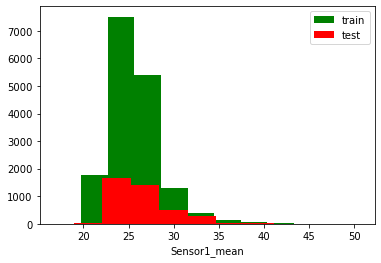

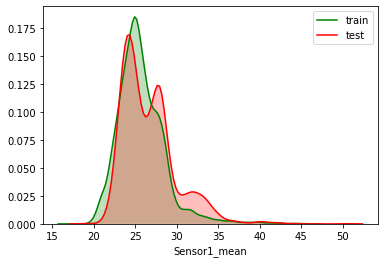

Sensor1_mean


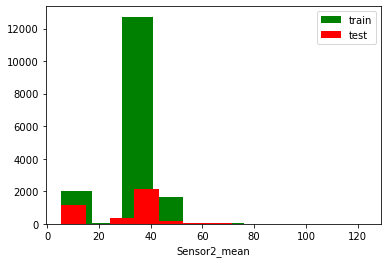

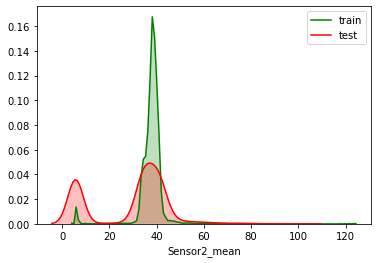

Sensor2_mean


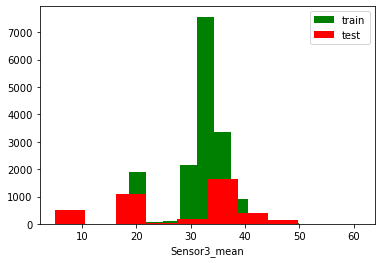

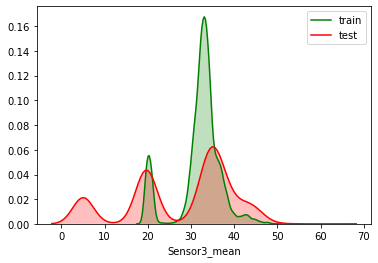

Sensor3_mean


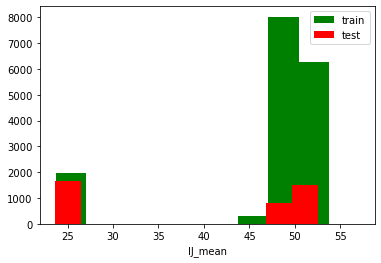

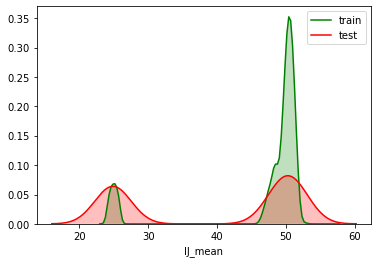

IJ_mean


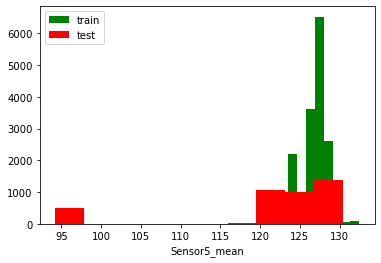

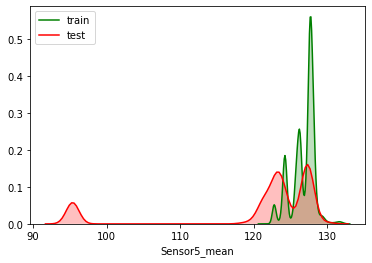

Sensor5_mean


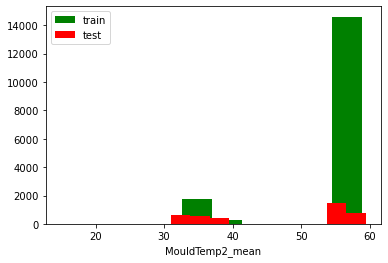

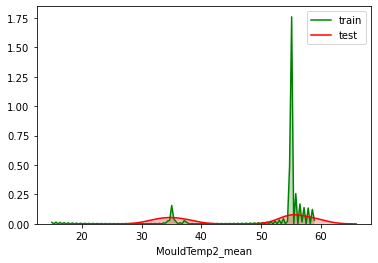

MouldTemp2_mean


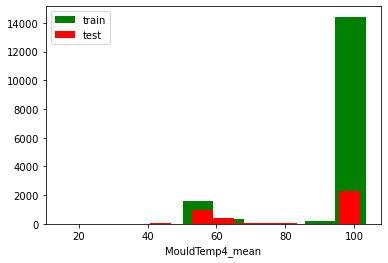

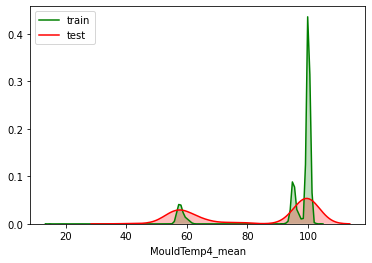

MouldTemp4_mean


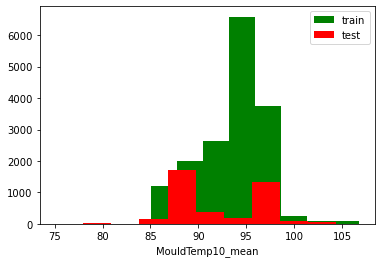

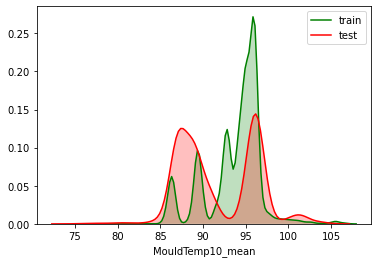

MouldTemp10_mean


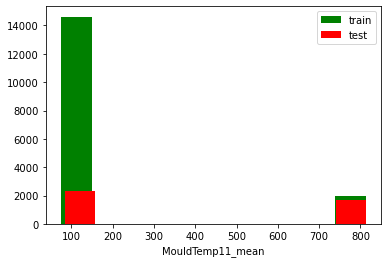

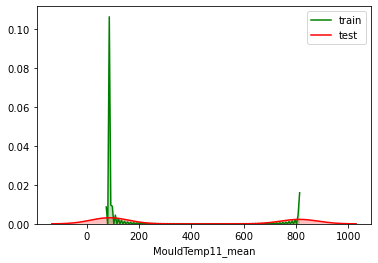

MouldTemp11_mean


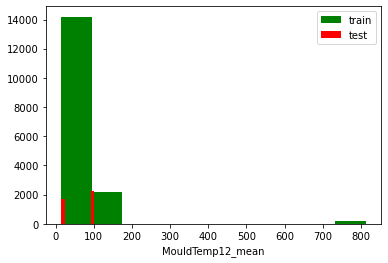

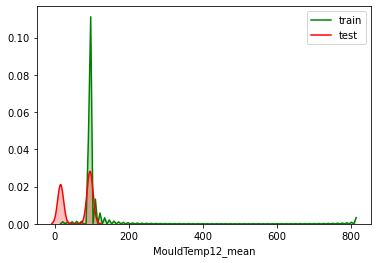

MouldTemp12_mean


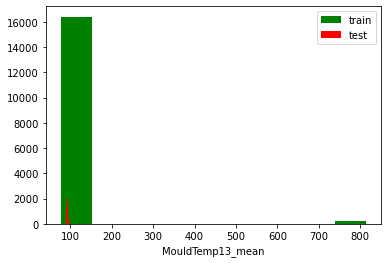

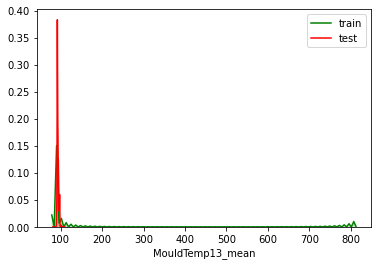

MouldTemp13_mean


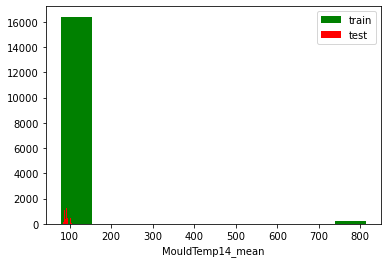

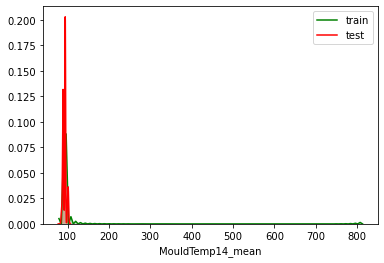

MouldTemp14_mean


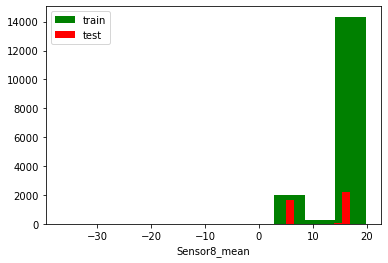

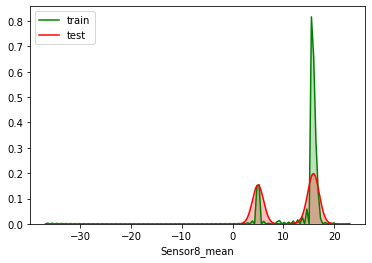

Sensor8_mean


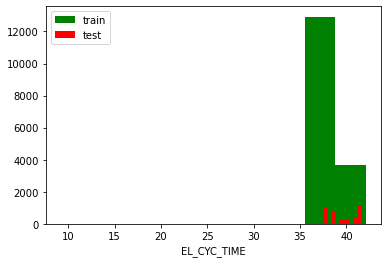

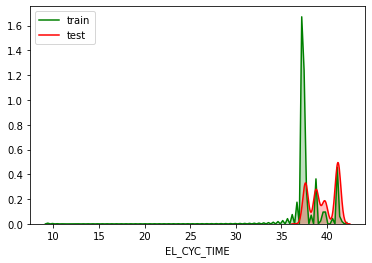

EL_CYC_TIME


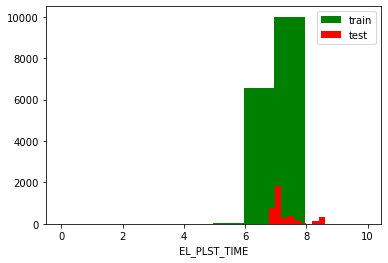

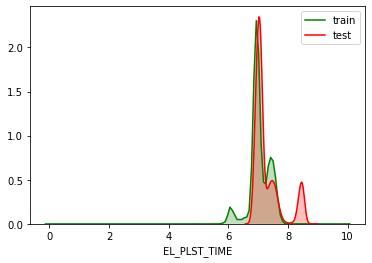

EL_PLST_TIME


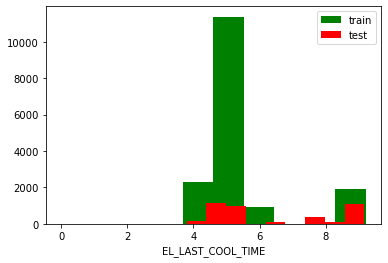

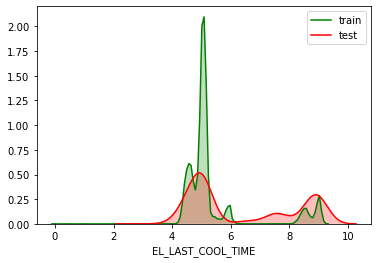

EL_LAST_COOL_TIME


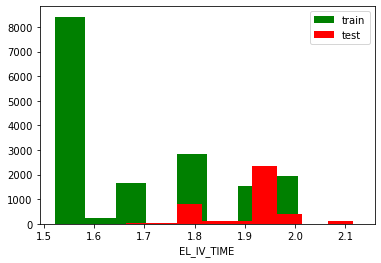

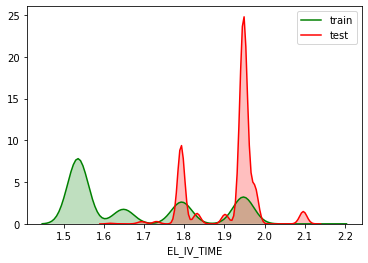

EL_IV_TIME


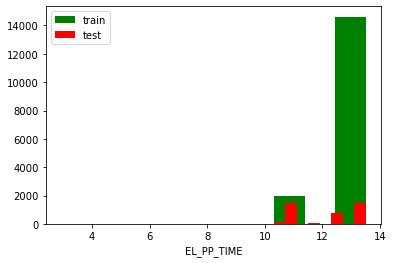

/home/adt/anaconda3/envs/autokeras/lib/python3.7/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


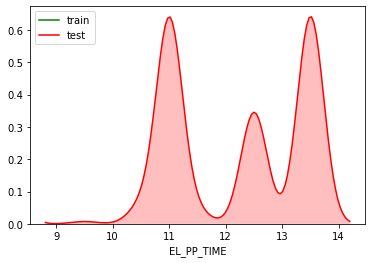

EL_PP_TIME


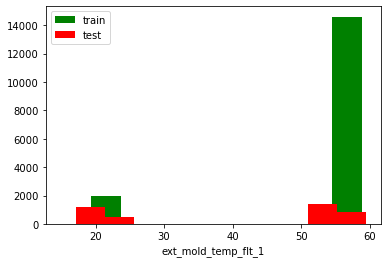

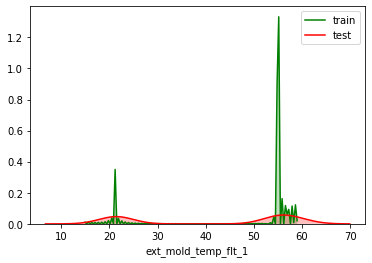

ext_mold_temp_flt_1


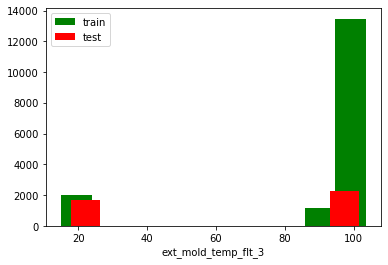

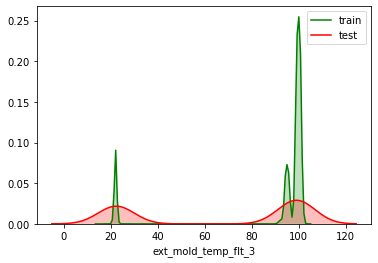

ext_mold_temp_flt_3


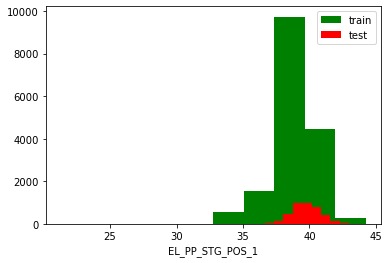

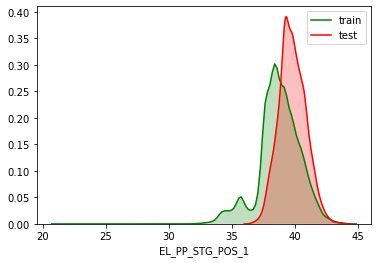

EL_PP_STG_POS_1


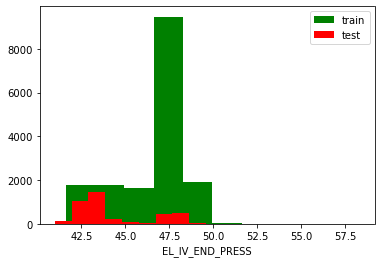

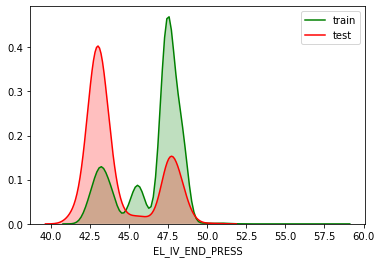

EL_IV_END_PRESS


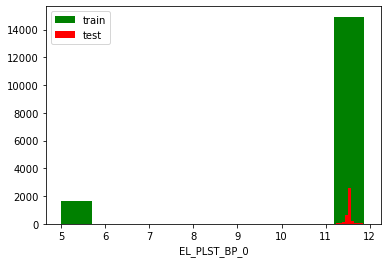

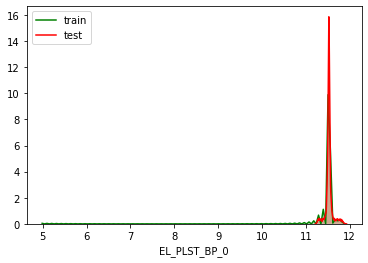

EL_PLST_BP_0


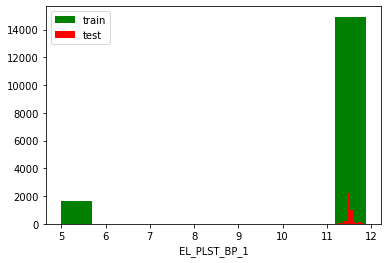

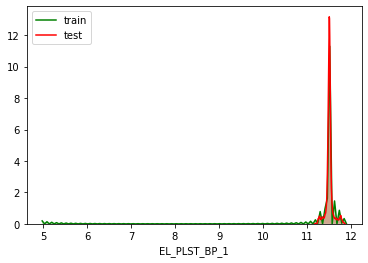

EL_PLST_BP_1


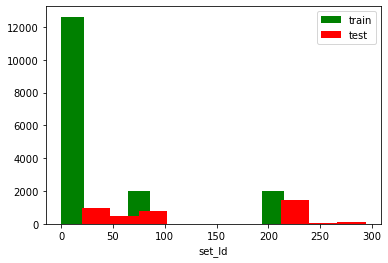

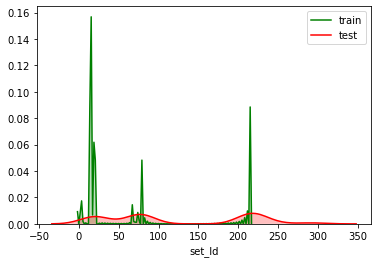

set_Id


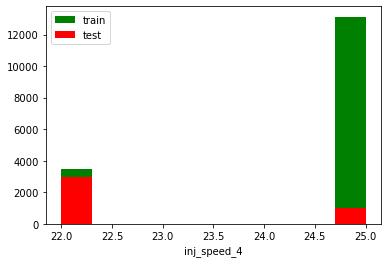

/home/adt/anaconda3/envs/autokeras/lib/python3.7/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
/home/adt/anaconda3/envs/autokeras/lib/python3.7/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


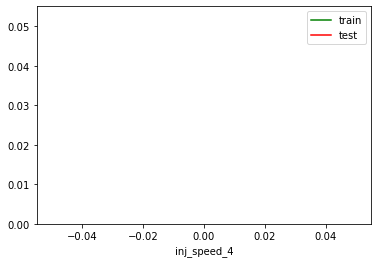

inj_speed_4


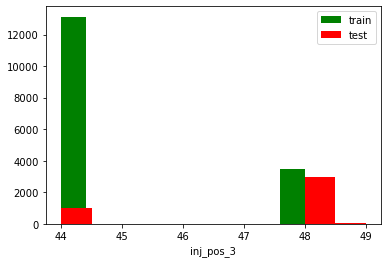

/home/adt/anaconda3/envs/autokeras/lib/python3.7/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
/home/adt/anaconda3/envs/autokeras/lib/python3.7/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


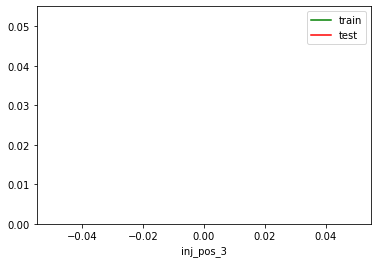

inj_pos_3


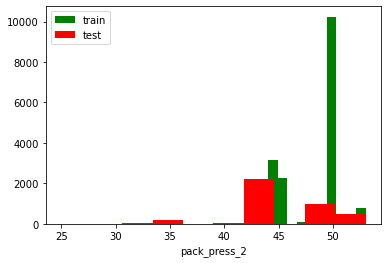

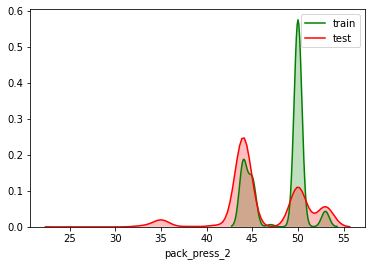

pack_press_2


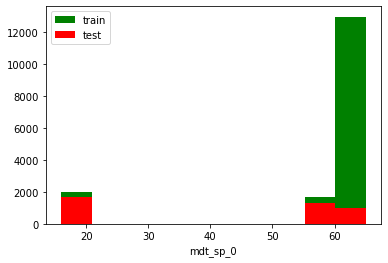

/home/adt/anaconda3/envs/autokeras/lib/python3.7/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


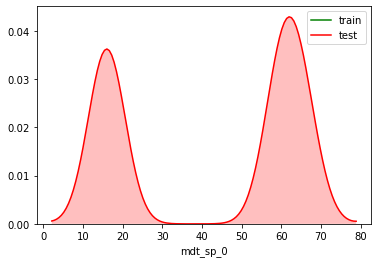

mdt_sp_0


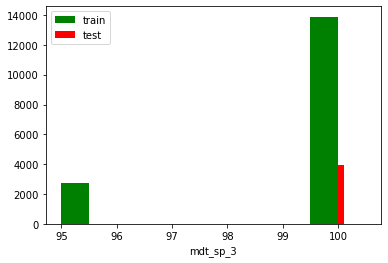

/home/adt/anaconda3/envs/autokeras/lib/python3.7/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
/home/adt/anaconda3/envs/autokeras/lib/python3.7/site-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


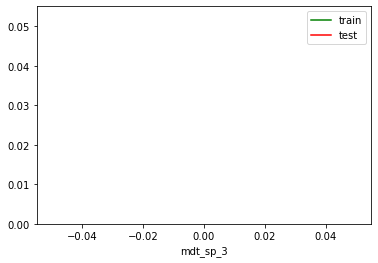

mdt_sp_3


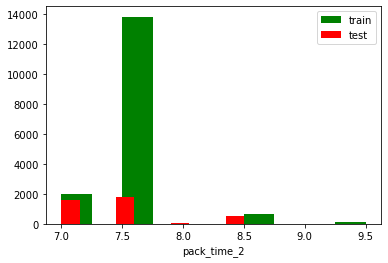

/home/adt/anaconda3/envs/autokeras/lib/python3.7/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


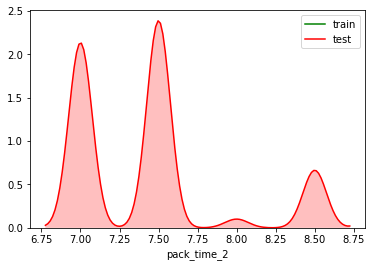

pack_time_2


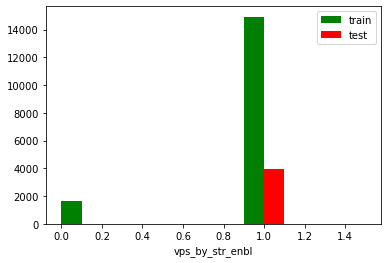

/home/adt/anaconda3/envs/autokeras/lib/python3.7/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
/home/adt/anaconda3/envs/autokeras/lib/python3.7/site-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


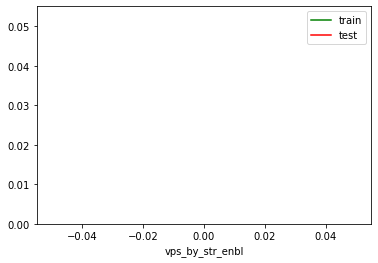

vps_by_str_enbl


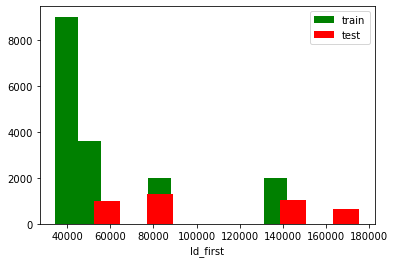

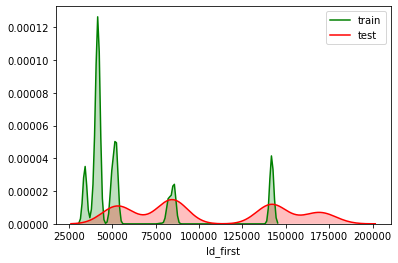

Id_first


In [18]:

# 重要！！！观察筛选的特征，在train和test上的分布差异，并删除分布差异大的特征
for column in base_corr_col:

    plt.hist(df_x_train[column], color='g')
    plt.hist(df_x_test[column], color='r')
    plt.xlabel(column)
    plt.legend(['train', 'test'])
    plt.show()
    
    sns.kdeplot(df_x_train[column], shade=True, color='g')
    sns.kdeplot(df_x_test[column], shade=True, color='r')
    plt.xlabel(column)
    plt.legend(['train', 'test'])
    plt.show()
    print(column)

In [19]:
# 将train和test分布差异较大的特征整理 
base_corr_drop = ['Sensor3_mean', 'Sensor5_mean', 'Sensor5_mean', 'MouldTemp12_mean', 
                 'EL_PLST_TIME', 'EL_LAST_COOL_TIME', 'EL_IV_TIME', 'ext_mold_temp_flt_1',
                 'inj_pos_3', 'pack_press_2', 'mdt_sp_3', 'pack_time_2', 'vps_by_str_enbl', 'Id_first']
print(len(base_corr_drop))

# ！！！删除差异大的特征，使用该base特征，在初赛训练集分数为e5次方
base_corr_modc = list(set(base_corr_col).difference(base_corr_drop))
print(len(base_corr_modc))
base_corr_modc

14
20


['Sensor2_mean',
 'Sensor8_mean',
 'MouldTemp11_mean',
 'EL_PP_TIME',
 'MouldTemp2_mean',
 'Sensor1_mean',
 'mdt_sp_0',
 'EL_CYC_TIME',
 'EL_PLST_BP_0',
 'inj_speed_4',
 'EL_IV_END_PRESS',
 'set_Id',
 'IJ_mean',
 'EL_PP_STG_POS_1',
 'MouldTemp13_mean',
 'ext_mold_temp_flt_3',
 'EL_PLST_BP_1',
 'MouldTemp4_mean',
 'MouldTemp10_mean',
 'MouldTemp14_mean']

In [20]:
# 将train和test合并，进一步创建特征
# 之前创建的delta_Id，将Id与set中调机时刻的Id相减，表示当前Id与调机的距离
# 之前创建的Id_len，用set_Id上下两行的Id差，表示对应调机段的长度，即经历了多少模次产品
# 创建特征Id_diff_ratio，使用delta_Id和Id_len之比，表示当前模次的Id处在对应调机段的比率
DATA_CUT = pd.concat([df_x_train, df_x_test], axis=0)
DATA_CUT['Id_diff_ratio'] = DATA_CUT['delta_Id'] / DATA_CUT['Id_len']
DATA_CUT = DATA_CUT.merge(df_y_train, on='Id', how='left')
DATA_CUT

Sensor1_mean  Sensor2_mean  Sensor3_mean    IJ_mean  Sensor5_mean  \
0         22.163042     32.812251     31.349038  46.848771    126.786182   
1         22.435310     34.233380     33.308759  47.759700    125.442534   
2         19.887190     33.207999     32.743573  46.747051    125.179832   
3         20.666965     33.001113     31.092858  47.146172    125.208353   
4         20.149250     32.124987     26.991250  46.600277    125.296491   
...             ...           ...           ...        ...           ...   
20566     26.796366     34.193795      5.004204  25.292029     94.979268   
20567     27.347351     31.667684      5.006933  25.266799     95.616064   
20568     27.257486     32.626498      5.003470  25.396320     94.948391   
20569     26.282240     31.752183      5.002262  24.864324     95.006518   
20570     24.975001     31.030794      5.046800  24.884862     95.386085   

       Sensor6_mean  MouldTemp1_mean  MouldTemp2_mean  MouldTemp3_mean  \
0        128.922971        65.020743        54.700000        30.683803   
1        128.114915        65.016965        55.800000        30.354609   
2        127.701786        65.126615        55.587908        31.078375   
3        127.909088        64.983355        55.590525        30.393214   
4        127.851063        64.993150        55.593598        29.561268   
...             ...              ...              ...              ...   
20566     95.436762        86.917890        38.146221        78.088106   
20567     95.725153        85.797155        38.209034        76.658611   
20568     95.554355        86.313408        38.342840        78.027273   
20569     95.456485        85.348570        37.421396        76.060123   
20570     95.572641        85.225371        37.184446        76.795194   

       MouldTemp4_mean  ...  vps_by_time_enbl  vps_by_str_enbl  \
0            95.089052  ...                 1                0   
1            95.102305  ...                 1                0   
2            95.197569  ...                 1                0   
3            94.916517  ...                 1                0   
4            94.959667  ...                 1                0   
...                ...  ...               ...              ...   
20566        78.301355  ...                 1                1   
20567        77.340333  ...                 1                1   
20568        77.990209  ...                 1                1   
20569        76.689371  ...                 1                1   
20570        76.913953  ...                 1                1   

       vps_by_prss_enbl  plst_points  Id_len  Id_first  Id_diff_ratio  \
0                     1            2  5146.0     34242      -0.101049   
1                     1            2  5146.0     34242       0.109017   
2                     1            2  5146.0     34242       0.462301   
3                     1            2  5146.0     34242       0.462495   
4                     1            2  5146.0     34242       0.462689   
...                 ...          ...     ...       ...            ...   
20566                 1            2   602.0    175534       0.676080   
20567                 1            2   602.0    175534       0.700997   
20568                 1            2   602.0    175534       0.725914   
20569                 1            2   602.0    175534       0.975083   
20570                 1            2   602.0    175534       1.000000   

         size1    size2    size3  
0      299.998  199.995  199.967  
1      299.999  199.938  199.956  
2      299.958  199.916  199.947  
3      299.974  199.930  199.961  
4      299.959  199.915  199.949  
...        ...      ...      ...  
20566      NaN      NaN      NaN  
20567      NaN      NaN      NaN  
20568      NaN      NaN      NaN  
20569      NaN      NaN      NaN  
20570      NaN      NaN      NaN  

[20571 rows x 181 columns]

In [21]:
# 将相同调机段的size中位数作目标表面，作为特征
mean_columns = []

for col in ['size1', 'size2', 'size3']:

    col_name = col+'_'+'set_Id'+'_median'
    mean_columns.append(col_name)
    # 将相同调机段的size中位数取出，并map，缺省值不填充
    order_label = DATA_CUT.groupby(['set_Id'])[col].median()
    DATA_CUT[col_name] = DATA_CUT['set_Id'].map(order_label)
    
for col in ['size1','size2','size3']:
    del DATA_CUT[col]
    
DATA_CUT

Sensor1_mean  Sensor2_mean  Sensor3_mean    IJ_mean  Sensor5_mean  \
0         22.163042     32.812251     31.349038  46.848771    126.786182   
1         22.435310     34.233380     33.308759  47.759700    125.442534   
2         19.887190     33.207999     32.743573  46.747051    125.179832   
3         20.666965     33.001113     31.092858  47.146172    125.208353   
4         20.149250     32.124987     26.991250  46.600277    125.296491   
...             ...           ...           ...        ...           ...   
20566     26.796366     34.193795      5.004204  25.292029     94.979268   
20567     27.347351     31.667684      5.006933  25.266799     95.616064   
20568     27.257486     32.626498      5.003470  25.396320     94.948391   
20569     26.282240     31.752183      5.002262  24.864324     95.006518   
20570     24.975001     31.030794      5.046800  24.884862     95.386085   

       Sensor6_mean  MouldTemp1_mean  MouldTemp2_mean  MouldTemp3_mean  \
0        128.922971        65.020743        54.700000        30.683803   
1        128.114915        65.016965        55.800000        30.354609   
2        127.701786        65.126615        55.587908        31.078375   
3        127.909088        64.983355        55.590525        30.393214   
4        127.851063        64.993150        55.593598        29.561268   
...             ...              ...              ...              ...   
20566     95.436762        86.917890        38.146221        78.088106   
20567     95.725153        85.797155        38.209034        76.658611   
20568     95.554355        86.313408        38.342840        78.027273   
20569     95.456485        85.348570        37.421396        76.060123   
20570     95.572641        85.225371        37.184446        76.795194   

       MouldTemp4_mean  ...  vps_by_time_enbl  vps_by_str_enbl  \
0            95.089052  ...                 1                0   
1            95.102305  ...                 1                0   
2            95.197569  ...                 1                0   
3            94.916517  ...                 1                0   
4            94.959667  ...                 1                0   
...                ...  ...               ...              ...   
20566        78.301355  ...                 1                1   
20567        77.340333  ...                 1                1   
20568        77.990209  ...                 1                1   
20569        76.689371  ...                 1                1   
20570        76.913953  ...                 1                1   

       vps_by_prss_enbl  plst_points  Id_len  Id_first  Id_diff_ratio  \
0                     1            2  5146.0     34242      -0.101049   
1                     1            2  5146.0     34242       0.109017   
2                     1            2  5146.0     34242       0.462301   
3                     1            2  5146.0     34242       0.462495   
4                     1            2  5146.0     34242       0.462689   
...                 ...          ...     ...       ...            ...   
20566                 1            2   602.0    175534       0.676080   
20567                 1            2   602.0    175534       0.700997   
20568                 1            2   602.0    175534       0.725914   
20569                 1            2   602.0    175534       0.975083   
20570                 1            2   602.0    175534       1.000000   

       size1_set_Id_median  size2_set_Id_median  size3_set_Id_median  
0                  300.028              199.973              199.987  
1                  300.028              199.973              199.987  
2                  300.028              199.973              199.987  
3                  300.028              199.973              199.987  
4                  300.028              199.973              199.987  
...                    ...                  ...                  ...  
20566                  NaN            

In [22]:
# 将训练集和决赛测试集分开
data_train = DATA_CUT[:len(df_x_train)]
data_test = DATA_CUT[len(df_x_train):]
print(data_train.shape)
print(data_test.shape)
data_train

(16600, 181)
(3971, 181)


Sensor1_mean  Sensor2_mean  Sensor3_mean    IJ_mean  Sensor5_mean  \
0         22.163042     32.812251     31.349038  46.848771    126.786182   
1         22.435310     34.233380     33.308759  47.759700    125.442534   
2         19.887190     33.207999     32.743573  46.747051    125.179832   
3         20.666965     33.001113     31.092858  47.146172    125.208353   
4         20.149250     32.124987     26.991250  46.600277    125.296491   
...             ...           ...           ...        ...           ...   
16595     27.477336      5.450004     21.435028  25.913127    124.223685   
16596     27.630046      5.724087     21.339379  25.915726    124.084781   
16597     27.412219      5.700744     21.572931  25.796676    124.001156   
16598     27.176479      5.855807     21.162323  25.769928    123.965279   
16599     27.360563      5.884062     21.497686  25.791231    124.012643   

       Sensor6_mean  MouldTemp1_mean  MouldTemp2_mean  MouldTemp3_mean  \
0        128.922971        65.020743        54.700000        30.683803   
1        128.114915        65.016965        55.800000        30.354609   
2        127.701786        65.126615        55.587908        31.078375   
3        127.909088        64.983355        55.590525        30.393214   
4        127.851063        64.993150        55.593598        29.561268   
...             ...              ...              ...              ...   
16595     95.010113        82.494656        38.000000        64.546974   
16596     95.178324        84.505853        37.849650        66.062249   
16597     94.790900        80.213194        38.000000        63.847269   
16598     95.176740        82.776222        38.000000        64.527661   
16599     95.044563        84.404971        37.800000        66.176295   

       MouldTemp4_mean  ...  vps_by_time_enbl  vps_by_str_enbl  \
0            95.089052  ...                 1                0   
1            95.102305  ...                 1                0   
2            95.197569  ...                 1                0   
3            94.916517  ...                 1                0   
4            94.959667  ...                 1                0   
...                ...  ...               ...              ...   
16595        60.594415  ...                 1                1   
16596        61.452176  ...                 1                1   
16597        60.381103  ...                 1                1   
16598        60.608097  ...                 1                1   
16599        61.503402  ...                 1                1   

       vps_by_prss_enbl  plst_points   Id_len  Id_first  Id_diff_ratio  \
0                     1            2   5146.0     34242      -0.101049   
1                     1            2   5146.0     34242       0.109017   
2                     1            2   5146.0     34242       0.462301   
3                     1            2   5146.0     34242       0.462495   
4                     1            2   5146.0     34242       0.462689   
...                 ...          ...      ...       ...            ...   
16595                 1            2  23865.0    141857       0.370375   
16596                 1            2  23865.0    141857       0.370585   
16597                 1            2  23865.0    141857       0.370794   
16598                 1            2  23865.0    141857       0.371004   
16599                 1            2  23865.0    141857       0.371213   

       size1_set_Id_median  size2_set_Id_median  size3_set_Id_median  
0                  300.028              199.973              199.987  
1                  300.028              199.973              199.987  
2                  300.028              199.973              199.987  
3                  300.028              199.973              199.987  
4                  300.028              199.973              199.987  
...                    ...                  ...                  ...  
16595              300.060

In [23]:
data_test

Sensor1_mean  Sensor2_mean  Sensor3_mean    IJ_mean  Sensor5_mean  \
16600     27.007252     38.781916     34.801564  50.105871    127.362978   
16601     26.515876     38.688036     33.523717  49.789262    127.247639   
16602     25.805459     38.428907     37.678693  50.187201    127.329526   
16603     27.395220     38.810916     35.235566  50.435031    127.430017   
16604     26.817505     39.598341     36.293718  50.147547    127.435603   
...             ...           ...           ...        ...           ...   
20566     26.796366     34.193795      5.004204  25.292029     94.979268   
20567     27.347351     31.667684      5.006933  25.266799     95.616064   
20568     27.257486     32.626498      5.003470  25.396320     94.948391   
20569     26.282240     31.752183      5.002262  24.864324     95.006518   
20570     24.975001     31.030794      5.046800  24.884862     95.386085   

       Sensor6_mean  MouldTemp1_mean  MouldTemp2_mean  MouldTemp3_mean  \
16600    130.711855        65.035111        54.988381        31.033524   
16601    130.936963        65.018476        55.003746        30.549714   
16602    130.657537        64.940381        54.976254        30.551873   
16603    130.700253        64.940825        55.010349        29.999111   
16604    130.927906        65.048635        55.016762        31.033206   
...             ...              ...              ...              ...   
20566     95.436762        86.917890        38.146221        78.088106   
20567     95.725153        85.797155        38.209034        76.658611   
20568     95.554355        86.313408        38.342840        78.027273   
20569     95.456485        85.348570        37.421396        76.060123   
20570     95.572641        85.225371        37.184446        76.795194   

       MouldTemp4_mean  ...  vps_by_time_enbl  vps_by_str_enbl  \
16600        99.940635  ...                 1                1   
16601       100.254159  ...                 1                1   
16602       100.288190  ...                 1                1   
16603       100.067048  ...                 1                1   
16604        99.923683  ...                 1                1   
...                ...  ...               ...              ...   
20566        78.301355  ...                 1                1   
20567        77.340333  ...                 1                1   
20568        77.990209  ...                 1                1   
20569        76.689371  ...                 1                1   
20570        76.913953  ...                 1                1   

       vps_by_prss_enbl  plst_points  Id_len  Id_first  Id_diff_ratio  \
16600                 1            2  6866.0     52178       0.657734   
16601                 1            2  6866.0     52178       0.658462   
16602                 1            2  6866.0     52178       0.659336   
16603                 1            2  6866.0     52178       0.659773   
16604                 1            2  6866.0     52178       0.660355   
...                 ...          ...     ...       ...            ...   
20566                 1            2   602.0    175534       0.676080   
20567                 1            2   602.0    175534       0.700997   
20568                 1            2   602.0    175534       0.725914   
20569                 1            2   602.0    175534       0.975083   
20570                 1            2   602.0    175534       1.000000   

       size1_set_Id_median  size2_set_Id_median  size3_set_Id_median  
16600              300.084              199.959              200.005  
16601              300.084              199.959              200.005  
16602              300.084              199.959              200.005  
16603              300.084              199.959              200.005  
16604              300.084              199.959              200.005  
...                    ...                  ...                  ...  
20566                  NaN            

In [24]:

# 定义五折交叉
K = 5
seed = 1234
skf = KFold(n_splits=K, shuffle=True, random_state=seed)


In [25]:
# 定义画图函数，将本地验证集的预测值和实际值放入，绘制误差线图，查看分布情况
def plt_error(y_pred, y_test, column):
    #绘制size绝对值的误差图
    plt.figure(figsize=(16,9))
    plt.errorbar(np.arange(len(y_pred)), y_pred, yerr = 0.005)
    plt.errorbar(np.arange(len(y_test)), y_test, yerr = 0.005)
    plt.xlabel('Serial No.')
    plt.ylabel(column)
    plt.show()
    #绘制size相对误差的散点图
    plt.figure(figsize=(16,9))
    plt.scatter(np.arange(len(y_test)), (y_pred-np.array(y_test)))
    plt.xlabel('Serial No.')
    plt.ylabel(column+' error')
    plt.show()

In [26]:

#定义尺寸预测函数，其中df_lgb_train_pred和df_lgb_sub_pred分别存放模型对整体训练集和测试集的结果，方便后面做其他操作

def pred_size(size_i, X_train, y_train, X_test, df_lgb_train_pred, df_lgb_sub_pred):
    
    predictions = np.zeros(len(X_test))
    
    for i, (train_index, val_index) in enumerate(skf.split(X_train,y_train)):
        print("fold {}".format(i))
        X_tr, X_val = X_train.iloc[train_index], X_train.iloc[val_index]
        y_tr, y_val = y_train.iloc[train_index], y_train.iloc[val_index]
        lgb_train = lgb.Dataset(X_tr,y_tr)
        lgb_val = lgb.Dataset(X_val,y_val)
        num_round = 2000
        clf = lgb.train(lgb_params, lgb_train, num_round, valid_sets = [lgb_train, lgb_val],verbose_eval=50, 
                        early_stopping_rounds = 50)
        print('best iteration = ',clf.best_iteration)
        print("*"*100)
        predictions += clf.predict(X_test, num_iteration=clf.best_iteration) / skf.n_splits
        
        y_val_pred = clf.predict(X_val, num_iteration=clf.best_iteration)
        df_lgb_train_pred[size_i] += clf.predict(np.array(X_train), num_iteration = clf.best_iteration)
        df_lgb_sub_pred[size_i] += clf.predict(np.array(X_test), num_iteration = clf.best_iteration)
        
        lgb1_score = mean_squared_error(y_val, y_val_pred)
        plt_error(y_val, y_val_pred, size_i)
        print('LGB1均方差得分为：', lgb1_score)
        print("*"*100)       
    
    df_lgb_train_pred[size_i] = df_lgb_train_pred[size_i] / K
    print(df_lgb_train_pred)
    df_lgb_sub_pred[size_i] = df_lgb_sub_pred[size_i] / K
    print(df_lgb_sub_pred)
    
    return predictions



In [27]:
# 定义lgb参数
lgb_params = {
                        'boosting_type': 'gbdt',
                        'objective': 'regression',
                        'num_leaves': 2**4-1,
                        'subsample': 0.9,
                        'learning_rate': 0.05,
                        'seed': 2020,
                        'nthread': -1
             }
# df_lgb_train_pred和df_lgb_sub_pred分别存放模型对整体训练集和测试集的结果，方便后面做其他操作
n_train = np.zeros((len(df_x_train), 3))
df_lgb_train_pred = pd.DataFrame(n_train, columns=['size1','size2','size3'])

n_sub = np.zeros((len(df_x_test), 3))
df_lgb_sub_pred = pd.DataFrame(n_sub, columns=['size1','size2','size3'])

# 对三个尺寸，采用不同特征，均为base的20个特征，再加上其他创建特征，此特征初赛测试集得分4e4左右
size_dic = {
    'size1': base_corr_modc+['size1_set_Id_median'],
    'size2': base_corr_modc+['Id_len','Id_diff_ratio'],
    'size3': base_corr_modc+['size3_set_Id_median']
}



(3971, 21)
fold 0
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002795 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3991
[LightGBM] [Info] Number of data points in the train set: 13280, number of used features: 21
[LightGBM] [Info] Start training from score 300.065686
Training until validation scores don't improve for 50 rounds
[50]	training's l2: 0.000444014	valid_1's l2: 0.00046475
[100]	training's l2: 0.000396993	valid_1's l2: 0.000431644
[150]	training's l2: 0.000378175	valid_1's l2: 0.000426171
[200]	training's l2: 0.000361765	valid_1's l2: 0.000423329
[250]	training's l2: 0.000347729	valid_1's l2: 0.000421247
[300]	training's l2: 0.00033532	valid_1's l2: 0.000419785
[350]	training's l2: 0.000323127	valid_1's l2: 0.000418848
[400]	training's l2: 0.000312767	valid_1's l2: 0.000418105
[450]	training's l2: 0.000303224	valid_1's l2: 0.000418116
Early stopping, best iteration is:
[414]	train

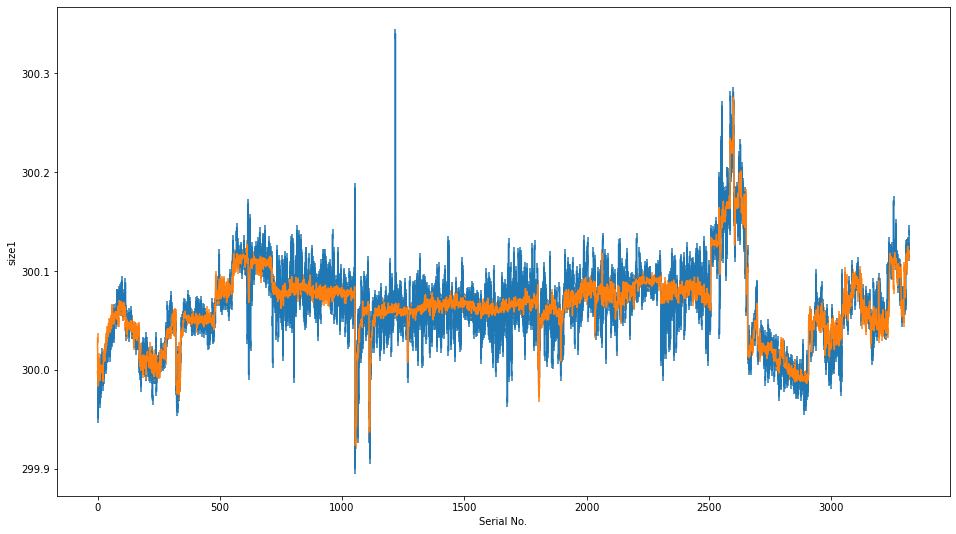

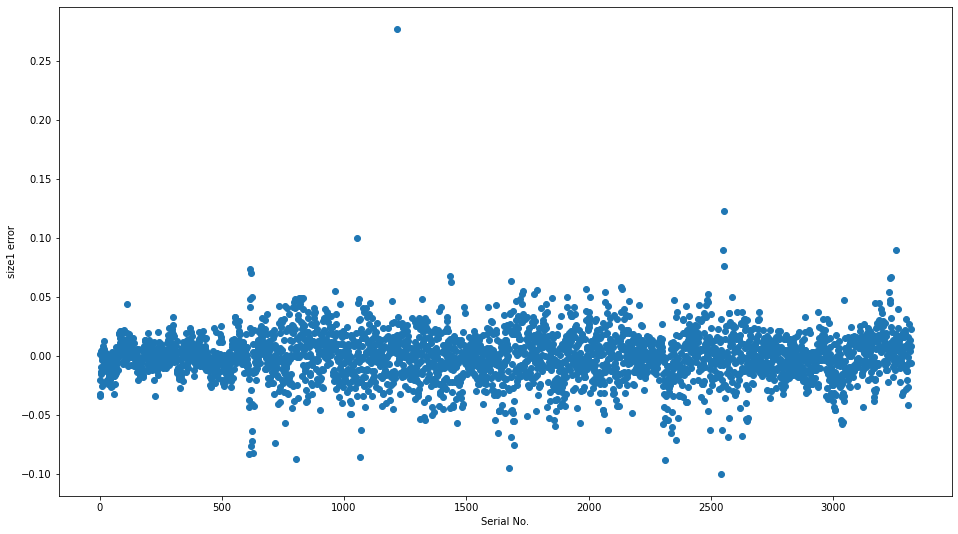

LGB1均方差得分为： 0.00041777913695686004
****************************************************************************************************
fold 1
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002839 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3993
[LightGBM] [Info] Number of data points in the train set: 13280, number of used features: 21
[LightGBM] [Info] Start training from score 300.065632
Training until validation scores don't improve for 50 rounds
[50]	training's l2: 0.000457183	valid_1's l2: 0.000425359
[100]	training's l2: 0.000410545	valid_1's l2: 0.00038603
[150]	training's l2: 0.000390759	valid_1's l2: 0.000377741
[200]	training's l2: 0.000374712	valid_1's l2: 0.000372693
[250]	training's l2: 0.000360317	valid_1's l2: 0.000369447
[300]	training's l2: 0.00034728	valid_1's l2: 0.00036858
[350]	training's l2: 0.000334999	va

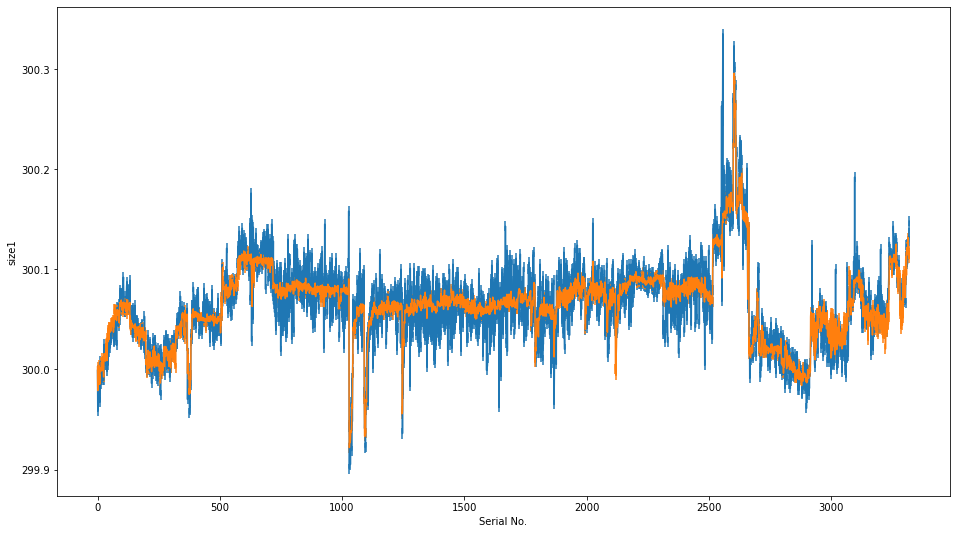

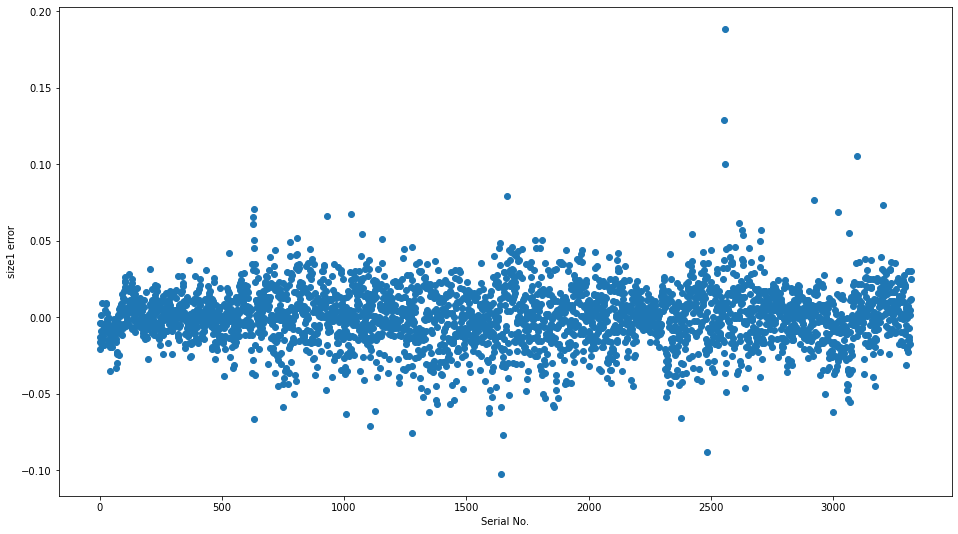

LGB1均方差得分为： 0.00036614689806029527
****************************************************************************************************
fold 2
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003263 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3990
[LightGBM] [Info] Number of data points in the train set: 13280, number of used features: 21
[LightGBM] [Info] Start training from score 300.065281
Training until validation scores don't improve for 50 rounds
[50]	training's l2: 0.000428646	valid_1's l2: 0.00053504
[100]	training's l2: 0.000380835	valid_1's l2: 0.000503875
[150]	training's l2: 0.000361821	valid_1's l2: 0.000500229
[200]	training's l2: 0.00034644	valid_1's l2: 0.000498188
[250]	training's l2: 0.00033294	valid_1's l2: 0.000496496
[300]	training's l2: 0.000320629	valid_1's l2: 0.000495778
[350]	training's l2: 0.000309179	valid_1's l2: 0.000494825
Early stopping, best iteration is:
[349]

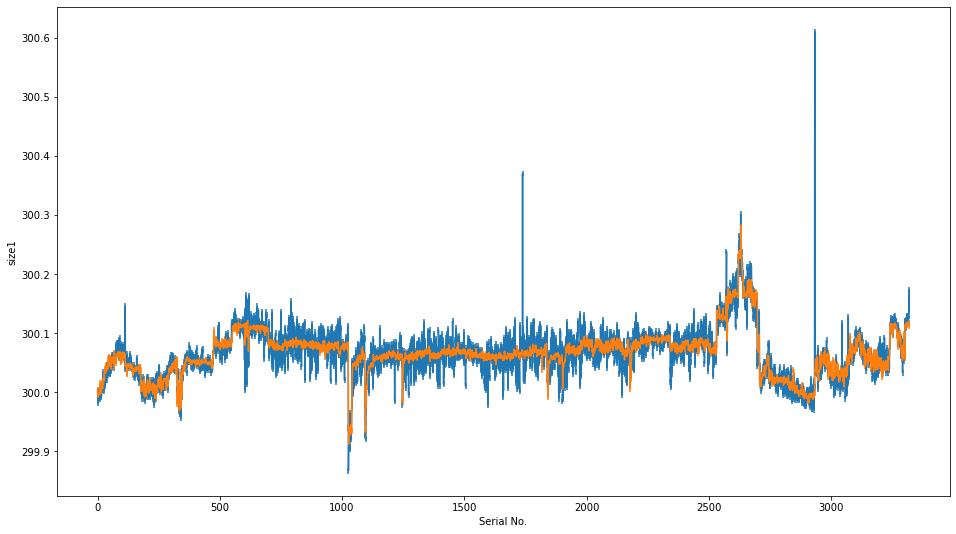

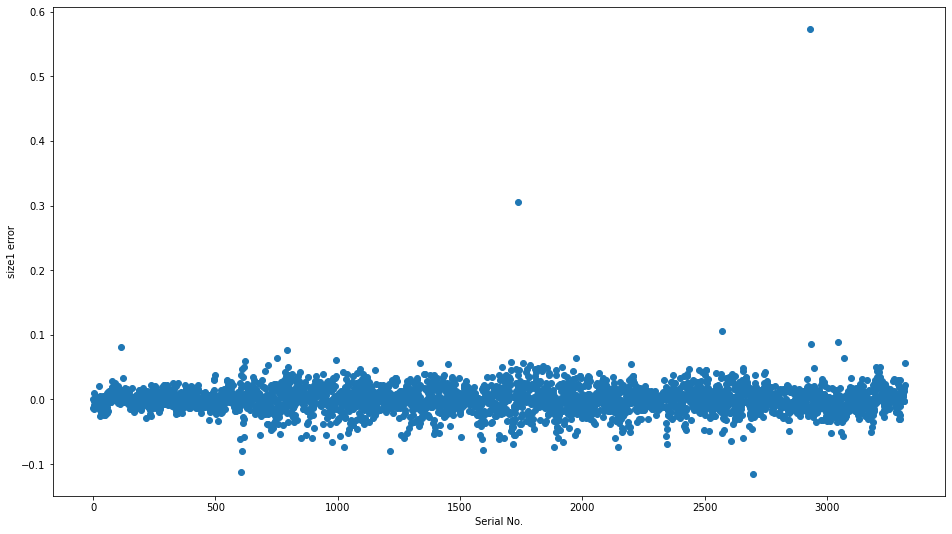

LGB1均方差得分为： 0.0004947296420897655
****************************************************************************************************
fold 3
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003226 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3990
[LightGBM] [Info] Number of data points in the train set: 13280, number of used features: 21
[LightGBM] [Info] Start training from score 300.065616
Training until validation scores don't improve for 50 rounds
[50]	training's l2: 0.000449628	valid_1's l2: 0.000442816
[100]	training's l2: 0.000401613	valid_1's l2: 0.000412033
[150]	training's l2: 0.000380594	valid_1's l2: 0.000408355
[200]	training's l2: 0.000364414	valid_1's l2: 0.000405717
[250]	training's l2: 0.000350204	valid_1's l2: 0.000404082
[300]	training's l2: 0.000337616	valid_1's l2: 0.00040339
[350]	training's l2: 0.00032582	valid_1's l2: 0.000402721
Early stopping, best iteration is:
[316]

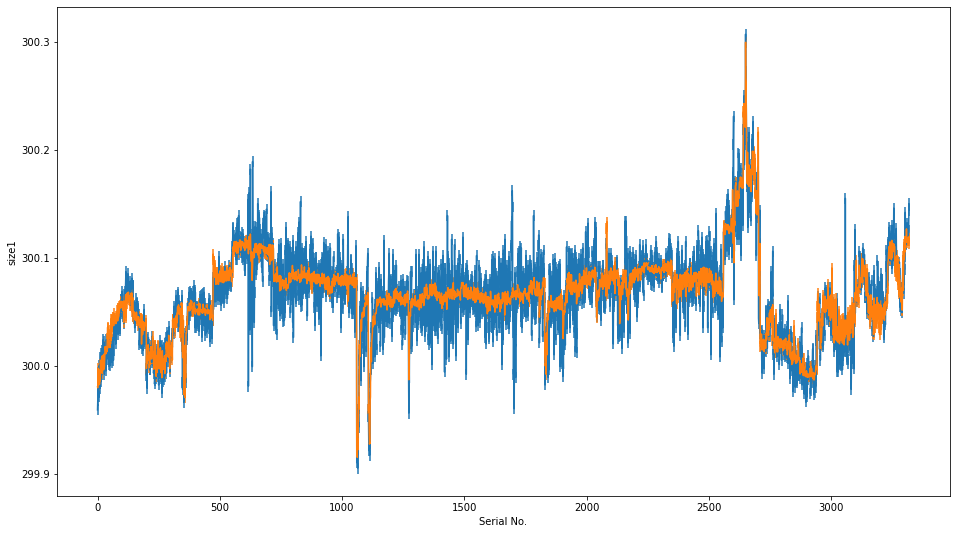

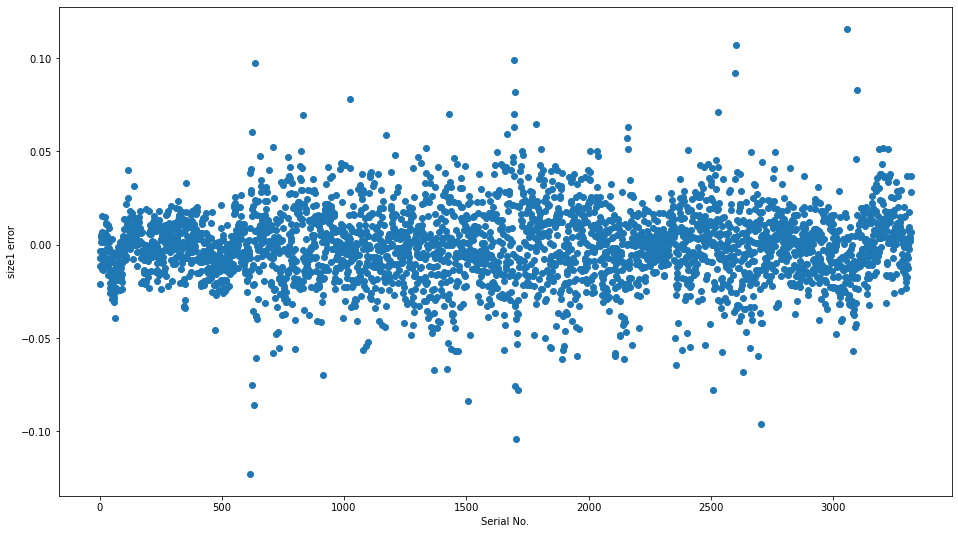

LGB1均方差得分为： 0.00040257631524927767
****************************************************************************************************
fold 4
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001960 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3990
[LightGBM] [Info] Number of data points in the train set: 13280, number of used features: 21
[LightGBM] [Info] Start training from score 300.065386
Training until validation scores don't improve for 50 rounds
[50]	training's l2: 0.00045388	valid_1's l2: 0.000434687
[100]	training's l2: 0.000405555	valid_1's l2: 0.000396876
[150]	training's l2: 0.000386093	valid_1's l2: 0.00039106
[200]	training's l2: 0.000370083	valid_1's l2: 0.000386521
[250]	training's l2: 0.000356372	valid_1's l2: 0.00038397
[300]	training's l2: 0.000343874	valid_1's l2: 0.000382487
[350]	training's l2: 0.000331322	va

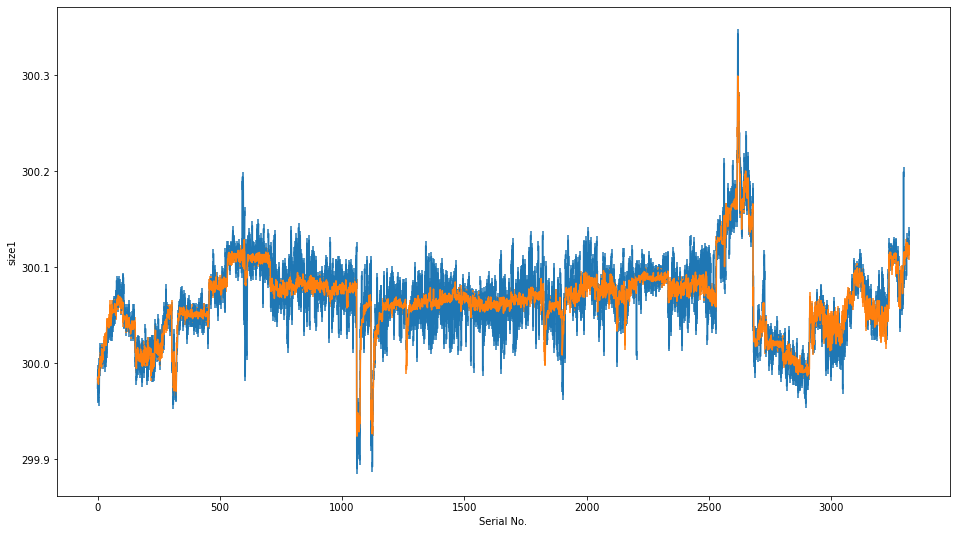

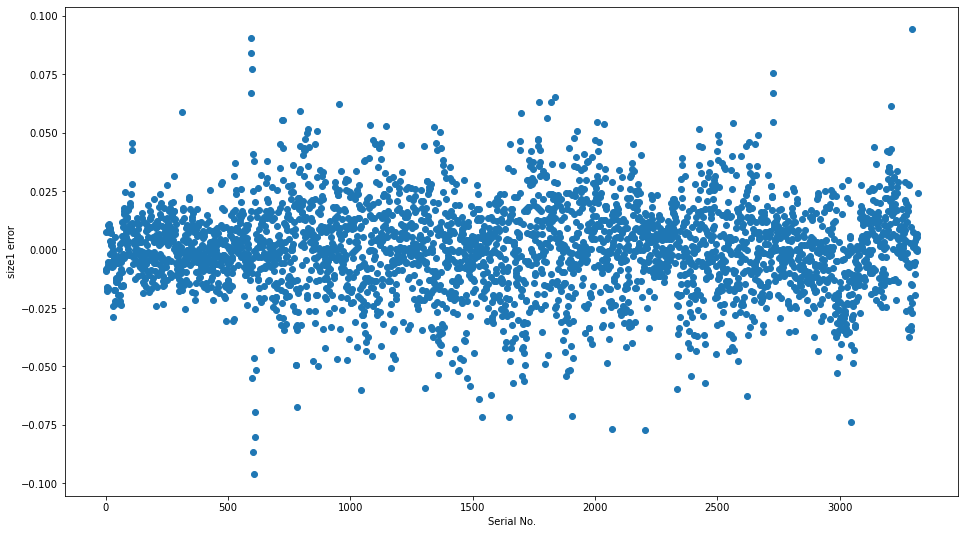

LGB1均方差得分为： 0.0003806900473547037
****************************************************************************************************
            size1  size2  size3
0      300.029559    0.0    0.0
1      300.000645    0.0    0.0
2      299.978263    0.0    0.0
3      299.985540    0.0    0.0
4      299.977800    0.0    0.0
...           ...    ...    ...
16595  300.113660    0.0    0.0
16596  300.117203    0.0    0.0
16597  300.114187    0.0    0.0
16598  300.118028    0.0    0.0
16599  300.116641    0.0    0.0

[16600 rows x 3 columns]
           size1  size2  size3
0     300.070099    0.0    0.0
1     300.067119    0.0    0.0
2     300.062579    0.0    0.0
3     300.069256    0.0    0.0
4     300.065399    0.0    0.0
...          ...    ...    ...
3966  299.950836    0.0    0.0
3967  299.949930    0.0    0.0
3968  299.951088    0.0    0.0
3969  299.953534    0.0    0.0
3970  299.951465    0.0    0.0

[3971 rows x 3 columns]
(3971, 22)
fold 0
[LightGBM] [Warning] Auto-choosing col-w

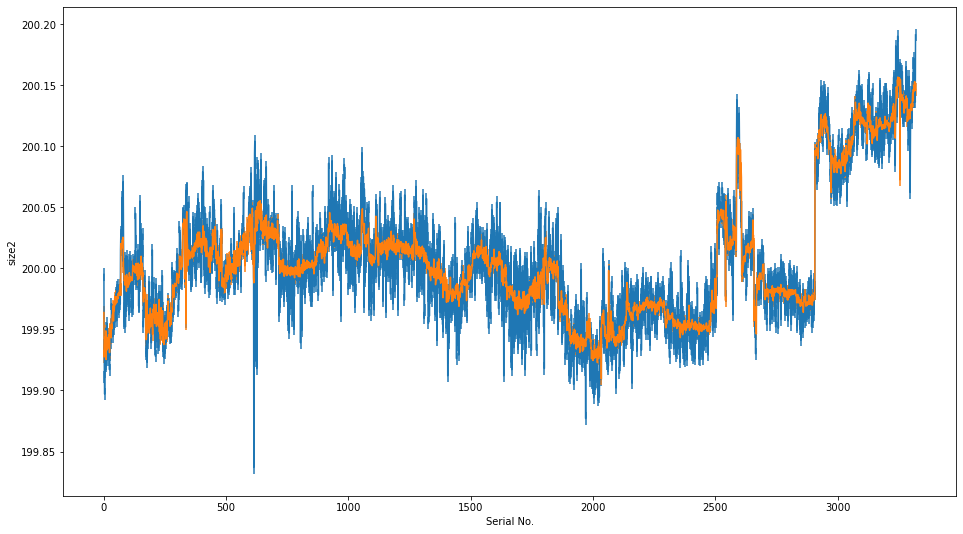

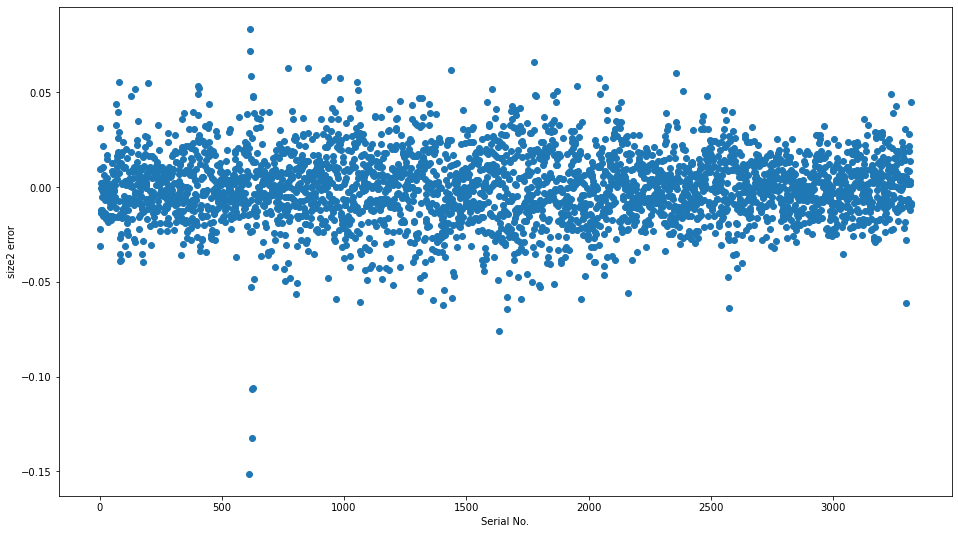

LGB1均方差得分为： 0.0003477016489832559
****************************************************************************************************
fold 1
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002971 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4249
[LightGBM] [Info] Number of data points in the train set: 13280, number of used features: 22
[LightGBM] [Info] Start training from score 200.005556
Training until validation scores don't improve for 50 rounds
[50]	training's l2: 0.000417563	valid_1's l2: 0.000402352
[100]	training's l2: 0.000355365	valid_1's l2: 0.000354022
[150]	training's l2: 0.000332436	valid_1's l2: 0.000341485
[200]	training's l2: 0.000317419	valid_1's l2: 0.000336527
[250]	training's l2: 0.000303683	valid_1's l2: 0.000333314
[300]	training's l2: 0.000291852	valid_1's l2: 0.000331694
[350]	training's l2: 0.000281211	

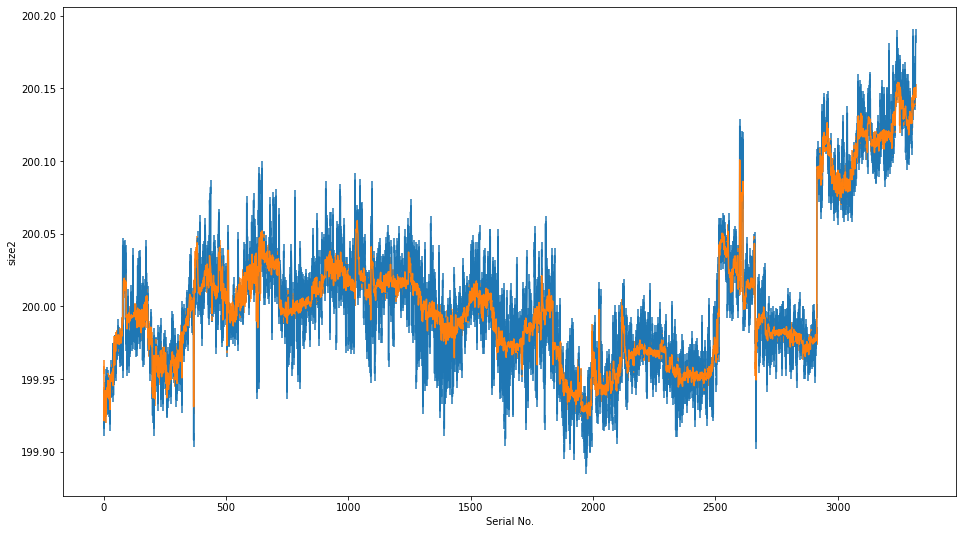

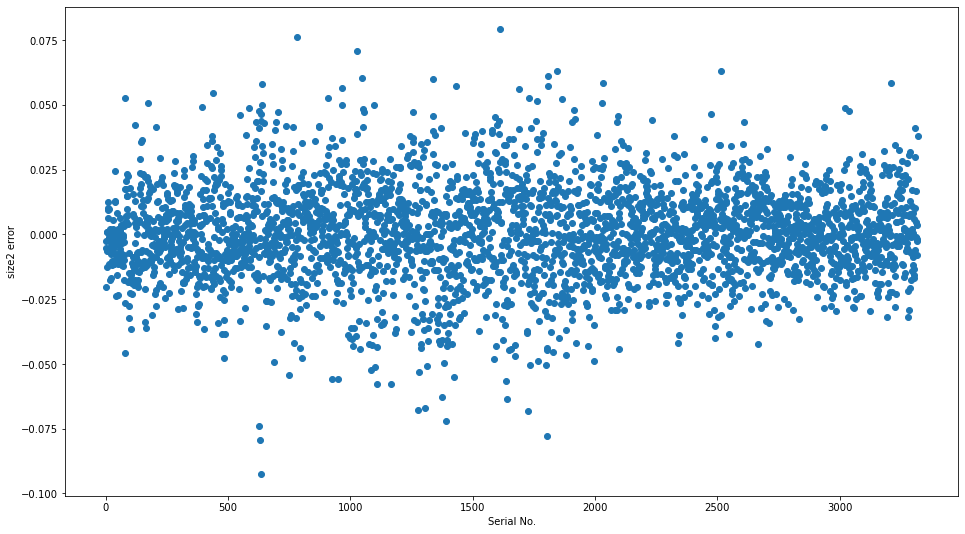

LGB1均方差得分为： 0.00032880986130407375
****************************************************************************************************
fold 2
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006600 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4246
[LightGBM] [Info] Number of data points in the train set: 13280, number of used features: 22
[LightGBM] [Info] Start training from score 200.005398
Training until validation scores don't improve for 50 rounds
[50]	training's l2: 0.00040591	valid_1's l2: 0.000446577
[100]	training's l2: 0.000343884	valid_1's l2: 0.000389127
[150]	training's l2: 0.000322548	valid_1's l2: 0.000374779
[200]	training's l2: 0.00030899	valid_1's l2: 0.000370875
[250]	training's l2: 0.000296793	valid_1's l2: 0.000368224
[300]	training's l2: 0.000286186	valid_1's l2: 0.000365963
[350]	training's l2: 0.000275798	valid_1's l2: 0.000363371
[400]	training's l2: 0.000266646	valid_

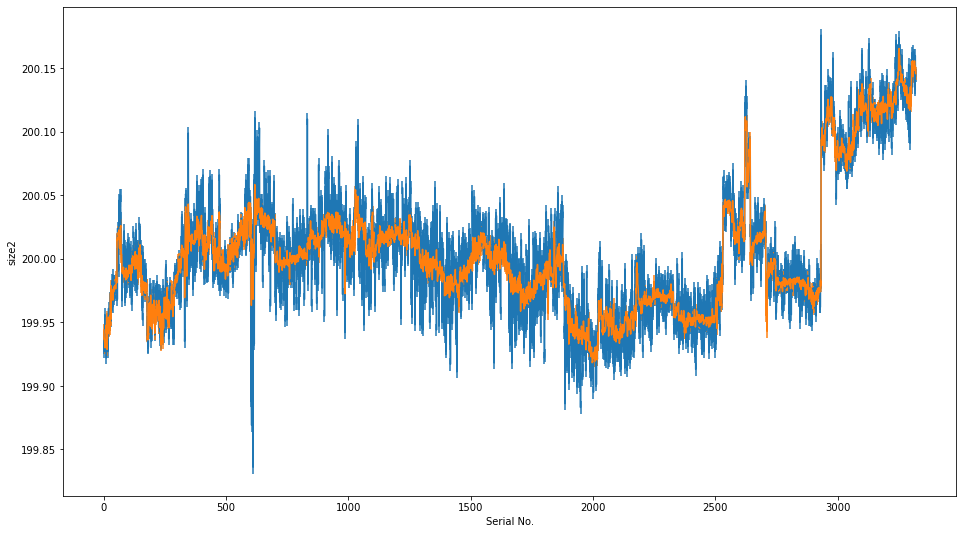

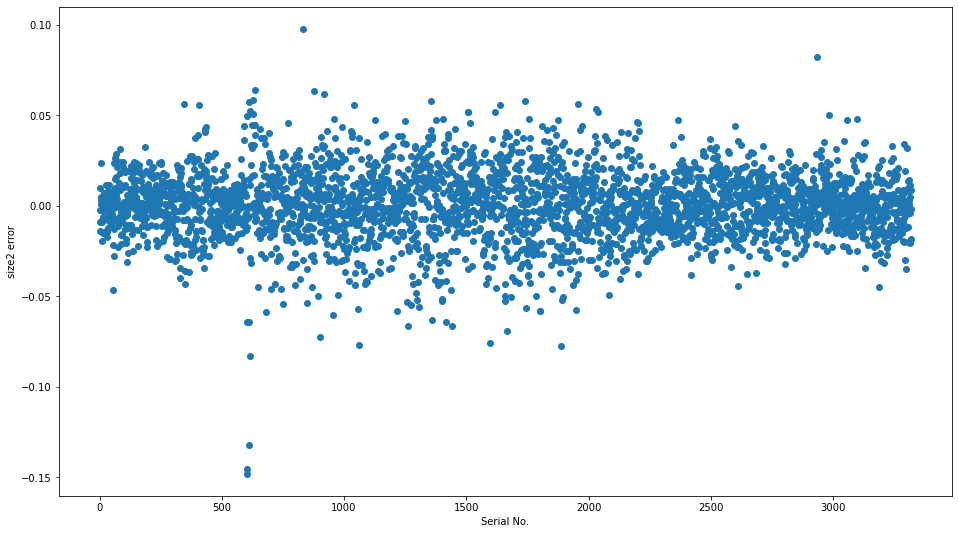

LGB1均方差得分为： 0.00035650979455206875
****************************************************************************************************
fold 3
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010646 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4246
[LightGBM] [Info] Number of data points in the train set: 13280, number of used features: 22
[LightGBM] [Info] Start training from score 200.005755
Training until validation scores don't improve for 50 rounds
[50]	training's l2: 0.00041598	valid_1's l2: 0.000413514
[100]	training's l2: 0.000353279	valid_1's l2: 0.000363056
[150]	training's l2: 0.000331008	valid_1's l2: 0.000349487
[200]	training's l2: 0.000317593	valid_1's l2: 0.000345332
[250]	training's l2: 0.000304194	valid_1's l2: 0.000340994
[300]	training's l2: 0.000292212	valid_1's l2: 0.000338468
[350]	training's l2: 0.000281434	valid_1's l2: 0.000335914
[400]	training's l2: 0.000271734	valid

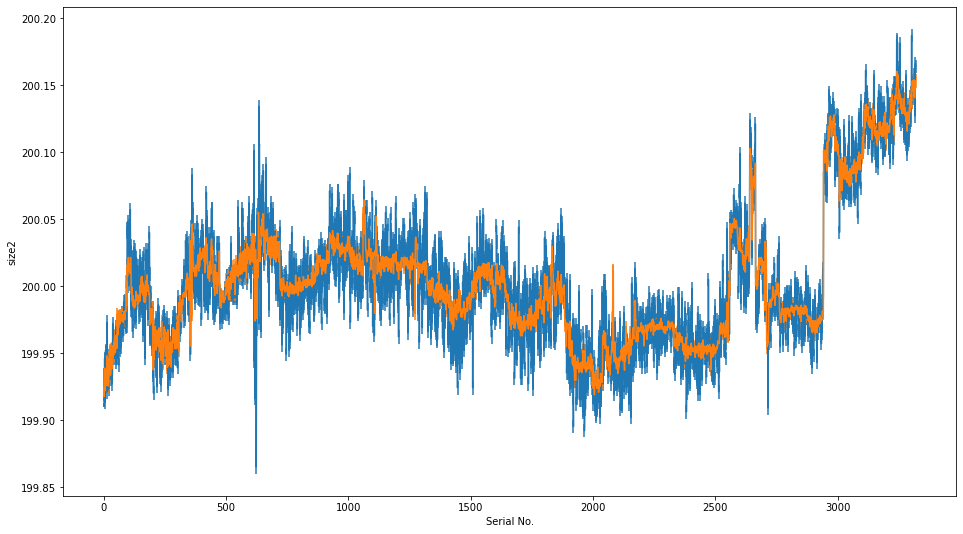

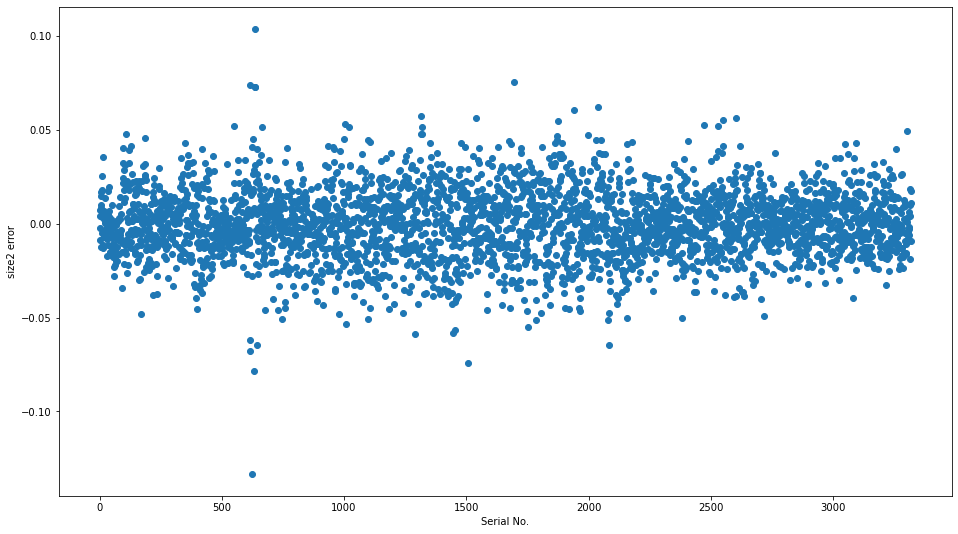

LGB1均方差得分为： 0.0003321689856012896
****************************************************************************************************
fold 4
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002695 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4246
[LightGBM] [Info] Number of data points in the train set: 13280, number of used features: 22
[LightGBM] [Info] Start training from score 200.005326
Training until validation scores don't improve for 50 rounds
[50]	training's l2: 0.000413427	valid_1's l2: 0.000410553
[100]	training's l2: 0.000349821	valid_1's l2: 0.000366828
[150]	training's l2: 0.000327714	valid_1's l2: 0.000357107
[200]	training's l2: 0.000311864	valid_1's l2: 0.000352964
[250]	training's l2: 0.000298235	valid_1's l2: 0.000351206
[300]	training's l2: 0.000287636	valid_1's l2: 0.000350248
[350]	training's l2: 0.000277532	valid_1's l2: 0.000350305
Early stopping, best iteration is:
[31

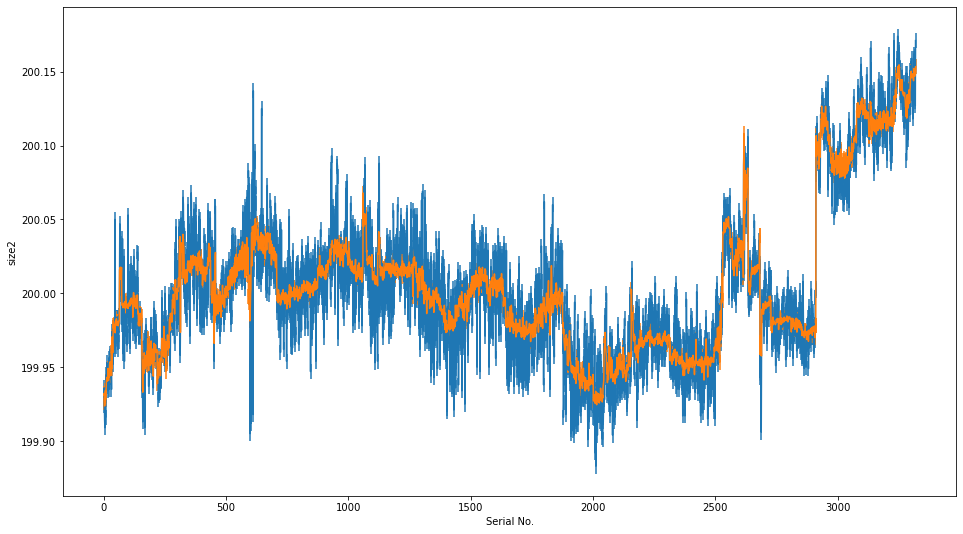

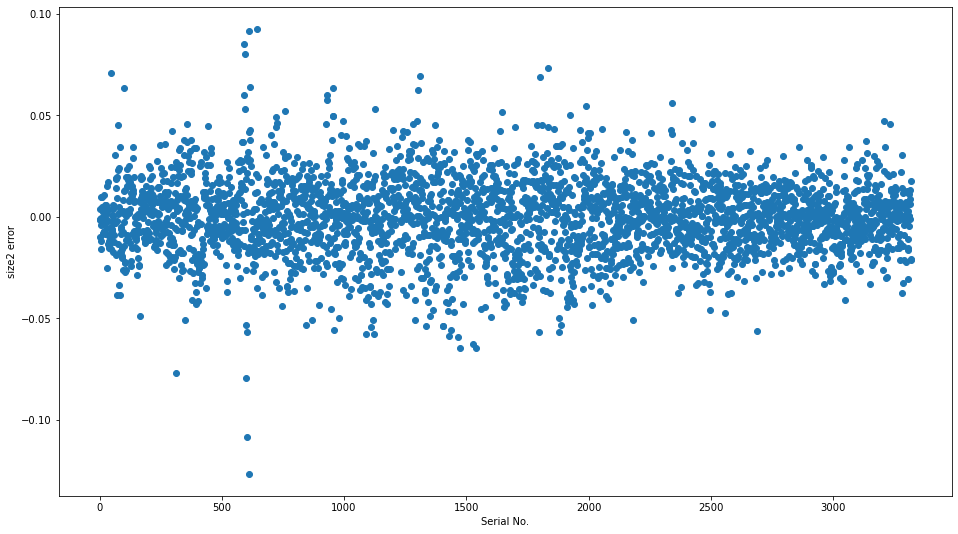

LGB1均方差得分为： 0.0003497938629960275
****************************************************************************************************
            size1       size2  size3
0      300.029559  199.972408    0.0
1      300.000645  199.952367    0.0
2      299.978263  199.921999    0.0
3      299.985540  199.932467    0.0
4      299.977800  199.922568    0.0
...           ...         ...    ...
16595  300.113660  200.150186    0.0
16596  300.117203  200.150373    0.0
16597  300.114187  200.152993    0.0
16598  300.118028  200.149280    0.0
16599  300.116641  200.152011    0.0

[16600 rows x 3 columns]
           size1       size2  size3
0     300.070099  199.975021    0.0
1     300.067119  199.963154    0.0
2     300.062579  199.965064    0.0
3     300.069256  199.967218    0.0
4     300.065399  199.974910    0.0
...          ...         ...    ...
3966  299.950836  200.114815    0.0
3967  299.949930  200.118252    0.0
3968  299.951088  200.115987    0.0
3969  299.953534  200.123673    0.0

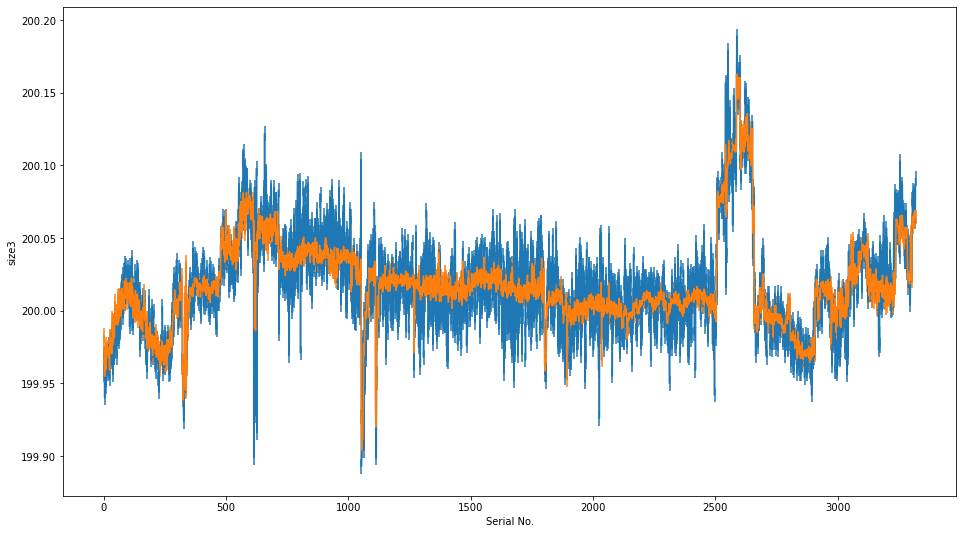

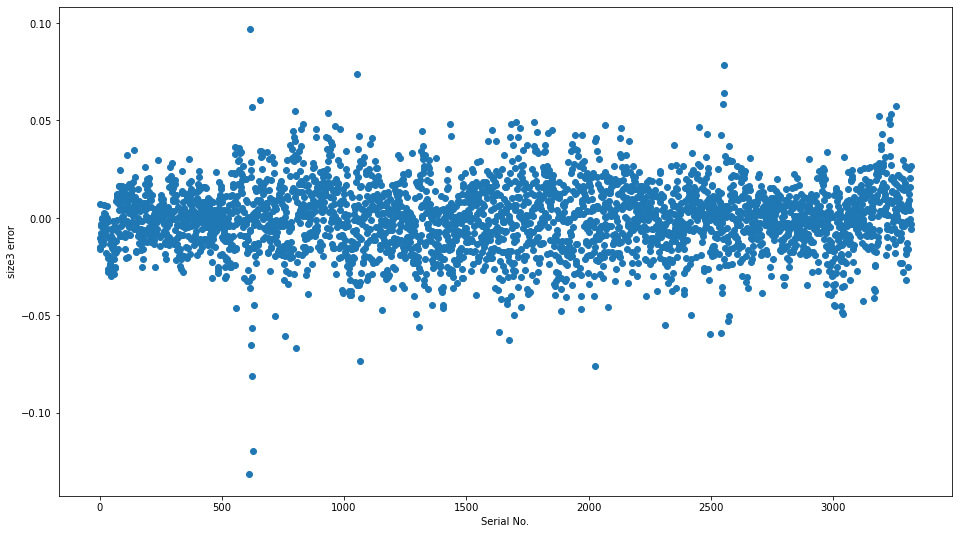

LGB1均方差得分为： 0.00031619183855371714
****************************************************************************************************
fold 1
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002095 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3994
[LightGBM] [Info] Number of data points in the train set: 13280, number of used features: 21
[LightGBM] [Info] Start training from score 200.017988
Training until validation scores don't improve for 50 rounds
[50]	training's l2: 0.000345863	valid_1's l2: 0.000337089
[100]	training's l2: 0.000312786	valid_1's l2: 0.000312371
[150]	training's l2: 0.000297564	valid_1's l2: 0.000305715
[200]	training's l2: 0.000285113	valid_1's l2: 0.000301957
[250]	training's l2: 0.000274258	valid_1's l2: 0.000299066
[300]	training's l2: 0.000264826	valid_1's l2: 0.00029715
[350]	training's l2: 0.000256772	

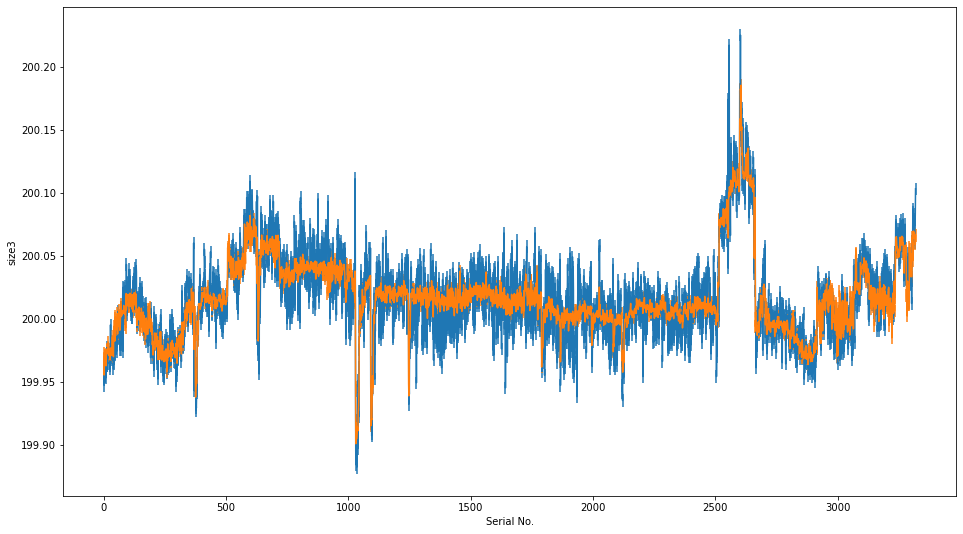

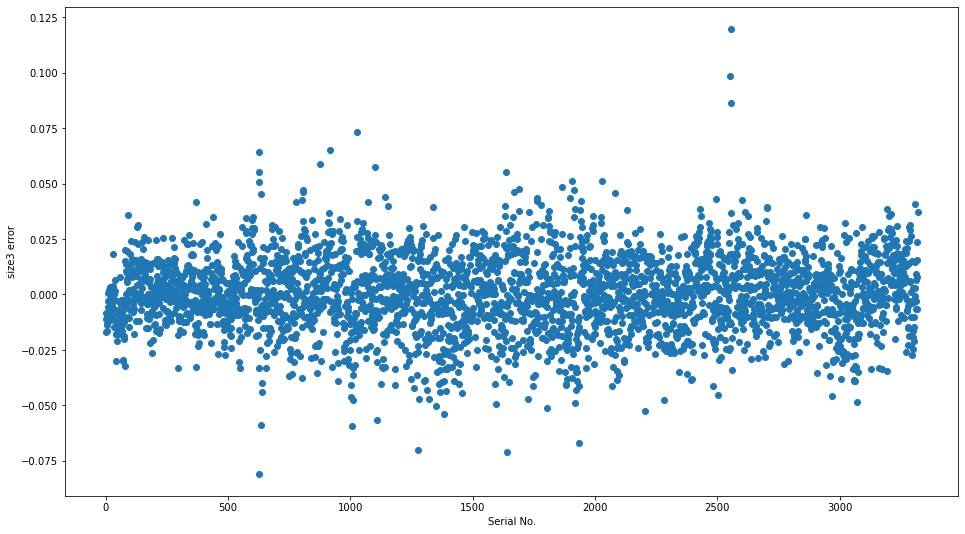

LGB1均方差得分为： 0.000292985687650123
****************************************************************************************************
fold 2
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003006 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3991
[LightGBM] [Info] Number of data points in the train set: 13280, number of used features: 21
[LightGBM] [Info] Start training from score 200.017528
Training until validation scores don't improve for 50 rounds
[50]	training's l2: 0.000338553	valid_1's l2: 0.000368598
[100]	training's l2: 0.000305117	valid_1's l2: 0.000342951
[150]	training's l2: 0.000289302	valid_1's l2: 0.000336254
[200]	training's l2: 0.000276317	valid_1's l2: 0.000331618
[250]	training's l2: 0.000265079	valid_1's l2: 0.000328427
[300]	training's l2: 0.000255572	valid_1's l2: 0.000327451
[350]	training's l2: 0.000247218	valid_1's l2: 0.000326647
[400]	training's l2: 0.000239369	valid_

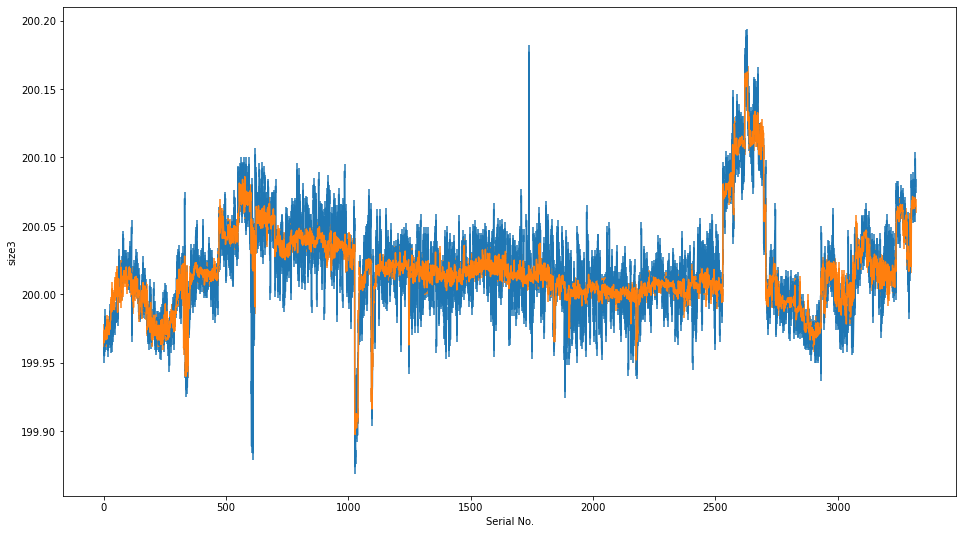

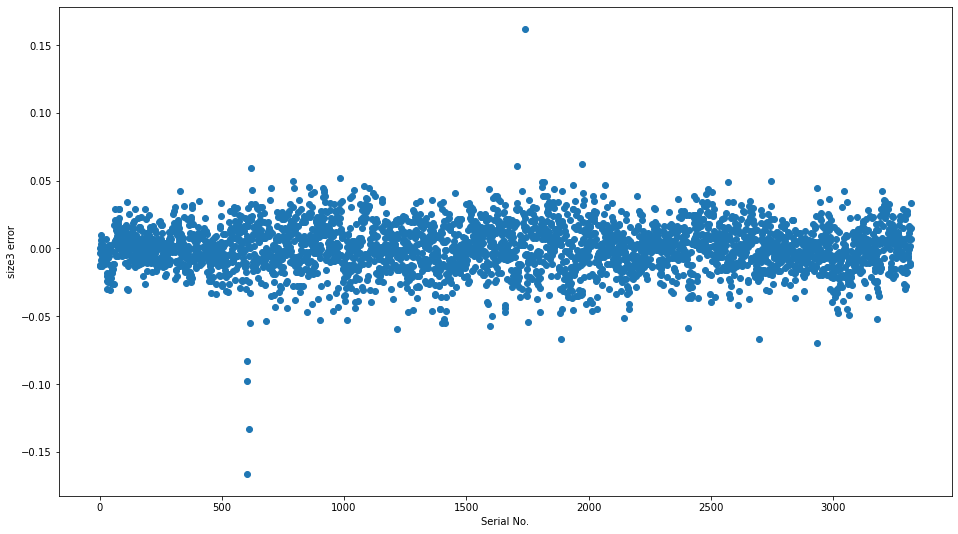

LGB1均方差得分为： 0.0003250726553874716
****************************************************************************************************
fold 3
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001485 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3991
[LightGBM] [Info] Number of data points in the train set: 13280, number of used features: 21
[LightGBM] [Info] Start training from score 200.017902
Training until validation scores don't improve for 50 rounds
[50]	training's l2: 0.000339313	valid_1's l2: 0.000353688
[100]	training's l2: 0.000305559	valid_1's l2: 0.000333829
[150]	training's l2: 0.000291145	valid_1's l2: 0.000330034
[200]	training's l2: 0.000279232	valid_1's l2: 0.000328265
[250]	training's l2: 0.000268849	valid_1's l2: 0.000327032
[300]	training's l2: 0.000259684	valid_1's l2: 0.000326541
[350]	training's l2: 0.000251904	

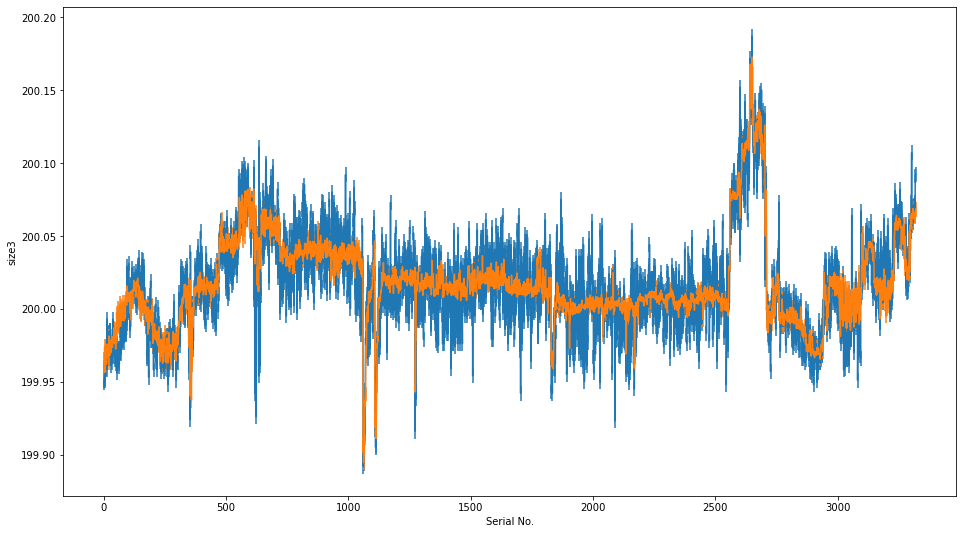

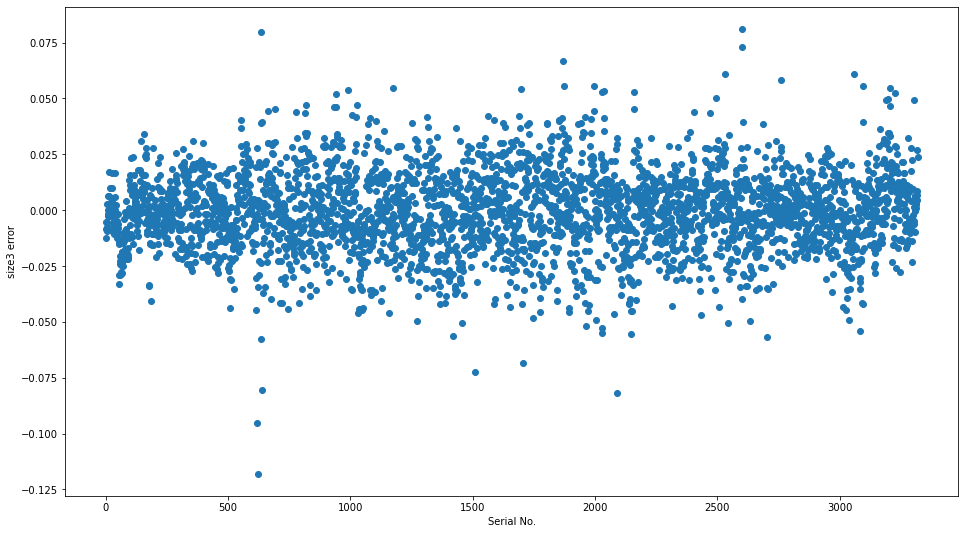

LGB1均方差得分为： 0.00032335669470875874
****************************************************************************************************
fold 4
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001913 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3991
[LightGBM] [Info] Number of data points in the train set: 13280, number of used features: 21
[LightGBM] [Info] Start training from score 200.017682
Training until validation scores don't improve for 50 rounds
[50]	training's l2: 0.000345087	valid_1's l2: 0.000338773
[100]	training's l2: 0.000311186	valid_1's l2: 0.000317104
[150]	training's l2: 0.00029533	valid_1's l2: 0.000311989
[200]	training's l2: 0.000282749	valid_1's l2: 0.000308173
[250]	training's l2: 0.00027219	valid_1's l2: 0.000307376
[300]	training's l2: 0.00026241	valid_1's l2: 0.000306395
[350]	training's l2: 0.000253097	valid_1's l2: 0.000306013
[400]	training's l2: 0.000244957	valid_1

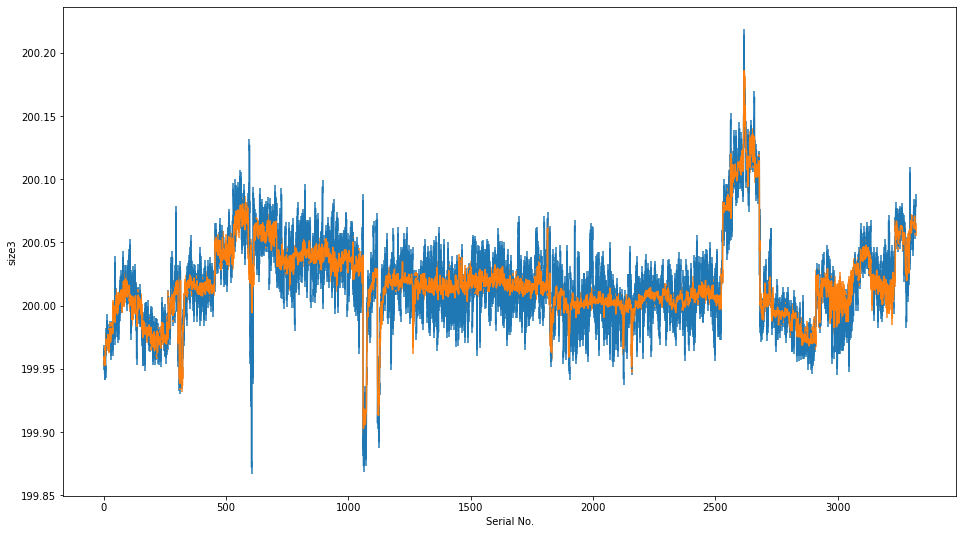

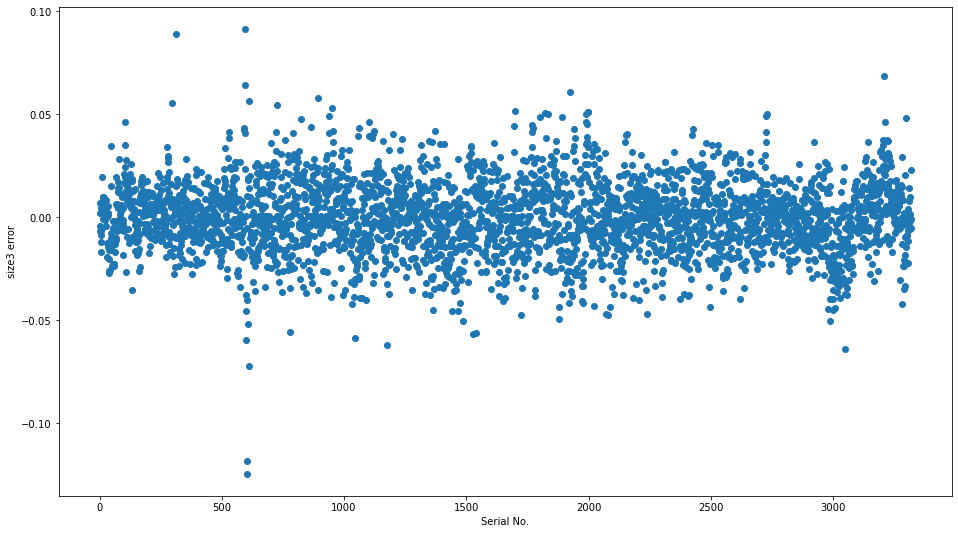

LGB1均方差得分为： 0.00030592529010564585
****************************************************************************************************
            size1       size2       size3
0      300.029559  199.972408  199.979804
1      300.000645  199.952367  199.969805
2      299.978263  199.921999  199.954968
3      299.985540  199.932467  199.961493
4      299.977800  199.922568  199.955354
...           ...         ...         ...
16595  300.113660  200.150186  200.065478
16596  300.117203  200.150373  200.065279
16597  300.114187  200.152993  200.065239
16598  300.118028  200.149280  200.064734
16599  300.116641  200.152011  200.069750

[16600 rows x 3 columns]
           size1       size2       size3
0     300.070099  199.975021  199.997946
1     300.067119  199.963154  199.996465
2     300.062579  199.965064  199.995828
3     300.069256  199.967218  199.998352
4     300.065399  199.974910  199.997178
...          ...         ...         ...
3966  299.950836  200.114815  199.969503
3967  

In [28]:
# 进行初步模型训练集结果预测

sub_file=pd.read_csv(path + '/赛题二-决赛/任务A/sub_file.csv')

for i in ['size1', 'size2', 'size3']:

    X_train=data_train[size_dic[i]]
    y_train=df_y_train[i]
    X_test=data_test[size_dic[i]]
    print(X_test.shape)
    sub_file[i]=pred_size(i, X_train, y_train, X_test, df_lgb_train_pred, df_lgb_sub_pred)

In [29]:
# 根据初赛得分，size1在2.5e4，size2在2e3，size3在1e4
sub_file

Id       size1       size2       size3
0      56694  300.070099  199.975021  199.997946
1      56699  300.067119  199.963154  199.996465
2      56705  300.062579  199.965064  199.995828
3      56708  300.069256  199.967218  199.998352
4      56712  300.065399  199.974910  199.997178
...      ...         ...         ...         ...
3966  175941  299.950836  200.114815  199.969503
3967  175956  299.949930  200.118252  199.970823
3968  175971  299.951088  200.115987  199.971749
3969  176121  299.953534  200.123673  199.972383
3970  176136  299.951465  200.118720  199.972760

[3971 rows x 4 columns]

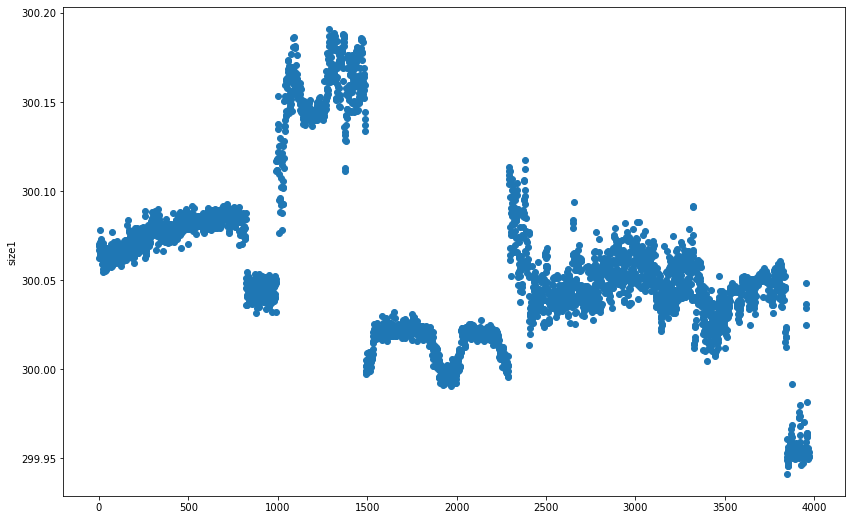

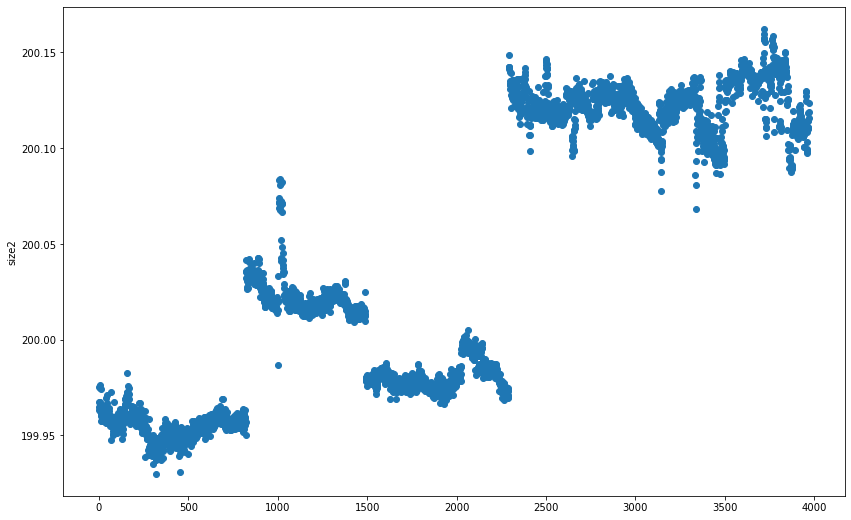

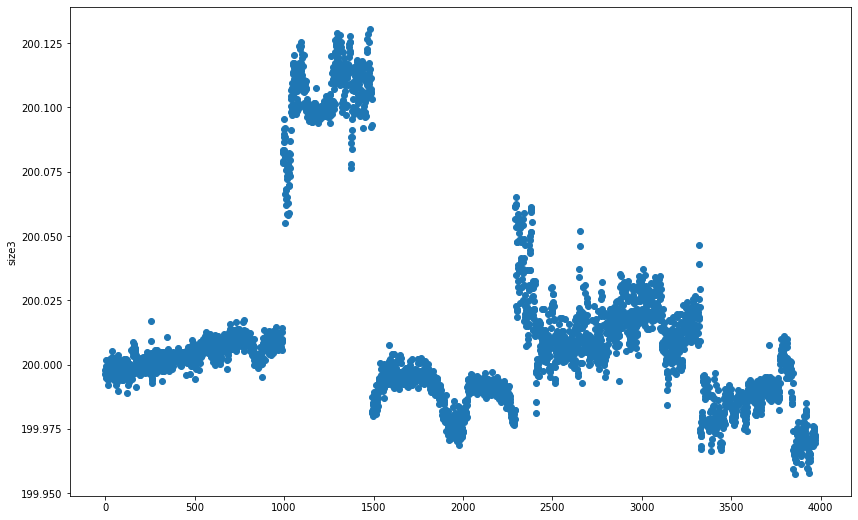

In [30]:
for i in ['size1', 'size2', 'size3']:
    plt.figure(figsize=(14,9))
    plt.scatter(np.arange(len(sub_file)), sub_file[i])
    plt.ylabel(i)
    plt.show()

In [31]:
# 对size3进行部分修正，使用两段模型单独预测，即Id在70000-100000段，产品size变化剧烈，且超规较多，单独拿出建模
# 先将test的index重置
data_sub = data_test.reset_index(drop=True)
data_sub

Sensor1_mean  Sensor2_mean  Sensor3_mean    IJ_mean  Sensor5_mean  \
0        27.007252     38.781916     34.801564  50.105871    127.362978   
1        26.515876     38.688036     33.523717  49.789262    127.247639   
2        25.805459     38.428907     37.678693  50.187201    127.329526   
3        27.395220     38.810916     35.235566  50.435031    127.430017   
4        26.817505     39.598341     36.293718  50.147547    127.435603   
...            ...           ...           ...        ...           ...   
3966     26.796366     34.193795      5.004204  25.292029     94.979268   
3967     27.347351     31.667684      5.006933  25.266799     95.616064   
3968     27.257486     32.626498      5.003470  25.396320     94.948391   
3969     26.282240     31.752183      5.002262  24.864324     95.006518   
3970     24.975001     31.030794      5.046800  24.884862     95.386085   

      Sensor6_mean  MouldTemp1_mean  MouldTemp2_mean  MouldTemp3_mean  \
0       130.711855        65.035111        54.988381        31.033524   
1       130.936963        65.018476        55.003746        30.549714   
2       130.657537        64.940381        54.976254        30.551873   
3       130.700253        64.940825        55.010349        29.999111   
4       130.927906        65.048635        55.016762        31.033206   
...            ...              ...              ...              ...   
3966     95.436762        86.917890        38.146221        78.088106   
3967     95.725153        85.797155        38.209034        76.658611   
3968     95.554355        86.313408        38.342840        78.027273   
3969     95.456485        85.348570        37.421396        76.060123   
3970     95.572641        85.225371        37.184446        76.795194   

      MouldTemp4_mean  ...  vps_by_time_enbl  vps_by_str_enbl  \
0           99.940635  ...                 1                1   
1          100.254159  ...                 1                1   
2          100.288190  ...                 1                1   
3          100.067048  ...                 1                1   
4           99.923683  ...                 1                1   
...               ...  ...               ...              ...   
3966        78.301355  ...                 1                1   
3967        77.340333  ...                 1                1   
3968        77.990209  ...                 1                1   
3969        76.689371  ...                 1                1   
3970        76.913953  ...                 1                1   

      vps_by_prss_enbl  plst_points  Id_len  Id_first  Id_diff_ratio  \
0                    1            2  6866.0     52178       0.657734   
1                    1            2  6866.0     52178       0.658462   
2                    1            2  6866.0     52178       0.659336   
3                    1            2  6866.0     52178       0.659773   
4                    1            2  6866.0     52178       0.660355   
...                ...          ...     ...       ...            ...   
3966                 1            2   602.0    175534       0.676080   
3967                 1            2   602.0    175534       0.700997   
3968                 1            2   602.0    175534       0.725914   
3969                 1            2   602.0    175534       0.975083   
3970                 1            2   602.0    175534       1.000000   

      size1_set_Id_median  size2_set_Id_median  size3_set_Id_median  
0                 300.084              199.959              200.005  
1                 300.084              199.959              200.005  
2                 300.084              199.959              200.005  
3                 300.084              199.959              200.005  
4                 300.084              199.959              200.005  
...                   ...                  ...                  ...  
3966                  NaN                  NaN                  NaN  
3967                  

In [32]:
# 根据Id将train和sub分成两段，其中80000多Id的一段，波动明显
id_thresh1 = 70000
id_thresh2 = 100000

# size波动较平稳段，成为sm smooth段
data_smId_train = data_train[(data_train['Id']<id_thresh1)|(data_train['Id']>id_thresh2)]
data_smId_sub = data_sub[(data_sub['Id']<id_thresh1)|(data_sub['Id']>id_thresh2)]
data_smId_y = df_y_train[(df_y_train['Id']<id_thresh1)|(df_y_train['Id']>id_thresh2)]
print(data_smId_train.shape)
print(data_smId_sub.shape)
print(data_smId_y.shape)

(14615, 181)
(2672, 181)
(14615, 4)


In [33]:
# size波动剧烈段，成为sp sharp段
data_spId_train = data_train[(data_train['Id']>id_thresh1)&(data_train['Id']<id_thresh2)]
data_spId_sub = data_sub[(data_sub['Id']>id_thresh1)&(data_sub['Id']<id_thresh2)]
data_spId_y = df_y_train[(df_y_train['Id']>id_thresh1)&(df_y_train['Id']<id_thresh2)]
print(data_spId_train.shape)
print(data_spId_sub.shape)
print(data_spId_y.shape)

(1985, 181)
(1299, 181)
(1985, 4)


(2672, 21)
fold 0
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009962 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3949
[LightGBM] [Info] Number of data points in the train set: 11692, number of used features: 21
[LightGBM] [Info] Start training from score 200.015384
Training until validation scores don't improve for 50 rounds
[50]	training's l2: 0.000337871	valid_1's l2: 0.00034823
[100]	training's l2: 0.000309644	valid_1's l2: 0.000331426
[150]	training's l2: 0.000294775	valid_1's l2: 0.000327276
[200]	training's l2: 0.000282603	valid_1's l2: 0.000324986
[250]	training's l2: 0.000271617	valid_1's l2: 0.000323504
[300]	training's l2: 0.000261923	valid_1's l2: 0.00032284
[350]	training's l2: 0.000252687	valid_1's l2: 0.000322012
[400]	training's l2: 0.000243982	valid_1's l2: 0.000321571
[450]	training's l2: 0.000235665	valid_1's l2: 0.000321359
[500]	training's l2: 0.000227682	valid_1's l2:

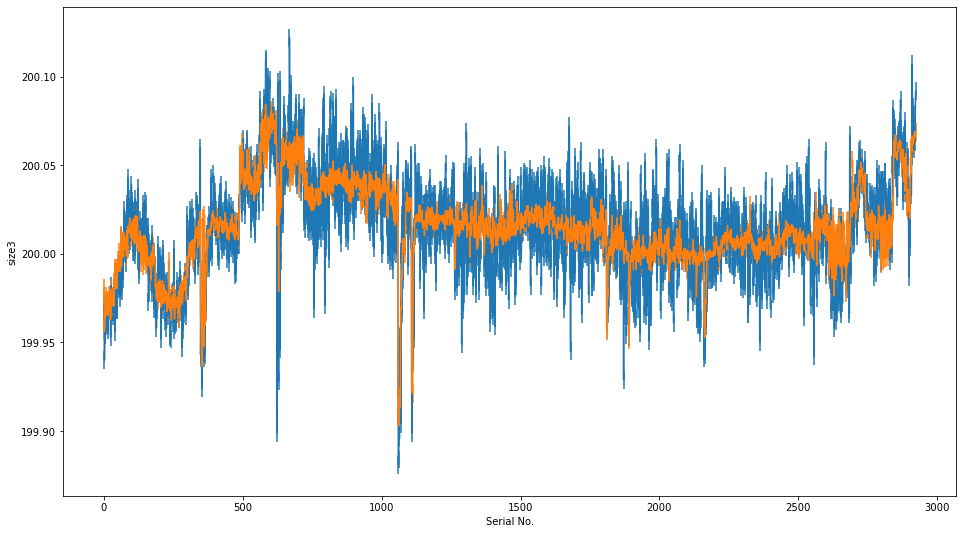

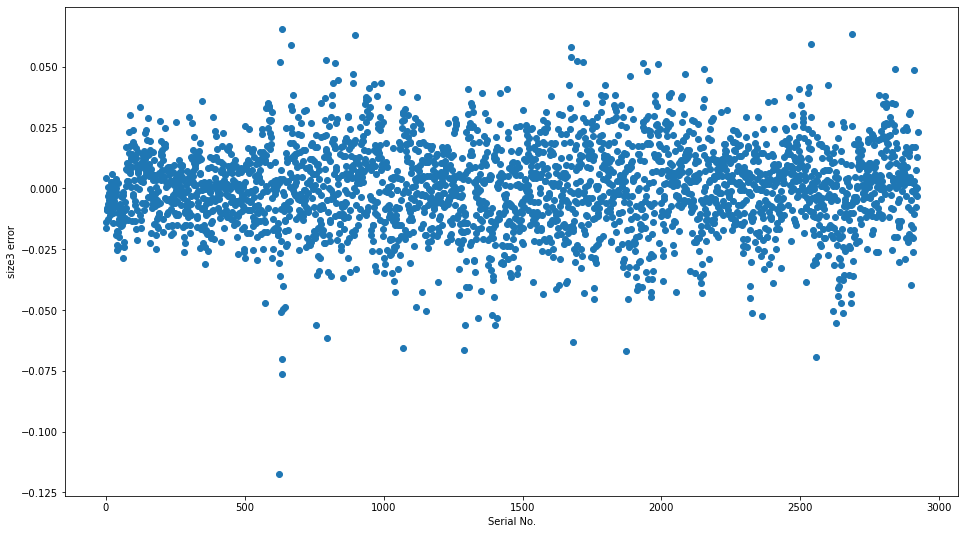

LGB1均方差得分为： 0.00032020654288830556
****************************************************************************************************
fold 1
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002858 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3946
[LightGBM] [Info] Number of data points in the train set: 11692, number of used features: 21
[LightGBM] [Info] Start training from score 200.015549
Training until validation scores don't improve for 50 rounds
[50]	training's l2: 0.000339227	valid_1's l2: 0.000344295
[100]	training's l2: 0.000311538	valid_1's l2: 0.000330391
[150]	training's l2: 0.000296642	valid_1's l2: 0.000326355
[200]	training's l2: 0.000283777	valid_1's l2: 0.000325394
[250]	training's l2: 0.000272393	valid_1's l2: 0.00032432
[300]	training's l2: 0.00026203	valid_1's l2: 0.000323375
[350]	training's l2: 0.000252528	valid_1's l2: 0.000322868
Early stopping, best iteration is:
[317

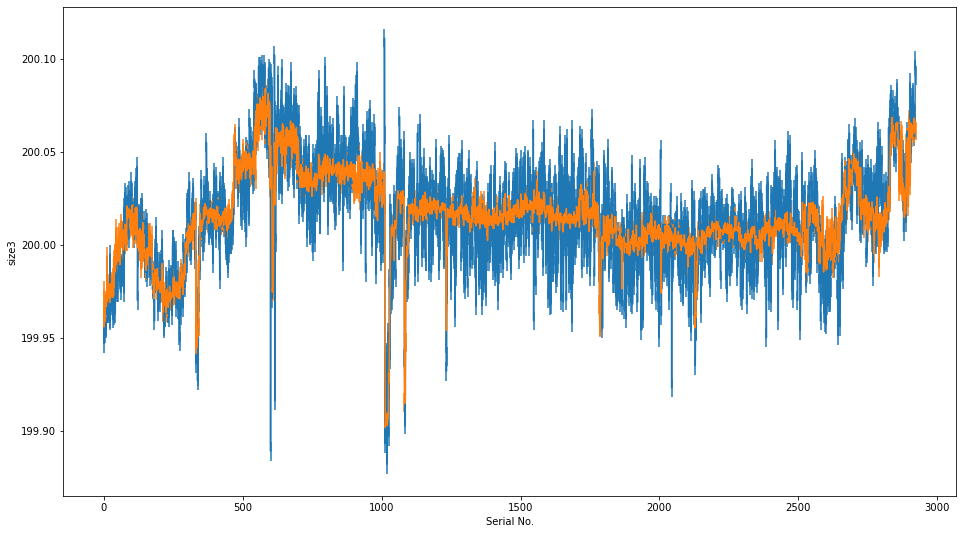

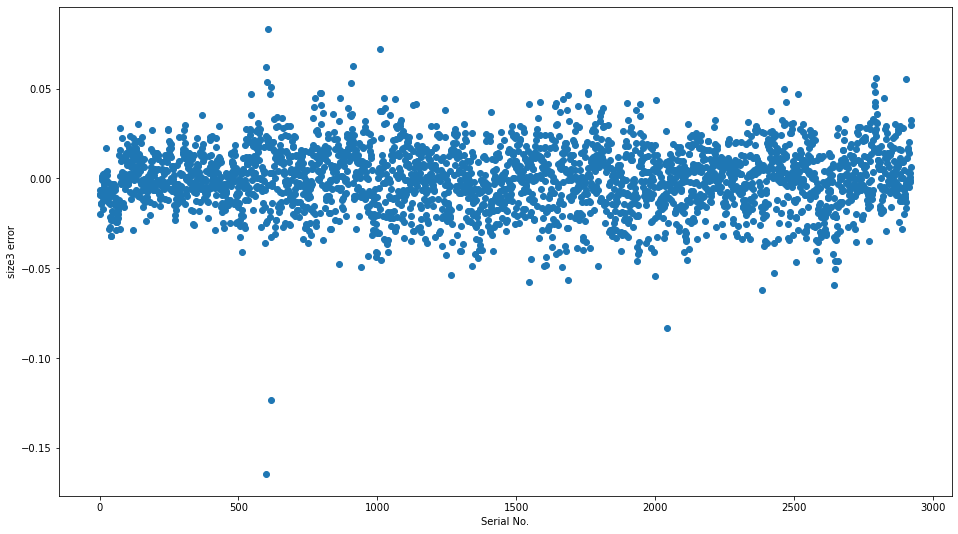

LGB1均方差得分为： 0.0003222078335632556
****************************************************************************************************
fold 2
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001596 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3946
[LightGBM] [Info] Number of data points in the train set: 11692, number of used features: 21
[LightGBM] [Info] Start training from score 200.015472
Training until validation scores don't improve for 50 rounds
[50]	training's l2: 0.000335834	valid_1's l2: 0.000365624
[100]	training's l2: 0.000307074	valid_1's l2: 0.000347722
[150]	training's l2: 0.000291604	valid_1's l2: 0.000341966
[200]	training's l2: 0.000279704	valid_1's l2: 0.000339279
[250]	training's l2: 0.000269129	valid_1's l2: 0.00033709
[300]	training's l2: 0.000258885	valid_1's l2: 0.000335957
[350]	training's l2: 0.000249371	v

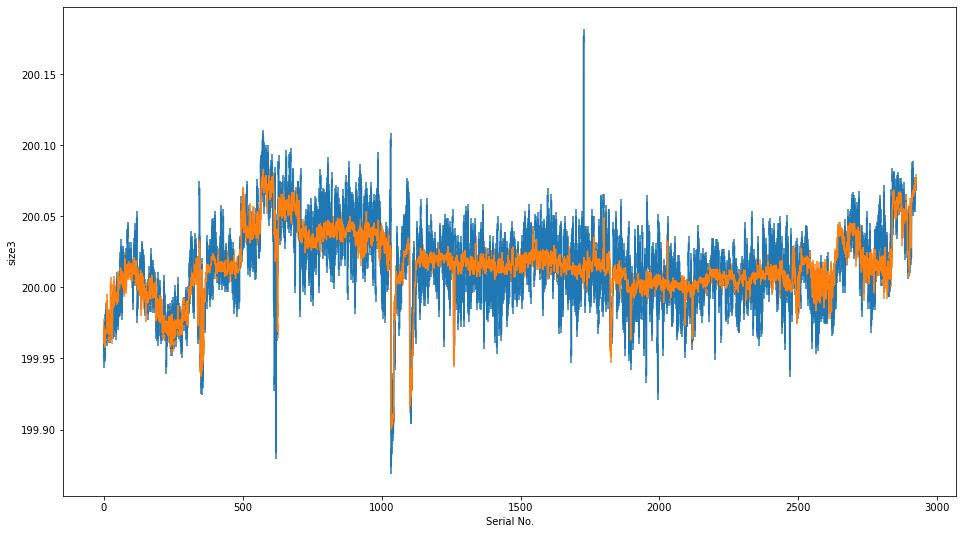

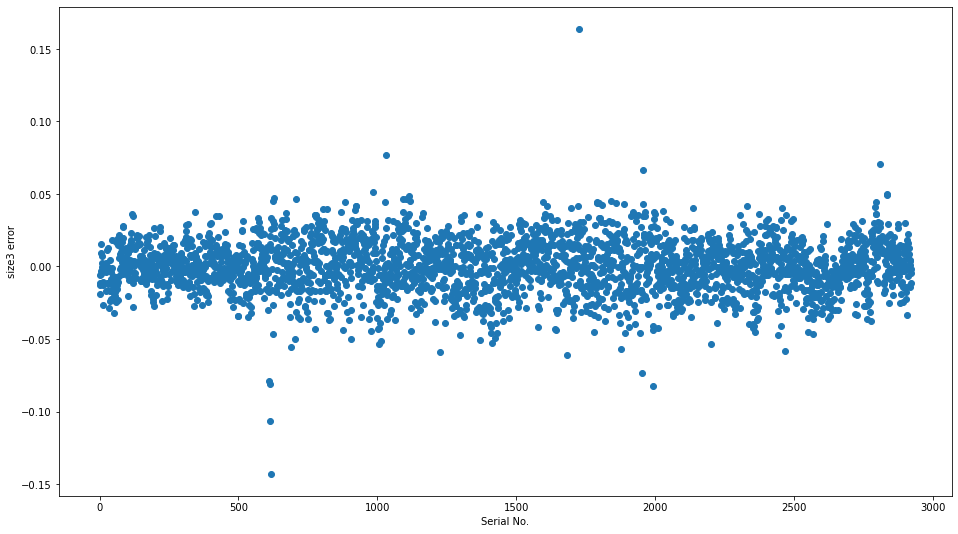

LGB1均方差得分为： 0.00033432264470342266
****************************************************************************************************
fold 3
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002672 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3946
[LightGBM] [Info] Number of data points in the train set: 11692, number of used features: 21
[LightGBM] [Info] Start training from score 200.015525
Training until validation scores don't improve for 50 rounds
[50]	training's l2: 0.000335398	valid_1's l2: 0.000356774
[100]	training's l2: 0.000307748	valid_1's l2: 0.000343967
[150]	training's l2: 0.00029253	valid_1's l2: 0.000339835
[200]	training's l2: 0.000281249	valid_1's l2: 0.00033805
[250]	training's l2: 0.000269736	valid_1's l2: 0.000336056
[300]	training's l2: 0.00025969	valid_1's l2: 0.000335262
[350]	training's l2: 0.000250201	valid_1's l2: 0.000334297
[400]	training's l2: 0.000240366	valid_1

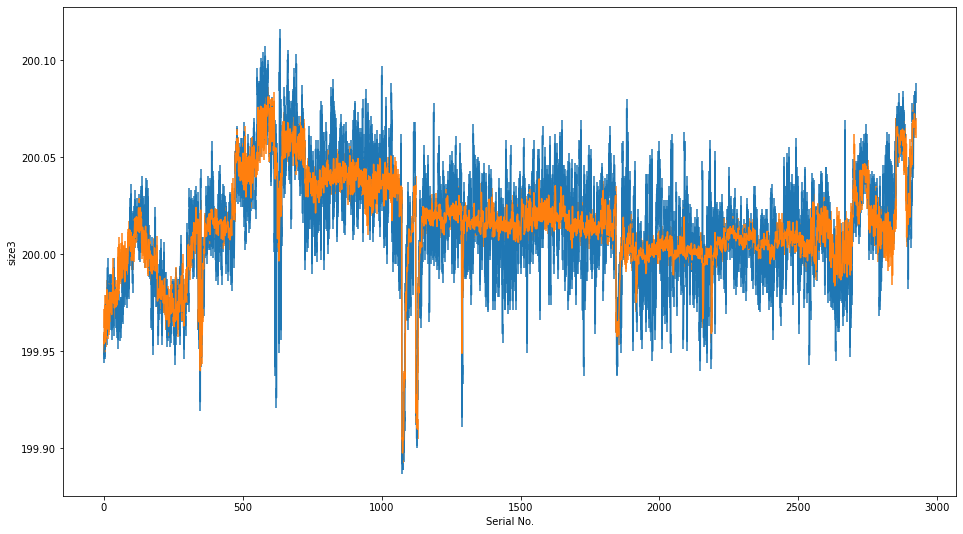

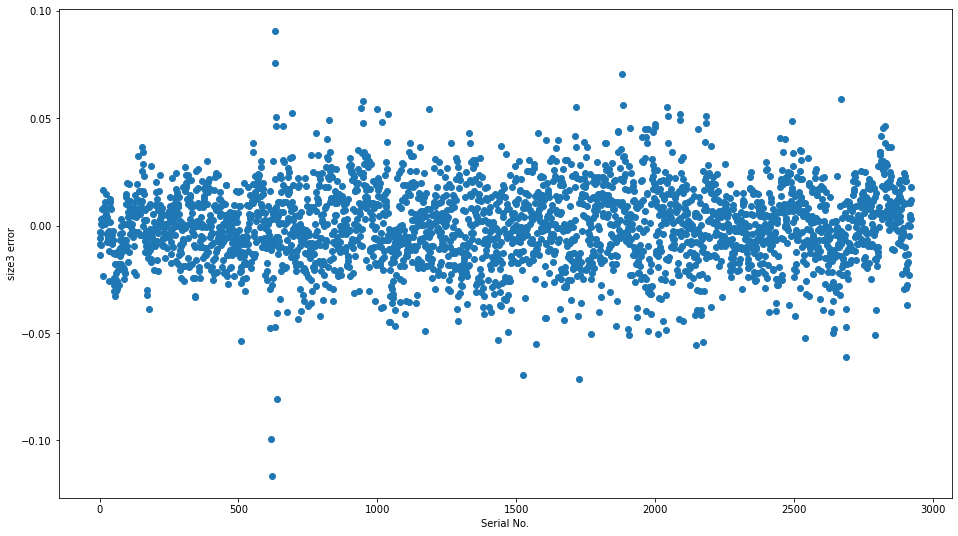

LGB1均方差得分为： 0.0003339130174323269
****************************************************************************************************
fold 4
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007069 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3946
[LightGBM] [Info] Number of data points in the train set: 11692, number of used features: 21
[LightGBM] [Info] Start training from score 200.015387
Training until validation scores don't improve for 50 rounds
[50]	training's l2: 0.000342777	valid_1's l2: 0.000339054
[100]	training's l2: 0.000313403	valid_1's l2: 0.000321598
[150]	training's l2: 0.000297819	valid_1's l2: 0.000317513
[200]	training's l2: 0.000284382	valid_1's l2: 0.000315357
[250]	training's l2: 0.00027202	valid_1's l2: 0.000313884
[300]	training's l2: 0.000261357	valid_1's l2: 0.000313515
[350]	training's l2: 0.00025154	va

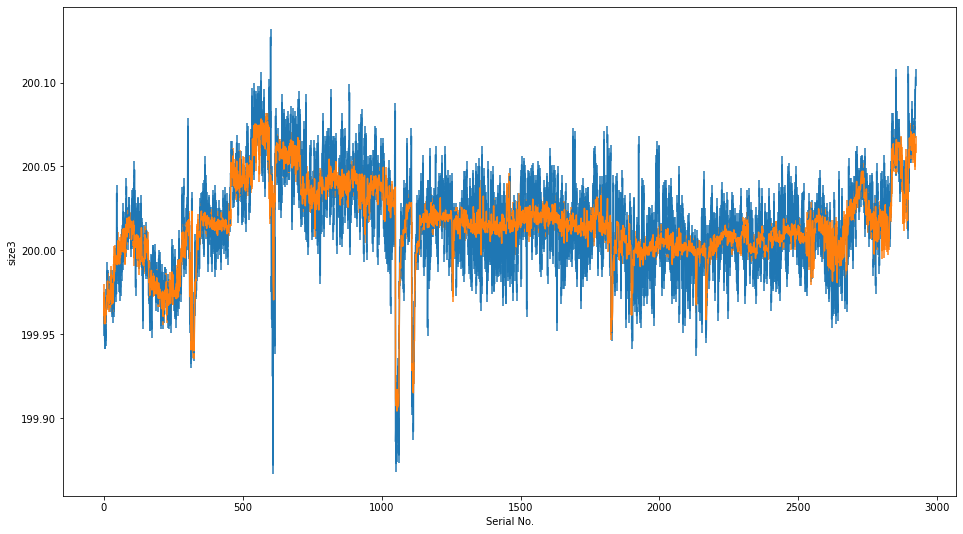

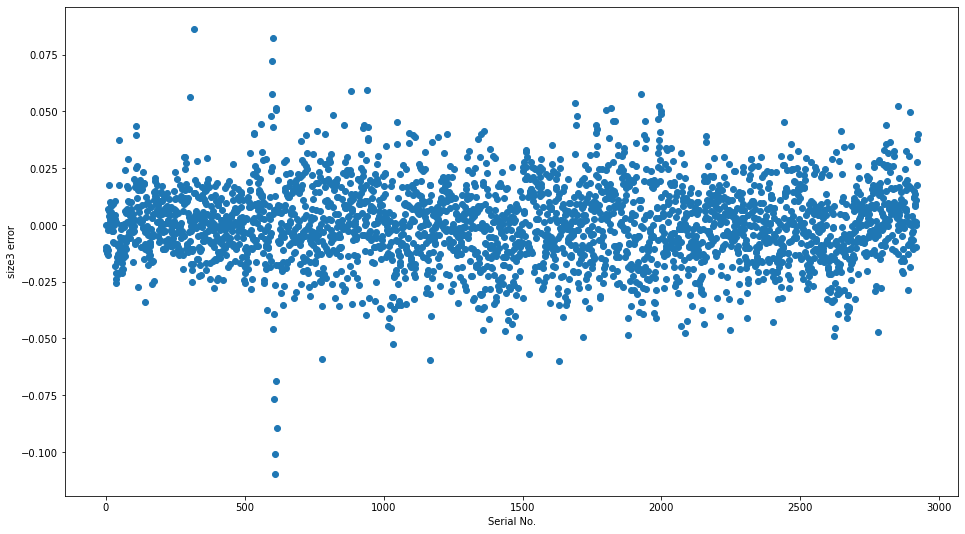

LGB1均方差得分为： 0.00031333836923018937
****************************************************************************************************
       size1  size2       size3
0        0.0    0.0  199.979766
1        0.0    0.0  199.971238
2        0.0    0.0  199.954446
3        0.0    0.0  199.962047
4        0.0    0.0  199.954856
...      ...    ...         ...
14610    0.0    0.0  200.059797
14611    0.0    0.0  200.065463
14612    0.0    0.0  200.066223
14613    0.0    0.0  200.067794
14614    0.0    0.0  200.071156

[14615 rows x 3 columns]
      size1  size2       size3
0       0.0    0.0  199.999155
1       0.0    0.0  199.997203
2       0.0    0.0  199.995035
3       0.0    0.0  199.999835
4       0.0    0.0  199.998653
...     ...    ...         ...
2667    0.0    0.0  199.931506
2668    0.0    0.0  199.930694
2669    0.0    0.0  199.931210
2670    0.0    0.0  199.933609
2671    0.0    0.0  199.931642

[2672 rows x 3 columns]


In [34]:
# smooth段的训练,仅针对size3
n_sm_train = np.zeros((len(data_smId_train), 3))
df_lgb_sm_train_pred = pd.DataFrame(n_sm_train, columns=['size1','size2','size3'])

n_sm_sub = np.zeros((len(data_smId_sub), 3))
df_lgb_sm_sub_pred = pd.DataFrame(n_sm_sub, columns=['size1','size2','size3'])

size_dic_Mul = {
    'size1': base_corr_modc+['size1_set_Id_median'],
    'size2': base_corr_modc,
    'size3': base_corr_modc+['size3_set_Id_median']
}

sub_sm=pd.read_csv(path + '/赛题二-决赛/任务A/sub_file.csv')

for i in ['size3']:

    X_train=data_smId_train[size_dic_Mul[i]]
    y_train=data_smId_y[i]
    X_test=data_smId_sub[size_dic_Mul[i]]
    print(X_test.shape)
    # 根据smooth段的index进行赋值
    sub_sm.loc[data_smId_sub.index.to_list(),i]=pred_size(i, X_train, y_train, X_test, df_lgb_sm_train_pred, df_lgb_sm_sub_pred)

(1299, 21)
fold 0
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002569 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3941
[LightGBM] [Info] Number of data points in the train set: 1588, number of used features: 21
[LightGBM] [Info] Start training from score 200.034916
Training until validation scores don't improve for 50 rounds
[50]	training's l2: 0.000183575	valid_1's l2: 0.000264644
[100]	training's l2: 0.000124874	valid_1's l2: 0.000233898
[150]	training's l2: 9.95192e-05	valid_1's l2: 0.000235322
Early stopping, best iteration is:
[109]	training's l2: 0.00011975	valid_1's l2: 0.000232719
best iteration =  109
****************************************************************************************************


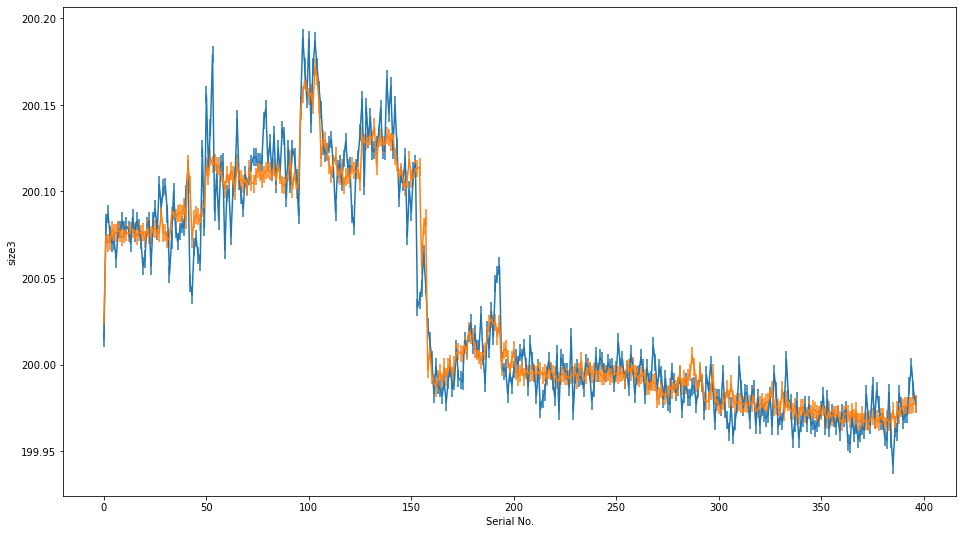

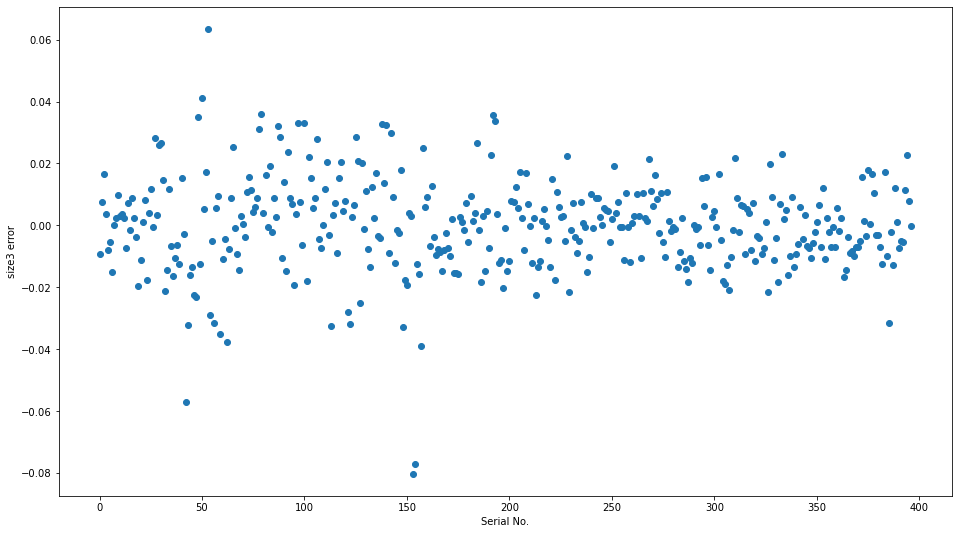

LGB1均方差得分为： 0.00023271929885890634
****************************************************************************************************
fold 1
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003361 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3940
[LightGBM] [Info] Number of data points in the train set: 1588, number of used features: 21
[LightGBM] [Info] Start training from score 200.034668
Training until validation scores don't improve for 50 rounds
[50]	training's l2: 0.000187264	valid_1's l2: 0.000249897
[100]	training's l2: 0.000124108	valid_1's l2: 0.000216208
[150]	training's l2: 9.90956e-05	valid_1's l2: 0.000214564
[200]	training's l2: 8.22994e-05	valid_1's l2: 0.000214086
Early stopping, best iteration is:
[175]	training's l2: 9.01928e-05	valid_1's l2: 0.00021346
best iteration =  175
************************************

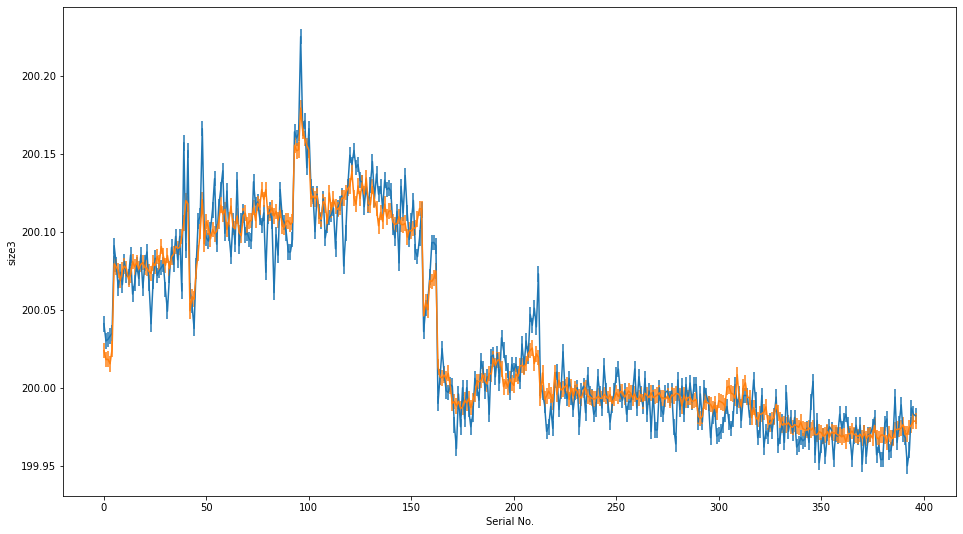

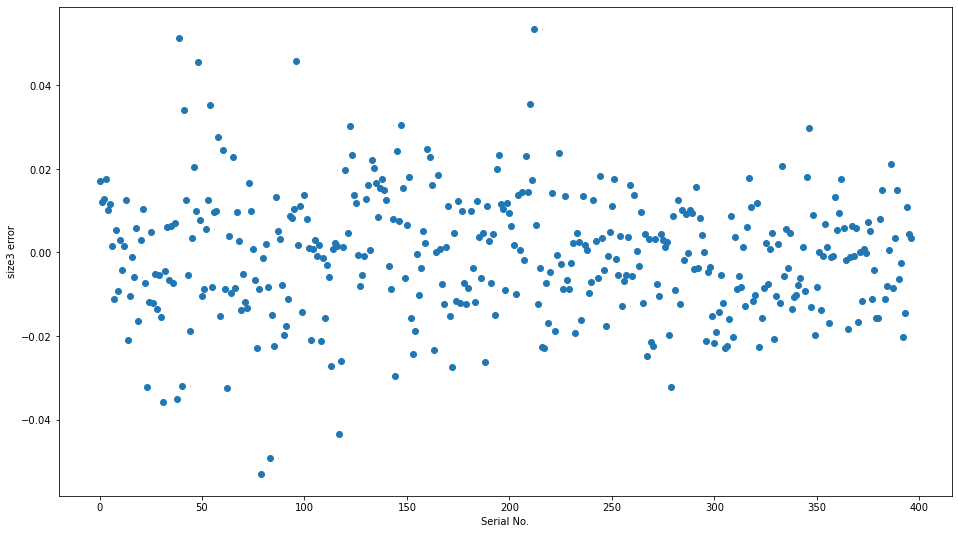

LGB1均方差得分为： 0.00021346064772678077
****************************************************************************************************
fold 2
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005329 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3936
[LightGBM] [Info] Number of data points in the train set: 1588, number of used features: 21
[LightGBM] [Info] Start training from score 200.034550
Training until validation scores don't improve for 50 rounds
[50]	training's l2: 0.000188282	valid_1's l2: 0.000250629
[100]	training's l2: 0.000126472	valid_1's l2: 0.000220864
[150]	training's l2: 0.000102398	valid_1's l2: 0.000219039
[200]	training's l2: 8.53888e-05	valid_1's l2: 0.000218253
Early stopping, best iteration is:
[196]	training's l2: 8.66105e-05	valid_1's l2: 0.000217926
best iteration =  196
***********************************

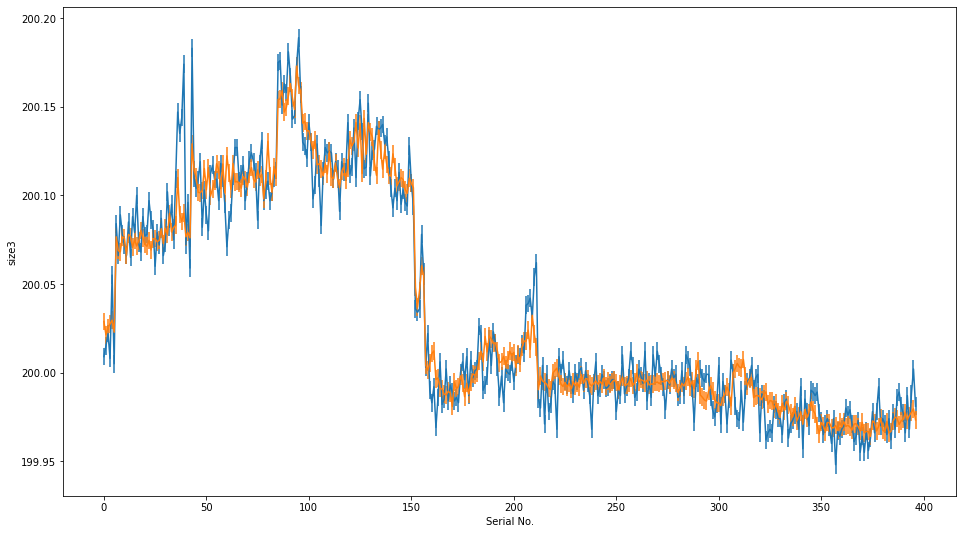

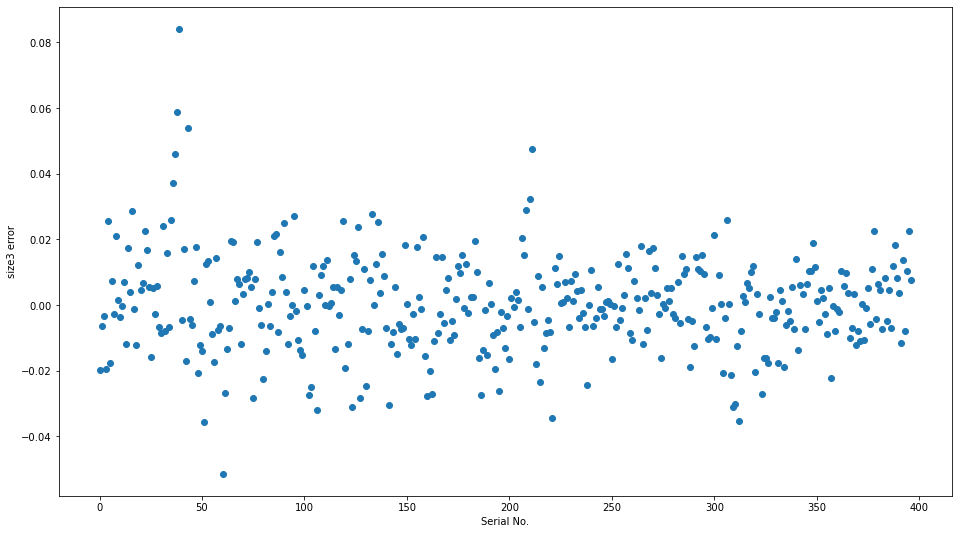

LGB1均方差得分为： 0.00021793294692095663
****************************************************************************************************
fold 3
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001786 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3940
[LightGBM] [Info] Number of data points in the train set: 1588, number of used features: 21
[LightGBM] [Info] Start training from score 200.034765
Training until validation scores don't improve for 50 rounds
[50]	training's l2: 0.000189412	valid_1's l2: 0.00023589
[100]	training's l2: 0.000126549	valid_1's l2: 0.000217744
[150]	training's l2: 0.000100495	valid_1's l2: 0.000216769
Early stopping, best iteration is:
[147]	training's l2: 0.000101668	valid_1's l2: 0.000216566
best iteration =  147
***********************************************************************************************

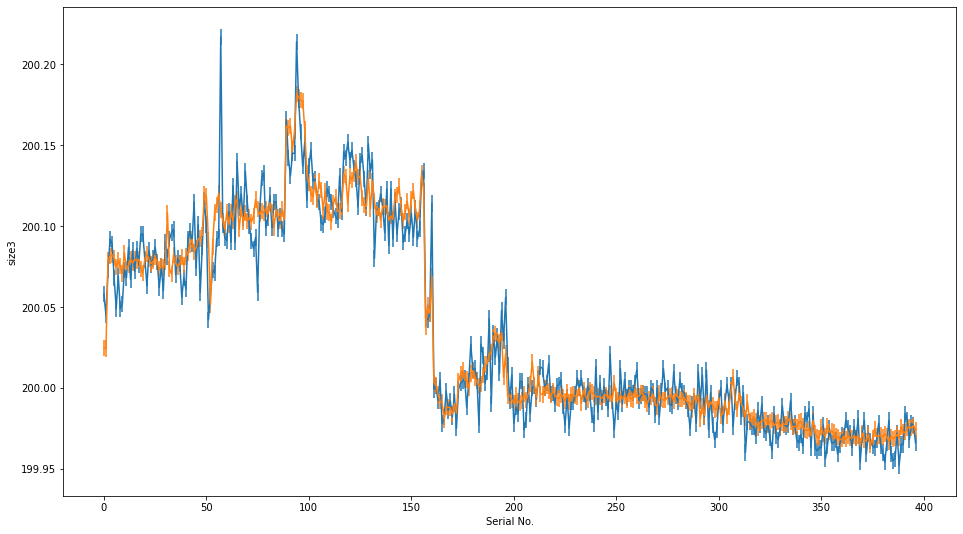

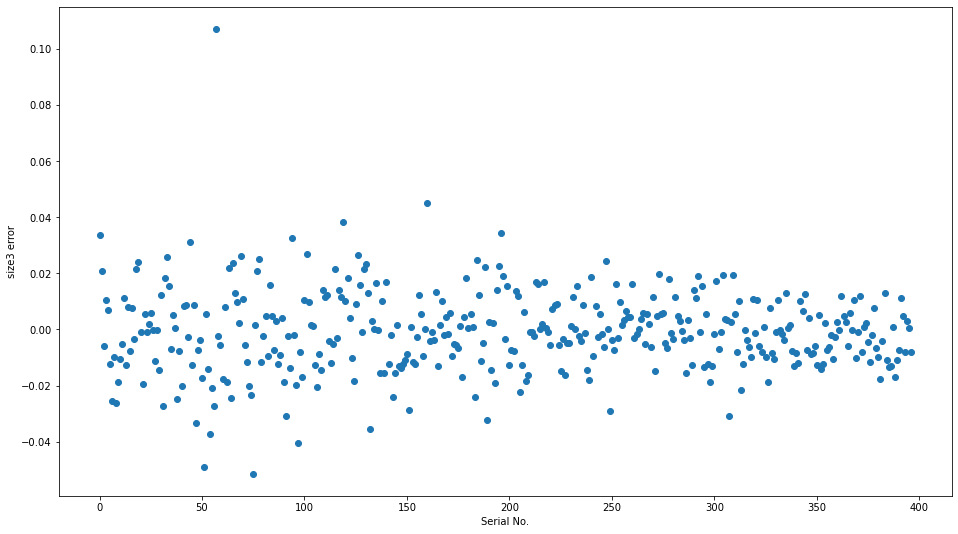

LGB1均方差得分为： 0.00021657558017466592
****************************************************************************************************
fold 4
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004603 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3942
[LightGBM] [Info] Number of data points in the train set: 1588, number of used features: 21
[LightGBM] [Info] Start training from score 200.034735
Training until validation scores don't improve for 50 rounds
[50]	training's l2: 0.000190743	valid_1's l2: 0.000197884
[100]	training's l2: 0.000127059	valid_1's l2: 0.000192068
Early stopping, best iteration is:
[70]	training's l2: 0.000152412	valid_1's l2: 0.000188281
best iteration =  70
****************************************************************************************************


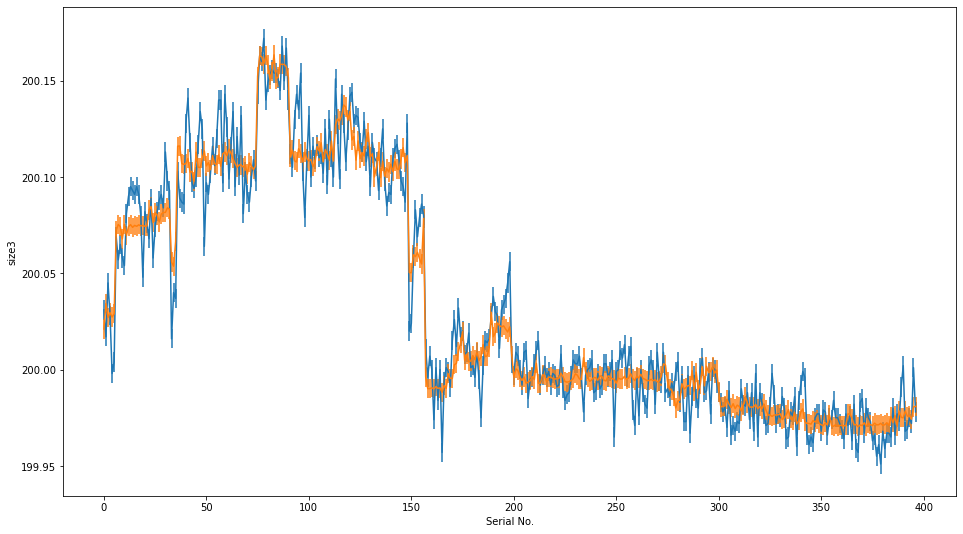

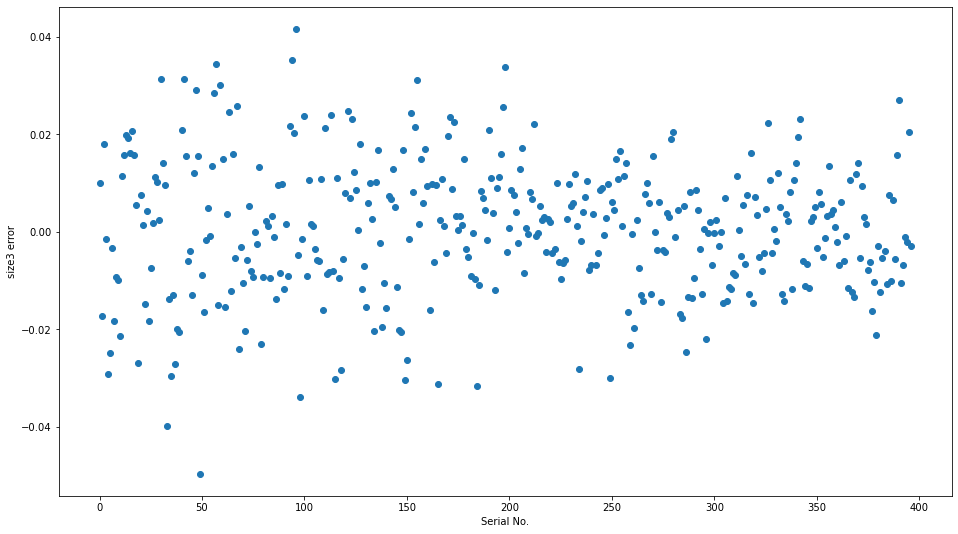

LGB1均方差得分为： 0.0001882782633332018
****************************************************************************************************
      size1  size2       size3
0       0.0    0.0  200.028139
1       0.0    0.0  200.023782
2       0.0    0.0  200.020598
3       0.0    0.0  200.022674
4       0.0    0.0  200.023176
...     ...    ...         ...
1980    0.0    0.0  199.975808
1981    0.0    0.0  199.978133
1982    0.0    0.0  199.978966
1983    0.0    0.0  199.979477
1984    0.0    0.0  199.977840

[1985 rows x 3 columns]
      size1  size2       size3
0       0.0    0.0  200.069784
1       0.0    0.0  200.076347
2       0.0    0.0  200.071852
3       0.0    0.0  200.076863
4       0.0    0.0  200.077395
...     ...    ...         ...
1294    0.0    0.0  199.978697
1295    0.0    0.0  199.982477
1296    0.0    0.0  199.983343
1297    0.0    0.0  199.981116
1298    0.0    0.0  199.979397

[1299 rows x 3 columns]


In [35]:
# sharp段的训练
n_sp_train = np.zeros((len(data_spId_train), 3))
df_lgb_sp_train_pred = pd.DataFrame(n_sp_train, columns=['size1','size2','size3'])

n_sp_sub = np.zeros((len(data_spId_sub), 3))
df_lgb_sp_sub_pred = pd.DataFrame(n_sp_sub, columns=['size1','size2','size3'])

size_dic_Mul = {
    'size1': base_corr_modc+['size1_set_Id_median'],
    'size2': base_corr_modc,
    'size3': base_corr_modc+['size3_set_Id_median']
}


for i in ['size3']:

    X_train=data_spId_train[size_dic_Mul[i]]
    y_train=data_spId_y[i]
    X_test=data_spId_sub[size_dic_Mul[i]]
    print(X_test.shape)
     # 根据sharp段的index进行赋值
    sub_sm.loc[data_spId_sub.index.to_list(),i]=pred_size(i, X_train, y_train, X_test, df_lgb_sp_train_pred, df_lgb_sp_sub_pred)

In [36]:
sub_sm

Id  size1  size2       size3
0      56694      1      1  199.999155
1      56699      1      1  199.997203
2      56705      1      1  199.995035
3      56708      1      1  199.999835
4      56712      1      1  199.998653
...      ...    ...    ...         ...
3966  175941      1      1  199.931506
3967  175956      1      1  199.930694
3968  175971      1      1  199.931210
3969  176121      1      1  199.933609
3970  176136      1      1  199.931642

[3971 rows x 4 columns]

In [37]:
# 将更新后的size3替换原size3
sub_file_mod = sub_file.copy()
sub_file_mod.loc[:,'size3'] = sub_sm['size3']
sub_file_mod

Id       size1       size2       size3
0      56694  300.070099  199.975021  199.999155
1      56699  300.067119  199.963154  199.997203
2      56705  300.062579  199.965064  199.995035
3      56708  300.069256  199.967218  199.999835
4      56712  300.065399  199.974910  199.998653
...      ...         ...         ...         ...
3966  175941  299.950836  200.114815  199.931506
3967  175956  299.949930  200.118252  199.930694
3968  175971  299.951088  200.115987  199.931210
3969  176121  299.953534  200.123673  199.933609
3970  176136  299.951465  200.118720  199.931642

[3971 rows x 4 columns]

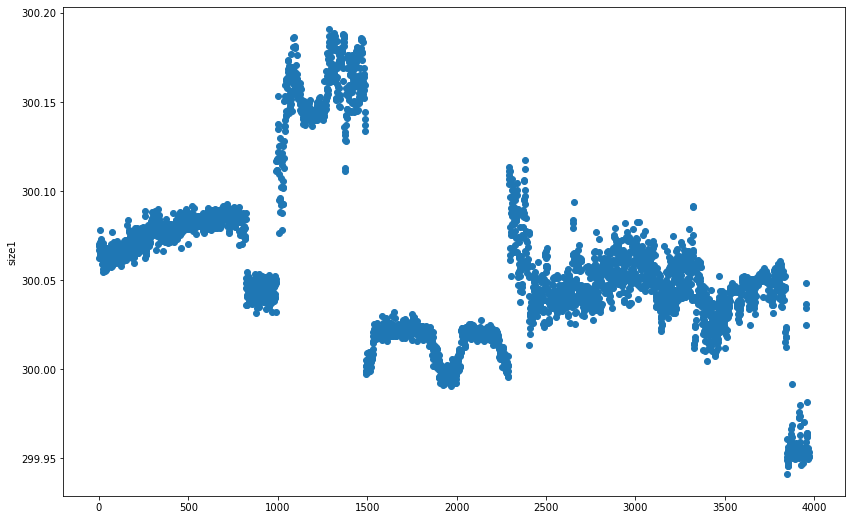

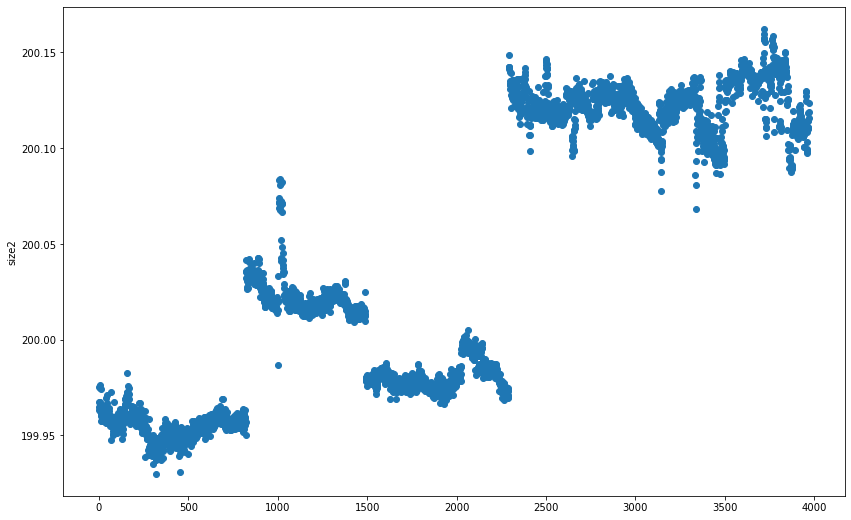

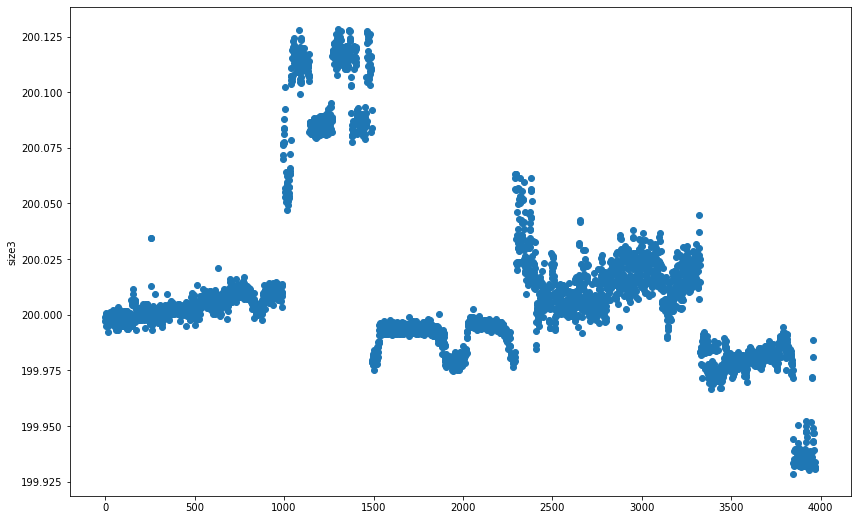

In [38]:
for i in ['size1', 'size2', 'size3']:
    plt.figure(figsize=(14,9))
    plt.scatter(np.arange(len(sub_file_mod)), sub_file_mod[i])
    plt.ylabel(i)
    plt.show()

In [39]:
sub_file_mod.to_csv('molding_pred_final_sub_20201027.csv', index=False)